# Primary segmentation code
    Aims:
        -Reliably identify at least 1 pollen grain from light microscope images
        -Extract this region from the image to perform measurements for input to machine learning
        -Measurements of geometric features as well as textural features

    Find input image scraping scripts in 'webscraping' branch in git

In [691]:
import os
import csv
from pathlib import Path
import numpy as np
import pandas as pd
import skimage.filters as sfi
import skimage.measure as sme
import skimage.segmentation
from skimage.feature import canny, peak_local_max
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.feature import texture as sft
import skimage.morphology as smo
from PIL import Image, ImageEnhance
from scipy import ndimage as nd
import matplotlib.pyplot as plt
import math
import cv2

inputfolder = Path("Saps excuded\Included SAPS")
outputfolder = Path(os.getcwd())
#Set dictionary names
measures = {}
count = {}

def segment(path, outputfolder):
    img = Image.open(path).convert('L')
    neatarray = np.array(img)
#For region exclusion and for future implementing of adaptability to different resolution images
    w,h = img.size
    area = w*h
#Increase conrast of input to clarify edges; contrast works better at lower values for dilation so repeated at line 41
    enhance = ImageEnhance.Contrast(img)
    cont = enhance.enhance(10)
    cont = np.array(cont)
#Dilation of image - This shrinks pollen silhouettes to help with clustering issues
    selem = smo.disk(4)    
    dilated = smo.dilation(cont, selem)
    
    cont = enhance.enhance(100)
    cont = np.array(cont)

#Denoising filter. Devened used for edge detection while evened used to accurately find highest and lowest grey values for watershed markers
    selem = smo.disk(2)
    devened = sfi.rank.mean_bilateral(dilated, selem)   
    selem = smo.disk(4)
    evened = sfi.rank.mean_bilateral(cont, selem)
#Canny edge detection filter detects object edges and outputs boolean array
    elevation_map = canny(dilated, sigma = 0.8 ,low_threshold=100,high_threshold=1) 

#Markers defined by highest and lowest grey levels. Level reduced/decreased by 1/4 SD 
    high = np.amax(evened)
    low = np.amin(evened)
    sd = np.std(evened) 
    
    markers = np.zeros_like(neatarray)
    markers[evened < low +(0.25*sd) ] = 3
    markers[evened > high-(0.25*sd)] = 2
#Convert canny output binary array to use as mask
    elevation_map = elevation_map.astype(int)
#Watershed function floods regions from markers
    segmentation = skimage.segmentation.watershed(evened, markers,mask=elevation_map, connectivity = 1)
    # thresh = sfi.threshold_otsu(segmentation)
#Fill smaller holes within regions - usually due to noise; Label each region
    segmentation = nd.binary_fill_holes(segmentation)
    # elevation_map2 = canny(segmentation, sigma = 1 ,low_threshold=70 ,high_threshold=1) 
    # segmentation = skimage.segmentation.watershed(elevation_map2, markers,mask=elevation_map, connectivity = 0.5)   
    label = sme.label(segmentation)
 
    for box in sme.regionprops(label):
#Attempt to filter out non-pollen regions using size and circularity factor
        if area > box.area > 250 and (box.perimeter**2)/(4*math.pi*box.area) < 2.5:
            coins = imread(path, as_gray=True)
            coins = img_as_ubyte(coins)
#Get region bounding box and crop image to it so GLCM functions only apply to relevant region
            coord = box.bbox                
            boxx = coins[coord[0]:coord[1],coord[2]:coord[3]]
#Defines inputs for GLCM
            distances = np.array([1])
            angles = np.array([0, np.pi/8, np.pi/4, 3*(np.pi/8), np.pi/2, 5*(np.pi/8), 3*(np.pi/4), 7*(np.pi/8)])
#if function is because some bounding box coordinates were coming back incorrect
            if boxx.size>0:   
                glcm = sft.greycomatrix(boxx,distances,angles,levels=256)
                correlation = sft.greycoprops(glcm, prop='correlation').mean()
                contrast = sft.greycoprops(glcm, prop='contrast').mean()
                dissimilarity = sft.greycoprops(glcm, prop='dissimilarity').mean()
                homogeneity = sft.greycoprops(glcm, prop='homogeneity').mean()
                ASM = sft.greycoprops(glcm, prop='ASM').mean()
                energy = sft.greycoprops(glcm, prop='energy').mean()
            else:
                continue    
#Empty list for detected no. of particles
    no = []
    for i, region in enumerate(sme.regionprops(label)):
#Take regions with aforementioned criteria
            if area > region.area > 250 and (region.perimeter**2)/(4*math.pi*region.area) < 2.5 and boxx.size>0:
#Calculate P/E ratio                
                PE = region.major_axis_length/region.minor_axis_length
#Add to count list
                no.append(i)
#Add key:value pair to dictionary of Filename:Measures
                measures[path.stem+f'-{i}'] = [region.area, region.perimeter, region.major_axis_length, region.minor_axis_length, PE, region.equivalent_diameter, region.eccentricity, region.extent, region.local_centroid, region.bbox, contrast, dissimilarity, homogeneity, ASM, energy, correlation]
#Add count to seperate dictionary
    test = len(no)
    count[path.stem] = [test]
        
for path in inputfolder.glob("*.jpg"):
    segment(path, outputfolder)
print('done')

done


### 'measures' dictionary output from above code using a reduced dataset
    -Reduced dataset excludes images with high levels of clustering, noise, shed exines, no. of grains, or any criteria          which could reasonably be expected of the end user

In [692]:
measuresrds = {'Agapanthus praecox v%2320BCC618': [13714, 459.88939366884495, 170.43959027300642, 102.9783563896085, 1.6551010935556687, 132.1408608890453, 0.7968382396465793, 0.747194072136864, (56.824413008604346, 76.14656555344904), (53, 197, 167, 358), 95.16005621218707, 5.976339441134323, 0.30478129756866035, 0.0016805565079166629, 0.04088530958697989, 0.9808566668107525], 'Agave tequilana1106': [268, 78.8761543394987, 24.088735305348422, 17.108362717482137, 1.4080093871714217, 18.47236308621676, 0.7039772347212878, 0.5642105263157895, (9.276119402985074, 10.223880597014926), (133, 251, 152, 276), 121.09359091208971, 6.625722516937812, 0.2980689411585442, 0.0021641061866868256, 0.04642169119772116, 0.9209261085416609], 'Agave tequilana2588': [356, 101.74011537017762, 41.681316649084124, 13.295700698671276, 3.1349469722381467, 21.290215544369623, 0.9477598775403788, 0.4188235294117647, (12.039325842696629, 15.960674157303371), (394, 509, 419, 543), 78.90179798646801, 5.24813695925763, 0.2927504414796964, 0.003632456947464947, 0.06014592761214558, 0.9455938864496429], 'Agrimonia eupatoria244': [6445, 302.69343417595167, 100.24561254699282, 82.21206287212735, 1.2193540588187752, 90.58713410754379, 0.5722111354045519, 0.7981424148606812, (46.44328937160589, 43.07633824670287), (192, 278, 287, 363), 63.81297670218638, 5.268086273309814, 0.20870129658606595, 0.0009495411327278909, 0.0307761935018838, 0.9672464921152927], 'Albuca canadiensis13': [43734, 834.5361466505707, 290.2344272183682, 193.36285595857535, 1.5009833495660918, 235.97427455010347, 0.7457464104518237, 0.7231150793650793, (155.45486349293455, 107.96638770750445), (77, 217, 365, 427), 113.94889418789062, 7.25009824692939, 0.1836735990339277, 0.0007570873024449979, 0.02747493636087614, 0.9798872062591595], 'Albuca canadiensis26': [42440, 828.3523804664972, 276.6923894480226, 196.1725354910755, 1.4104542654525163, 232.4570633010757, 0.7052170862421564, 0.7352482588960881, (139.85897737983035, 107.91781338360038), (90, 196, 356, 413), 140.48875680609882, 6.968523692992589, 0.19406846100460784, 0.0008506821383068611, 0.02913549659486629, 0.9798531604467747], 'Allium karataviense21': [3730, 239.62236636408616, 86.51086316052104, 55.63069755062071, 1.5550921877584074, 68.91432000580255, 0.765825291737931, 0.7084520417853751, (33.611796246648794, 42.33190348525469), (141, 125, 206, 206), 56.378065548499606, 3.7409160406749846, 0.4088721750168748, 0.004093477752700591, 0.06380434841285076, 0.9845188211741321], 'Allium karataviense27': [4097, 243.3797256769669, 81.77671306514831, 64.19825800413307, 1.2738151409012306, 72.22508161836829, 0.6194409323341333, 0.7592661230541141, (35.35220893336588, 34.02391994142055), (189, 421, 265, 492), 56.378065548499606, 3.7409160406749846, 0.4088721750168748, 0.004093477752700591, 0.06380434841285076, 0.9845188211741321], 'Alloplectus mummularia314': [271, 81.49747468305833, 33.43395261113278, 12.65847818911366, 2.6412300208318964, 18.575465448360347, 0.9255556975561108, 0.43993506493506496, (11.933579335793358, 12.664206642066421), (126, 181, 148, 209), 96.19494953440899, 5.860271788877286, 0.24732881061915135, 0.0013307846189228748, 0.036413591132652995, 0.8873637221933498], 'Alloplectus mummularia564': [559, 119.67514421272202, 30.156175262665418, 28.889856051280447, 1.0438326590875777, 26.678472698169138, 0.28674159414100253, 0.5464320625610948, (17.72093023255814, 13.590339892665474), (238, 396, 269, 429), 96.19494953440899, 5.860271788877286, 0.24732881061915135, 0.0013307846189228748, 0.036413591132652995, 0.8873637221933498], 'Aloe bellatula123': [4149, 250.55129855222071, 91.64599174883287, 57.76856071850208, 1.5864337038862826, 72.68198450170571, 0.7763154130168343, 0.7422182468694096, (31.892263195950832, 41.78380332610268), (121, 191, 186, 277), 59.471311475409834, 4.985753115420498, 0.2478690453410836, 0.0014199567424338076, 0.037581375992986416, 0.9760824606812227], 'Aloe bellatula130': [4538, 264.3086578651014, 85.77712781037972, 67.92185765757215, 1.262879590879638, 76.01290057620594, 0.6107271303288008, 0.7829537612146308, (32.95063904803878, 39.835169678272365), (197, 253, 266, 337), 59.471311475409834, 4.985753115420498, 0.2478690453410836, 0.0014199567424338076, 0.037581375992986416, 0.9760824606812227], 'Aloe bellatula154': [4579, 255.37972567696687, 88.66845559705462, 65.94054323438581, 1.3446728105026733, 76.3555097903374, 0.6685409480558359, 0.7855549837021788, (33.42607556234986, 41.86721991701245), (268, 309, 335, 396), 59.471311475409834, 4.985753115420498, 0.2478690453410836, 0.0014199567424338076, 0.037581375992986416, 0.9760824606812227], 'Aloe bellatula299': [9706, 420.54015126392744, 138.76297344308966, 93.23850476605486, 1.4882582447161765, 111.16682518269329, 0.7406179292827325, 0.7600031320961553, (45.688543169173705, 64.18359777457243), (201, 256, 300, 385), 107.12906197832667, 6.941810377349593, 0.19081254145978888, 0.0007824796189746957, 0.02784796290578647, 0.9467916685948273], 'Alyogyne huegelii17': [1241, 160.71067811865476, 46.17889700098604, 41.18329639976594, 1.1213016207524489, 39.75034936973935, 0.45238902861874486, 0.5658914728682171, (16.540692989524576, 26.883158742949234), (211, 282, 254, 333), 83.977295165018, 6.709303590122365, 0.16533424861015966, 0.0006638676968857503, 0.025730115854813822, 0.9737255428793953], 'Amaryllis belladonna119': [5164, 277.69953083036154, 94.09548582764269, 70.00930316320999, 1.3440425997139482, 81.0864292530654, 0.6681528518280775, 0.7356125356125356, (44.496127033307516, 39.636909372579396), (97, 462, 187, 540), 1.9307781339031336, 0.8278579059829059, 0.6759011542651248, 0.06361079912094869, 0.25206717658074257, 0.7898811631537308], 'Amaryllis belladonna125': [5186, 268.1076477383248, 86.2440231081331, 76.64018032819124, 1.1253108061439308, 81.25897045247714, 0.4585988884988801, 0.7810240963855422, (41.22676436559969, 39.14076359429232), (176, 240, 259, 320), 1.9307781339031336, 0.8278579059829059, 0.6759011542651248, 0.06361079912094869, 0.25206717658074257, 0.7898811631537308], 'Amaryllis belladonna128': [5019, 272.69343417595167, 98.10361637214909, 65.40616363584822, 1.4999139365266159, 79.9399104016622, 0.7453217765429323, 0.7520227749475576, (47.36182506475394, 35.45028890217175), (342, 369, 436, 440), 1.9307781339031336, 0.8278579059829059, 0.6759011542651248, 0.06361079912094869, 0.25206717658074257, 0.7898811631537308], 'Amaryllis belladonna216': [2818, 200.2670273047588, 69.40539036918443, 51.8938952201431, 1.3374480769800468, 59.89982501697053, 0.6640450357431248, 0.7906846240179574, (32.21646557842441, 27.432576295244854), (158, 105, 224, 159), 36.445495452929165, 2.5645883345135223, 0.593464226404476, 0.015242559160124368, 0.12317498324722503, 0.9943665103593732], 'Amaryllis belladonna227': [3627, 229.7228714274745, 81.6989492815363, 56.61951615607921, 1.442946793404633, 67.95616108017312, 0.7209123537499712, 0.744, (31.269092914254205, 37.867934932451064), (269, 286, 334, 361), 36.445495452929165, 2.5645883345135223, 0.593464226404476, 0.015242559160124368, 0.12317498324722503, 0.9943665103593732], 'Amaryllis belladonna230': [5178, 269.62236636408613, 87.09510203896139, 75.89021107730487, 1.1476460639995159, 81.19627062026107, 0.49066414191108004, 0.801547987616099, (38.726535341830825, 41.879103901120125), (304, 427, 380, 512), 36.445495452929165, 2.5645883345135223, 0.593464226404476, 0.015242559160124368, 0.12317498324722503, 0.9943665103593732], 'Amorpha friticosa48': [2156, 189.09545442950497, 55.85839463969842, 50.14230541740173, 1.113997335677209, 52.39374445913377, 0.4406719590672289, 0.7, (25.36178107606679, 28.052411873840445), (237, 244, 292, 300), 222.11075680272108, 10.048894557823129, 0.17602701426390982, 0.023019244368665828, 0.15170088004068114, 0.78940829373948], 'Anemone nemorosa45': [4071, 247.27922061357856, 72.76136676078067, 71.43076849969671, 1.0186278026826718, 71.9955428246558, 0.19036776625841748, 0.7538888888888889, (35.45910095799558, 38.199705232129695), (111, 415, 183, 490), 6.851949410842484, 1.1329434364995499, 0.6456073895351429, 0.0179978714694408, 0.1338071230177572, 0.9751695189897368], 'Anemone nemorosa50': [3183, 259.44469683442253, 64.62680070709015, 64.1817948801108, 1.0069335210679384, 63.66098861070273, 0.11715008669688111, 0.7429971988795518, (30.691800188501414, 31.120012566760916), (125, 348, 188, 416), 6.851949410842484, 1.1329434364995499, 0.6456073895351429, 0.0179978714694408, 0.1338071230177572, 0.9751695189897368], 'Anemone nemorosa146': [3473, 222.0660171779821, 68.4111500703543, 64.75991921943434, 1.0563810284961601, 66.49782657249197, 0.3223277511208837, 0.7864583333333334, (34.862078894327674, 32.161819752375465), (305, 201, 374, 265), 6.851949410842484, 1.1329434364995499, 0.6456073895351429, 0.0179978714694408, 0.1338071230177572, 0.9751695189897368], 'Anemone nemorosa148': [3561, 224.79393923933998, 71.16416491077487, 63.76044109698928, 1.1161178261380502, 67.3350281710932, 0.44412919913475835, 0.7485810384696238, (33.258354394832914, 35.34231957315361), (306, 122, 373, 193), 6.851949410842484, 1.1329434364995499, 0.6456073895351429, 0.0179978714694408, 0.1338071230177572, 0.9751695189897368], 'Anemone nemorosa175': [329, 89.63351365237939, 28.64780561950268, 16.93979227535978, 1.691154481343499, 20.466944330257718, 0.806442853381113, 0.5272435897435898, (11.954407294832826, 11.167173252279635), (362, 573, 386, 599), 6.851949410842484, 1.1329434364995499, 0.6456073895351429, 0.0179978714694408, 0.1338071230177572, 0.9751695189897368], 'Anemopaegma chamberleyii117': [594, 121.66904755831213, 45.87553619792419, 17.33363735019977, 2.6466191296771004, 27.500987065425246, 0.9258706857091813, 0.5439560439560439, (19.55723905723906, 11.432659932659933), (146, 384, 185, 412), 108.92160504747125, 6.476052670523053, 0.279518772043161, 0.0014293252158961004, 0.03770379059673854, 0.9831644234554762], 'Anemopaegma chamberleyii118': [9233, 365.36248173426384, 110.48349108656932, 106.53073609572243, 1.0371043619495426, 108.42426258241169, 0.26509202484122546, 0.7631209190842219, (54.61085237734214, 55.23318531354923), (162, 141, 271, 252), 108.92160504747125, 6.476052670523053, 0.279518772043161, 0.0014293252158961004, 0.03770379059673854, 0.9831644234554762], 'Anemopaegma chamberleyii121': [8681, 360.6761902332486, 109.52184006199148, 101.08439415974429, 1.083469322563416, 105.13321305774853, 0.38489332578655, 0.7661959399823477, (50.76903582536574, 53.935376108743235), (214, 344, 317, 454), 108.92160504747125, 6.476052670523053, 0.279518772043161, 0.0014293252158961004, 0.03770379059673854, 0.9831644234554762], 'Anthriscus sylvestris243': [2445, 194.0243866176395, 74.86399806846688, 41.69672719809491, 1.795440628056951, 55.794898394723084, 0.8305350643944222, 0.7652582159624414, (22.259304703476484, 34.829038854805724), (171, 306, 216, 377), 109.17842970061699, 6.007237397703511, 0.2991884877416517, 0.0017106427560722058, 0.04125529875308125, 0.982106599369017], 'Arabis caucasica1106': [3060, 227.2020561473032, 66.18108562894824, 60.462998469529765, 1.0945716769620695, 62.418851374321186, 0.4066155210288929, 0.7717528373266078, (29.2921568627451, 31.60261437908497), (189, 198, 250, 263), 328.2497996794871, 14.278912927350428, 0.06462200279394645, 0.009966522171466742, 0.09980002764187512, 0.958801081239735], 'Arabis caucasica2171': [2952, 205.82337649086284, 62.472690658864714, 60.673092598915396, 1.0296605625799515, 61.30744763940349, 0.23829082436199361, 0.7557603686635944, (29.54268292682927, 30.818428184281842), (169, 158, 231, 221), 26.329698264231844, 2.213786838411358, 0.5258281137047154, 0.009066801937834781, 0.0949433519439465, 0.9921539159963146], 'Arabis caucasica2215': [3224, 214.40916292848976, 65.98772909595048, 62.42271785659363, 1.0571107981479901, 64.06968309759434, 0.3242406398041418, 0.775, (32.14857320099256, 33.12220843672456), (250, 414, 314, 479), 26.329698264231844, 2.213786838411358, 0.5258281137047154, 0.009066801937834781, 0.0949433519439465, 0.9921539159963146], 'Ardisia solanacea1287': [425, 105.77564927611034, 28.95096394146718, 21.87291772412728, 1.323598630352472, 23.26213245840639, 0.65513014619591, 0.610632183908046, (12.388235294117647, 11.195294117647059), (291, 351, 320, 375), 429.841776878959, 10.11472992638247, 0.2178034311556835, 0.0013738035532030223, 0.037025185054554974, 0.7991429341300735], 'Ardisia solanacea244': [633, 97.66904755831214, 29.62217141510886, 27.455970582304538, 1.0788972593888355, 28.38944578214513, 0.37537676069724224, 0.7275862068965517, (13.691943127962086, 14.925750394944707), (30, 315, 59, 345), 206.53254892600407, 7.99705141338396, 0.19232968962993252, 0.0012347080432783875, 0.03510853331967858, 0.7892028871368563], 'Ardisia solanacea2308': [2117, 183.98885271170678, 53.43488367978406, 51.01914312579323, 1.0473496888811824, 51.91770522860519, 0.2972780682684202, 0.7262435677530017, (24.15257439773264, 25.151157298063296), (363, 418, 418, 471), 206.53254892600407, 7.99705141338396, 0.19232968962993252, 0.0012347080432783875, 0.03510853331967858, 0.7892028871368563], 'Areca rheophytica2262': [356, 74.8700576850888, 24.175568870653198, 19.581565725557642, 1.2346085706057466, 21.290215544369623, 0.5864667293263067, 0.7416666666666667, (11.76123595505618, 8.859550561797754), (236, 499, 260, 519), 15.646293698051911, 1.607998340789417, 0.5793727824210694, 0.006667355523666517, 0.08141587503398418, 0.9851525055434336], 'Aristotelia chilensis119': [1252, 133.1543289325507, 41.23254751010203, 38.81909756908809, 1.062171716813319, 39.926130666625134, 0.33710415863395937, 0.782989368355222, (18.20367412140575, 20.97523961661342), (117, 282, 156, 323), 16.307229205585102, 1.718144496272363, 0.5628327395742845, 0.010598208920305479, 0.10268357609933398, 0.9859216160789386], 'Aristotelia chilensis137': [1353, 145.53910524340094, 45.11606702756867, 39.1394217794105, 1.1527014190920475, 41.50533825939352, 0.4973894934656314, 0.7353260869565217, (17.620842572062084, 22.57871396895787), (126, 453, 166, 499), 16.307229205585102, 1.718144496272363, 0.5628327395742845, 0.010598208920305479, 0.10268357609933398, 0.9859216160789386], 'Aristotelia chilensis191': [1054, 135.88225099390857, 39.31208132773543, 35.06019678602463, 1.1212738356165086, 36.63324282875953, 0.45234546036350337, 0.7121621621621622, (16.768500948766604, 20.18216318785579), (179, 310, 216, 350), 16.307229205585102, 1.718144496272363, 0.5628327395742845, 0.010598208920305479, 0.10268357609933398, 0.9859216160789386], 'Aruncus dioicus13': [2934, 202.40916292848974, 69.23920186367224, 54.10095107350233, 1.2798148736720518, 61.12024888899723, 0.6240767973308127, 0.7634660421545667, (32.078732106339466, 30.79516019086571), (82, 158, 145, 219), 20.4778713088616, 1.4296148381790512, 0.6609872263957449, 0.022208040796084037, 0.1485238237980417, 0.9869628657382203], 'Aruncus dioicus16': [2755, 197.82337649086284, 67.48010522033836, 52.42316766757008, 1.2872191479967126, 59.226471663820845, 0.6296628813734275, 0.7411891310196395, (30.57350272232305, 32.6043557168784), (121, 60, 180, 123), 20.4778713088616, 1.4296148381790512, 0.6609872263957449, 0.022208040796084037, 0.1485238237980417, 0.9869628657382203], 'Aruncus dioicus22': [2763, 197.3380951166243, 68.53296779306335, 51.46020341633971, 1.3317663600859897, 59.31240057612957, 0.6604358651287768, 0.7694235588972431, (28.752442996742673, 31.596091205211728), (167, 104, 224, 167), 20.4778713088616, 1.4296148381790512, 0.6609872263957449, 0.022208040796084037, 0.1485238237980417, 0.9869628657382203], 'Aruncus dioicus29': [2719, 194.7523086789974, 67.17583326747223, 51.60745253214405, 1.3016692351871333, 58.838238604965966, 0.6401567468978271, 0.7724431818181818, (27.19676351599853, 32.036042662743654), (215, 394, 270, 458), 20.4778713088616, 1.4296148381790512, 0.6609872263957449, 0.022208040796084037, 0.1485238237980417, 0.9869628657382203], 'Aruncus dioicus32': [2646, 194.40916292848976, 67.71365298066776, 49.92704178775113, 1.3562520541179013, 58.04301711118436, 0.6755370183994016, 0.7368421052631579, (28.503779289493576, 32.36281179138322), (289, 468, 346, 531), 20.4778713088616, 1.4296148381790512, 0.6609872263957449, 0.022208040796084037, 0.1485238237980417, 0.9869628657382203], 'Astrantia major280': [15172, 505.42240225783604, 152.15265517342317, 127.71574051463226, 1.1913383155460873, 138.98773461252577, 0.5435263203219888, 0.7472051218911598, (62.596229897179015, 77.931716319536), (246, 85, 377, 240), 149.99615334378268, 8.255270376175549, 0.18434921439794585, 0.0017219782773506694, 0.04147330871088044, 0.9432474655246599], 'Astrantia major2103': [13769, 476.002092041053, 139.0230070008907, 127.04032203422821, 1.0943219032728366, 132.4055712251507, 0.4061466760769939, 0.69950213371266, (64.83528215556686, 73.58101532427918), (307, 337, 440, 485), 149.99615334378268, 8.255270376175549, 0.18434921439794585, 0.0017219782773506694, 0.04147330871088044, 0.9432474655246599], 'Astrophytum myriostigma113': [489, 112.46803743153546, 50.541164096500275, 14.251380619887897, 3.546404762074051, 24.952237121658943, 0.9594215439975233, 0.3975609756097561, (12.607361963190185, 18.529652351738243), (43, 246, 73, 287), 124.59407229091167, 7.566694155766114, 0.15856969424485715, 0.0007292934795992796, 0.026991981081851194, 0.9553365362600752], 'Astrophytum myriostigma180': [16835, 509.8305191657993, 148.3622302513828, 145.0674814812014, 1.0227118354612668, 146.4069251627684, 0.2095751774408453, 0.7698463508322664, (71.3066231066231, 77.23154143154143), (152, 111, 294, 265), 124.59407229091167, 7.566694155766114, 0.15856969424485715, 0.0007292934795992796, 0.026991981081851194, 0.9553365362600752], 'Astrophytum myriostigma1101': [299, 66.52691193458118, 22.899690461885513, 17.152878452283034, 1.335034847100988, 19.511499785403828, 0.6625201195285926, 0.7222222222222222, (11.157190635451505, 9.160535117056856), (179, 467, 202, 485), 124.59407229091167, 7.566694155766114, 0.15856969424485715, 0.0007292934795992796, 0.026991981081851194, 0.9553365362600752], 'Astrophytum myriostigma1197': [327, 87.01219330881976, 32.77541634823442, 15.320375465645517, 2.139335058839137, 20.404639941160397, 0.8840274640219529, 0.5308441558441559, (12.296636085626911, 9.204892966360855), (334, 380, 362, 402), 124.59407229091167, 7.566694155766114, 0.15856969424485715, 0.0007292934795992796, 0.026991981081851194, 0.9553365362600752], 'Astrophytum myriostigma1223': [264, 73.94112549695429, 21.37111198056216, 17.359817621375587, 1.2310677707954352, 18.333991376950163, 0.583235710062197, 0.6947368421052632, (9.723484848484848, 7.928030303030303), (379, 433, 399, 452), 124.59407229091167, 7.566694155766114, 0.15856969424485715, 0.0007292934795992796, 0.026991981081851194, 0.9553365362600752], 'Astrophytum myriostigma232': [317, 86.76955262170047, 39.540809583600534, 10.886318859054134, 3.632156112230215, 20.090219901261573, 0.9613530512155806, 0.4907120743034056, (16.80757097791798, 8.479495268138802), (102, 113, 136, 132), 93.84250300480768, 7.249973707932693, 0.14989556771215562, 0.0006308519240667125, 0.025099267626525285, 0.9446159598573517], 'Astrophytum myriostigma241': [262, 67.94112549695427, 27.748168565664184, 12.429032160758304, 2.232528503166352, 18.26441241104166, 0.894072330999168, 0.5745614035087719, (11.835877862595419, 9.110687022900763), (125, 217, 149, 236), 93.84250300480768, 7.249973707932693, 0.14989556771215562, 0.0006308519240667125, 0.025099267626525285, 0.9446159598573517], 'Astrophytum myriostigma247': [299, 76.42640687119285, 30.510559894008303, 13.392006725101732, 2.2782664704625537, 19.511499785403828, 0.8985211534319941, 0.5339285714285714, (13.23076923076923, 9.381270903010034), (138, 155, 166, 175), 93.84250300480768, 7.249973707932693, 0.14989556771215562, 0.0006308519240667125, 0.025099267626525285, 0.9446159598573517], 'Astrophytum myriostigma2112': [16853, 681.6833329081849, 158.00888248302343, 137.917634127668, 1.1456757033459353, 146.4851734730232, 0.48799334634178826, 0.626598750743605, (76.12015664866789, 89.87147688838782), (253, 318, 417, 482), 93.84250300480768, 7.249973707932693, 0.14989556771215562, 0.0006308519240667125, 0.025099267626525285, 0.9446159598573517], 'Astrophytum ornatum123': [283, 64.52691193458118, 24.103294330497132, 15.180740876552356, 1.5877548089715596, 18.982275710779543, 0.7767409841126905, 0.7237851662404092, (11.406360424028268, 7.5583038869257955), (29, 514, 52, 531), 285.15169483367504, 12.468524179767602, 0.10463533779125646, 0.0002500367071897743, 0.01579084995473558, 0.9421012061217584], 'Astrophytum ornatum1313': [383, 99.49747468305833, 44.651443000315915, 11.568242298985837, 3.8598295096421356, 22.082815618339236, 0.9658561875679859, 0.458133971291866, (18.10182767624021, 10.14621409921671), (317, 459, 355, 481), 285.15169483367504, 12.468524179767602, 0.10463533779125646, 0.0002500367071897743, 0.01579084995473558, 0.9421012061217584], 'Astrophytum ornatum2159': [341, 79.94112549695427, 28.002814197758564, 17.21542450924869, 1.6266118899777657, 20.83685880248485, 0.7887026973360038, 0.5930434782608696, (11.454545454545455, 11.208211143695015), (197, 323, 220, 348), 225.8490071885546, 10.507621812898389, 0.13633708352390295, 0.0005233203736733349, 0.022796863065130336, 0.9198900921328448], 'Aubretia cultorum16': [2288, 185.6812408671319, 56.88108437118554, 51.79279493880471, 1.0982431907448293, 53.973809188846886, 0.41340966100000454, 0.7443070917371503, (27.521853146853147, 27.958916083916083), (50, 199, 108, 252), 54.81312298299675, 3.5575276871459143, 0.48720164406751776, 0.01587275216147823, 0.12563295482051579, 0.9876443764431226], 'Aubretia cultorum143': [3044, 205.92388155425118, 64.39473784905765, 60.30215614968304, 1.0678679165172125, 62.255450959525106, 0.35081335452734996, 0.8052910052910053, (31.068331143232587, 29.67279894875164), (175, 184, 238, 244), 54.81312298299675, 3.5575276871459143, 0.48720164406751776, 0.01587275216147823, 0.12563295482051579, 0.9876443764431226], 'Aubretia cultorum152': [289, 63.45584412271571, 24.44598062019255, 15.094905722182428, 1.619485478751181, 19.182445840623714, 0.7865865294584328, 0.8027777777777778, (6.705882352941177, 11.186851211072664), (217, 348, 232, 372), 54.81312298299675, 3.5575276871459143, 0.48720164406751776, 0.01587275216147823, 0.12563295482051579, 0.9876443764431226], 'Aubretia cultorum174': [295, 78.76955262170046, 28.45692815255956, 14.952193461206045, 1.9031942187206172, 19.38054864282415, 0.8508353196312636, 0.5830039525691699, (11.728813559322035, 10.92542372881356), (255, 244, 277, 267), 54.81312298299675, 3.5575276871459143, 0.48720164406751776, 0.01587275216147823, 0.12563295482051579, 0.9876443764431226], 'Aubretia cultorum189': [2657, 216.1370849898476, 61.67884113050666, 56.110525730771236, 1.099238339459752, 58.16354073095385, 0.41522046617716785, 0.7148237826203928, (31.36168611215657, 29.526157320286035), (327, 359, 390, 418), 54.81312298299675, 3.5575276871459143, 0.48720164406751776, 0.01587275216147823, 0.12563295482051579, 0.9876443764431226], 'Aubretia cultorum190': [3647, 224.89444430272835, 70.89819440719427, 65.52575507856825, 1.081989735519785, 68.14326540201269, 0.3818527248210333, 0.7772804774083546, (34.282972306004936, 33.701124211680835), (343, 520, 412, 588), 54.81312298299675, 3.5575276871459143, 0.48720164406751776, 0.01587275216147823, 0.12563295482051579, 0.9876443764431226], 'Aubretia cultorum191': [1599, 149.63961030678928, 46.65112054517127, 44.03332809526371, 1.059450251960154, 45.12105973967727, 0.3302721350827883, 0.7911924789708066, (20.982489055659787, 22.755472170106316), (362, 457, 405, 504), 54.81312298299675, 3.5575276871459143, 0.48720164406751776, 0.01587275216147823, 0.12563295482051579, 0.9876443764431226], 'Averrhoe carambola24': [36379, 751.2102448427661, 219.01450124102013, 211.63539865976952, 1.034867052619649, 215.21891505609, 0.25738964932093117, 0.7725747536527353, (107.45435553478656, 106.86376755820666), (110, 197, 328, 413), 91.27204693926487, 5.9093369956242325, 0.28043285691385567, 0.0030870771999668783, 0.05543853344834739, 0.986611065501168], 'Bellevalia romana26': [15298, 585.8782463805518, 151.50691759238575, 131.58923307693163, 1.1513625700957582, 139.5636720474154, 0.4956258438497021, 0.6458122255994596, (86.36671460321611, 70.11021048503072), (31, 118, 199, 259), 31.229768011023054, 3.4086688136272816, 0.36601226472618925, 0.004977867623406836, 0.07017574007345945, 0.978187848007126], 'Betula medwediewii37': [263, 58.2842712474619, 18.628524351858864, 18.034114651812775, 1.0329602928406767, 18.29923496393627, 0.25059727918790753, 0.7690058479532164, (7.942965779467681, 9.007604562737642), (78, 296, 96, 315), 59.8863731909276, 3.4441259215095936, 0.4797231266018366, 0.01260290461017528, 0.11186757164254978, 0.9745610023075999], 'Betula medwediewii79': [262, 84.84062043356595, 28.85182835351858, 13.747884132589954, 2.0986377303780204, 18.26441241104166, 0.8791746976236792, 0.445578231292517, (8.870229007633588, 10.755725190839694), (107, 305, 128, 333), 59.8863731909276, 3.4441259215095936, 0.4797231266018366, 0.01260290461017528, 0.11186757164254978, 0.9745610023075999], 'Betula medwediewii84': [287, 73.35533905932738, 29.80486213652824, 12.81924394029507, 2.3250093590029772, 19.115955360352558, 0.9027784914584056, 0.6252723311546841, (7.630662020905923, 13.174216027874564), (110, 78, 127, 105), 59.8863731909276, 3.4441259215095936, 0.4797231266018366, 0.01260290461017528, 0.11186757164254978, 0.9745610023075999], 'Betula medwediewii119': [271, 71.94112549695429, 29.165182829323353, 12.37304203025848, 2.357155399456287, 18.575465448360347, 0.9055497119515321, 0.6691358024691358, (12.623616236162361, 6.638376383763838), (131, 266, 158, 281), 59.8863731909276, 3.4441259215095936, 0.4797231266018366, 0.01260290461017528, 0.11186757164254978, 0.9745610023075999], 'Betula medwediewii198': [927, 165.05382386916236, 61.314203459277785, 23.570135618834467, 2.601351322318346, 34.355393433484295, 0.9231601459984397, 0.5073891625615764, (31.978425026968715, 17.499460625674217), (292, 290, 355, 319), 59.8863731909276, 3.4441259215095936, 0.4797231266018366, 0.01260290461017528, 0.11186757164254978, 0.9745610023075999], 'Betula medwediewii229': [253, 56.2842712474619, 18.15947938382753, 17.783952309452687, 1.0211160639570114, 17.94796937867892, 0.20231449665413367, 0.7808641975308642, (8.185770750988143, 8.699604743083004), (337, 510, 355, 528), 59.8863731909276, 3.4441259215095936, 0.4797231266018366, 0.01260290461017528, 0.11186757164254978, 0.9745610023075999], 'Betula medwediewii253': [547, 128.1959594928933, 57.68865032843052, 13.955075788418377, 4.133882983015226, 26.390567083147985, 0.9703003585948518, 0.32138660399529967, (22.79707495429616, 16.09872029250457), (362, 455, 408, 492), 59.8863731909276, 3.4441259215095936, 0.4797231266018366, 0.01260290461017528, 0.11186757164254978, 0.9745610023075999], 'Betula utilis139': [255, 60.526911934581186, 22.745552318226967, 14.35320702060963, 1.584701752407448, 18.01877032173579, 0.7757555264923872, 0.6710526315789473, (9.619607843137254, 8.964705882352941), (8, 22, 28, 41), 53.56102071005917, 5.633946182023106, 0.17393635459273893, 0.0072452058840762595, 0.08506229845586001, 0.9142109865995646], 'Bomaria edulis114': [4102, 338.45079348883235, 142.0544344076388, 43.75784208952806, 3.2463765950111756, 72.26914011183223, 0.9513747873807625, 0.5966545454545454, (61.6869819600195, 25.793027791321308), (98, 404, 223, 459), 47.73160305005875, 3.336830179689522, 0.48354418931511745, 0.0153572996330666, 0.12361911477611343, 0.9840271625209138], 'Bomaria edulis116': [2388, 211.4152595828996, 74.23057858414431, 42.05410603669451, 1.7651208307548867, 55.14069307532839, 0.8240387406697867, 0.5835777126099707, (30.198492462311556, 35.47989949748744), (122, 329, 184, 395), 47.73160305005875, 3.336830179689522, 0.48354418931511745, 0.0153572996330666, 0.12361911477611343, 0.9840271625209138], 'Bomaria edulis120': [2144, 200.1604255869606, 71.31213166786162, 39.5021017475454, 1.805274365491017, 52.247732811215734, 0.8325616330761189, 0.7657142857142857, (33.672574626865675, 17.84561567164179), (165, 111, 235, 151), 47.73160305005875, 3.336830179689522, 0.48354418931511745, 0.0153572996330666, 0.12361911477611343, 0.9840271625209138], 'Bomaria edulis137': [1828, 161.78174593052023, 57.593887836787275, 40.74449128325941, 1.4135380274204268, 48.243982917830046, 0.7067686907152292, 0.7461224489795918, (22.433807439824946, 25.105579868708972), (311, 391, 361, 440), 47.73160305005875, 3.336830179689522, 0.48354418931511745, 0.0153572996330666, 0.12361911477611343, 0.9840271625209138], 'Borago officinalis214': [8303, 339.4629867976521, 105.10357130793585, 100.68069961733339, 1.0439296876900228, 102.81881121631419, 0.287038918700457, 0.7829325789721829, (52.09647115500422, 50.043598699265324), (30, 233, 135, 334), 32.70389040514628, 3.0143966522583643, 0.446877803108139, 0.004470281101932089, 0.06667957380163986, 0.9902975171984987], 'Bouganvillia glabra58': [4919, 280.1076477383248, 80.60119461601506, 77.9165831109016, 1.0344549439660664, 79.13953070717734, 0.25594003942298604, 0.7687138615408657, (39.149623907298235, 39.593006708680626), (110, 120, 189, 201), 13.727398989898989, 2.46729797979798, 0.3982521660390048, 0.019038363432302825, 0.13783245423106483, 0.8763942736132311], 'Boweia volubilis2132': [252, 72.73401871576773, 25.82320125557933, 13.639244626116186, 1.8933014227293437, 17.91246396432554, 0.8491337285420973, 0.5714285714285714, (9.984126984126984, 10.404761904761905), (174, 470, 195, 491), 125.7911307585769, 8.72556226144123, 0.1117410378576714, 0.00076710758736163, 0.02768275487595746, 0.8366550820873719], 'Boweia volubilis2234': [347, 92.87615433949868, 38.376036797832874, 12.15823108178724, 3.156383238620898, 21.019374919894773, 0.9484862461447214, 0.3925339366515837, (15.311239193083573, 11.262247838616714), (314, 371, 348, 397), 125.7911307585769, 8.72556226144123, 0.1117410378576714, 0.00076710758736163, 0.02768275487595746, 0.8366550820873719], 'Briza minima8': [14548, 602.2213921310594, 208.24565780643272, 97.20589654514194, 2.1423150776632616, 136.09955509408232, 0.8843709632451223, 0.5984368572603866, (58.69995875721749, 90.79488589496837), (49, 280, 179, 467), 90.05395776703915, 7.202701432933991, 0.13866865030566164, 0.0011930198534467237, 0.03452169149679621, 0.8758187349423128], 'Briza minima25': [422, 104.70458146424487, 34.42335712116536, 19.814399725614518, 1.7372899304471745, 23.179885415554555, 0.8177249496589531, 0.5389527458492975, (14.838862559241706, 16.618483412322274), (180, 223, 207, 252), 90.05395776703915, 7.202701432933991, 0.13866865030566164, 0.0011930198534467237, 0.03452169149679621, 0.8758187349423128], 'Broussonetia kazinoki1195': [4423, 285.5929291125633, 80.12228898426514, 70.94042096073174, 1.1294306954932776, 75.04357738250239, 0.4648264264432474, 0.7471283783783784, (39.499660863667195, 34.76079583992765), (156, 250, 236, 324), 111.50372754223773, 5.827224355684984, 0.27228428455557485, 0.0017318443309559152, 0.041521324882355035, 0.98294838940043], 'Broussonetia kazinoki2198': [3723, 265.79393923934003, 69.570538286714, 68.86003318351082, 1.0103181057335493, 68.84962472700204, 0.14255230467823024, 0.7194202898550724, (33.02283105022831, 33.75342465753425), (205, 301, 280, 370), 67.71585101271438, 4.283226517839543, 0.35609648101452696, 0.0019666600842857076, 0.04422916974677196, 0.987847762749595], 'Calandula officinalis0': [7359, 370.43354954612926, 100.8026747462084, 93.29448642052229, 1.0804783713781665, 96.79757130065848, 0.3787085536814945, 0.7151603498542274, (52.7289033836119, 48.524391901073514), (114, 396, 219, 494), 30.031852501606668, 2.4806042226455993, 0.5380765700066346, 0.01339367585897997, 0.11545911696427535, 0.9943392893582821], 'Callistema citrinus1380': [1888, 164.0243866176395, 50.85470529236962, 48.1298139823345, 1.0566154548412605, 49.02934081200753, 0.32294390260637, 0.7409733124018838, (26.4073093220339, 25.87923728813559), (197, 250, 249, 299), 106.59816278398154, 6.966423054708095, 0.1811769962804919, 0.0009049501511013125, 0.030068466160141125, 0.9575203212400506], 'Callistema citrinus2351': [1494, 151.53910524340097, 46.88881432545797, 43.1270568950583, 1.0872249975126569, 43.61444577011535, 0.3924512235502522, 0.7063829787234043, (20.82463186077644, 24.174029451137883), (188, 246, 235, 291), 111.06195749954824, 6.167243834507898, 0.2920558882534566, 0.002976589331724211, 0.05445331133733927, 0.9728668185385283], 'Calluna vulgaris121': [344, 90.25483399593904, 26.980253974039368, 19.57220397954554, 1.378498507487241, 20.928315827817965, 0.68829914019491, 0.43, (12.05232558139535, 14.165697674418604), (6, 415, 38, 440), 94.15213433199366, 6.822555758236799, 0.16746272433964626, 0.0006687674207451364, 0.025816442102757818, 0.9077317951953168], 'Calluna vulgaris148': [328, 99.18376618407356, 28.86091741900101, 18.5029019425701, 1.5598049164709646, 20.435815879801165, 0.76745249741863, 0.656, (11.792682926829269, 10.012195121951219), (19, 20, 44, 40), 94.15213433199366, 6.822555758236799, 0.16746272433964626, 0.0006687674207451364, 0.025816442102757818, 0.9077317951953168], 'Calluna vulgaris1234': [311, 85.59797974644667, 39.40197936933282, 10.509651132756833, 3.7491234363168737, 19.899183360445615, 0.9637715666793529, 0.5081699346405228, (8.60128617363344, 16.533762057877812), (147, 216, 165, 250), 94.15213433199366, 6.822555758236799, 0.16746272433964626, 0.0006687674207451364, 0.025816442102757818, 0.9077317951953168], 'Calluna vulgaris2245': [871, 113.63961030678928, 37.88515677460076, 29.823963643925776, 1.2702924811376237, 33.30152614317138, 0.6166719014858586, 0.6725868725868726, (18.65097588978186, 16.225028702640643), (150, 478, 187, 513), 61.56747350757047, 4.636379496386413, 0.2884527722497951, 0.000846813868070468, 0.02902950027244694, 0.9789748981122812], 'Camellia japonica275': [266, 81.35533905932736, 35.803834894613914, 10.734927383396498, 3.3352656814419634, 18.403307281560924, 0.9539938449133183, 0.5588235294117647, (16.23308270676692, 7.537593984962406), (142, 390, 176, 404), 61.86874276655735, 4.607355775806646, 0.33642172914617724, 0.0024670734784706, 0.049535942303131346, 0.9781132400394724], 'Camellia japonica289': [286, 80.18376618407358, 29.117716145837804, 14.050674556386587, 2.072335817685184, 19.08262324195121, 0.8758699265221447, 0.5789473684210527, (11.402097902097902, 9.951048951048952), (173, 562, 199, 581), 61.86874276655735, 4.607355775806646, 0.33642172914617724, 0.0024670734784706, 0.049535942303131346, 0.9781132400394724], 'Campanula persicifolia156': [16316, 589.9137802864846, 159.8146198537064, 151.65504464979202, 1.0538035198417357, 144.13249603021143, 0.3154460882367392, 0.6181707963931197, (85.86553076734494, 71.19293944594263), (131, 176, 297, 335), 51.5246628394181, 4.551079419740706, 0.27580997076960556, 0.0011703267045378545, 0.034142151346771524, 0.9863254050720872], 'Campanula persicifolia187': [10496, 489.3807716974934, 180.54676921015803, 80.93443875112885, 2.230778046973728, 115.60243190149707, 0.8938961571862926, 0.6150961087669948, (80.30392530487805, 53.9835175304878), (191, 315, 349, 423), 51.5246628394181, 4.551079419740706, 0.27580997076960556, 0.0011703267045378545, 0.034142151346771524, 0.9863254050720872], 'Campanula persicifolia2148': [6702, 309.56349186104046, 96.06195477293964, 88.9239967238861, 1.0802703242322462, 92.37559974806692, 0.3782726566866939, 0.7756944444444445, (44.82527603700388, 48.343031930766934), (214, 238, 304, 334), 84.5110382308846, 5.739664542728635, 0.2854594713361566, 0.004691393878585444, 0.06827455875581379, 0.9869699977364544], 'Capsella bursa-pastoris467': [613, 126.71067811865476, 32.526850021594306, 28.445755566600575, 1.1434693638366746, 27.937355653723827, 0.48496868125202947, 0.4865079365079365, (17.67373572593801, 19.435562805872756), (181, 249, 216, 285), 197.12876821723106, 8.415170290869023, 0.23718114059101497, 0.0018074582248240052, 0.04242150500798929, 0.8954005738903132], 'Capsella bursa-pastoris472': [436, 108.39696961966999, 30.699543198217754, 21.894115388529592, 1.4021823971157727, 23.56124872549269, 0.7009870719937572, 0.489337822671156, (14.639908256880734, 16.224770642201836), (189, 303, 216, 336), 197.12876821723106, 8.415170290869023, 0.23718114059101497, 0.0018074582248240052, 0.04242150500798929, 0.8954005738903132], 'Capsicum annuum chilli67': [4657, 258.69343417595167, 79.4653501125957, 74.93435833659409, 1.060466144991181, 77.00309448218073, 0.33284502788848097, 0.7564977257959714, (40.558514064848616, 37.5688211294825), (59, 206, 140, 282), 127.56629648614805, 7.406552799575378, 0.1795416109342, 0.0008156873797036935, 0.02853330494426581, 0.948424456787873], 'Capsicum annuum chilli181': [4927, 268.59292911256335, 80.776415484612, 78.07322275028368, 1.034623813890384, 79.2038587248762, 0.2565352467987815, 0.7328573553473152, (41.34422569514918, 38.81063527501522), (307, 377, 390, 458), 127.56629648614805, 7.406552799575378, 0.1795416109342, 0.0008156873797036935, 0.02853330494426581, 0.948424456787873], 'Capsicum annuum pepper1181': [10997, 564.7005768508881, 211.3531689956824, 75.83751709748506, 2.7869210001165947, 118.32926634376038, 0.933407187872577, 0.46418471149381624, (80.07492952623443, 75.26170773847413), (161, 238, 310, 397), 7.4465731506220365, 1.3923113691658824, 0.5904881335861722, 0.013705814304835046, 0.11675459290729168, 0.9253556924082481], 'Capsicum annuum pepper1308': [294, 86.31980515339464, 25.932169432514385, 18.25503025580877, 1.42054924418779, 19.347672370394786, 0.7102464901399463, 0.4916387959866221, (15.581632653061224, 10.554421768707483), (412, 552, 438, 575), 7.4465731506220365, 1.3923113691658824, 0.5904881335861722, 0.013705814304835046, 0.11675459290729168, 0.9253556924082481], 'Carpinus betulus106': [27499, 631.6711395993652, 200.43877107949478, 176.25134493221805, 1.1372325763334097, 187.11711370334953, 0.47621734480158445, 0.7740528063953162, (89.28564675079093, 88.9926542783374), (162, 204, 348, 395), 188.92194606233102, 7.581344058121431, 0.23650035458656235, 0.002382860029879379, 0.04874919708391784, 0.975741047448982], 'Castanea sativa168': [313, 67.49137802864844, 21.034130566221847, 19.658736528876606, 1.0699635012313702, 19.963065333312567, 0.3556707479440373, 0.7844611528822055, (9.89776357827476, 9.84664536741214), (79, 513, 100, 532), 137.92978527228644, 5.420718698000563, 0.34677369840745587, 0.002761310914168123, 0.05240934564238217, 0.9098678299694123], 'Castanea sativa256': [282, 86.80508652763321, 25.696702970073513, 17.204234318586813, 1.49362665575368, 18.948708441878455, 0.7428018248809327, 0.5053763440860215, (8.418439716312056, 18.19503546099291), (130, 512, 148, 543), 137.92978527228644, 5.420718698000563, 0.34677369840745587, 0.002761310914168123, 0.05240934564238217, 0.9098678299694123], 'Catalpa bignonoides15': [32338, 937.0752518939717, 211.70244374963056, 198.69584272533316, 1.065459854851, 202.91382505301527, 0.3451110042026466, 0.6448126657494367, (107.00191724905683, 109.37021460820088), (89, 61, 308, 290), 96.61674011215248, 6.851594897907846, 0.17680343131105397, 0.000521036706129703, 0.022790694539729345, 0.9723471414943292], 'Catalpa bignonoides115': [28994, 686.0975464705581, 197.36350747680092, 189.54474430355015, 1.0412502240670376, 192.13616879716142, 0.27868023674514586, 0.743359655419957, (107.5522521901083, 100.14096019866179), (178, 318, 374, 517), 96.61674011215248, 6.851594897907846, 0.17680343131105397, 0.000521036706129703, 0.022790694539729345, 0.9723471414943292], 'Centaurea montana29': [22453, 588.3635277547903, 171.09536373149382, 168.11794155779756, 1.0177103178049123, 169.0800032468021, 0.18574554537768112, 0.7546212273979969, (86.81824255110675, 87.83409789337728), (165, 204, 339, 375), 76.65376542317335, 4.457736890302678, 0.3813714629593277, 0.008960405414175846, 0.09449585169555039, 0.9916701794972576], 'Cercis chinensis210': [4444, 258.51576464628795, 78.47241443865887, 72.45418738445377, 1.0830625153832918, 75.2215164484409, 0.3840609625830329, 0.8015873015873016, (38.98042304230423, 36.45004500450045), (200, 268, 277, 340), 55.10281979907995, 3.5464276105242303, 0.3761481755259221, 0.005761639092453575, 0.07577984896368478, 0.9490919883246371], 'Chloranthus oldhamii36': [2706, 191.92388155425118, 61.61623915547813, 55.934233590824995, 1.1015836849793748, 58.69741227731722, 0.41943805463178757, 0.7921545667447307, (30.24279379157428, 27.326311899482633), (67, 83, 128, 139), 23.121723279828018, 1.823650513296168, 0.5881303696720164, 0.014199383720902455, 0.11879466040394364, 0.9809337009343922], 'Chloranthus oldhamii81': [2467, 184.0243866176395, 57.68285898435088, 54.525245304481615, 1.0579110403307022, 56.04535624707587, 0.3263208567186571, 0.8014944769330734, (26.195784353465747, 27.865423591406568), (161, 321, 215, 378), 23.121723279828018, 1.823650513296168, 0.5881303696720164, 0.014199383720902455, 0.11879466040394364, 0.9809337009343922], 'Chloranthus oldhamii95': [2730, 191.92388155425118, 59.64408178732141, 58.30356189222168, 1.0229920754683526, 58.9571366089551, 0.21082101961709862, 0.7977790765634132, (28.972893772893773, 28.666666666666668), (192, 106, 251, 164), 23.121723279828018, 1.823650513296168, 0.5881303696720164, 0.014199383720902455, 0.11879466040394364, 0.9809337009343922], 'Chloranthus oldhamii120': [2690, 192.02438661763952, 60.87933931087214, 56.316769055997234, 1.0810161934243463, 58.52362237026676, 0.37983190976354436, 0.8136721113127646, (28.0724907063197, 27.92899628252788), (256, 461, 314, 518), 23.121723279828018, 1.823650513296168, 0.5881303696720164, 0.014199383720902455, 0.11879466040394364, 0.9809337009343922], 'Choisya ternata13': [335, 66.38477631085024, 21.89021617532061, 19.595483442085087, 1.1171051859995014, 20.65272978291924, 0.44572317365406905, 0.881578947368421, (9.501492537313434, 8.973134328358208), (28, 388, 48, 407), 59.82161911703457, 3.0672417742607254, 0.6128629763584079, 0.06792612617504057, 0.2604346409750315, 0.9818476768505549], 'Choisya ternata25': [477, 84.52691193458118, 25.373216285489157, 24.5804579054154, 1.0322515708667535, 24.64417299969047, 0.2480153825808078, 0.7338461538461538, (11.448637316561845, 12.582809224318659), (66, 54, 91, 80), 59.82161911703457, 3.0672417742607254, 0.6128629763584079, 0.06792612617504057, 0.2604346409750315, 0.9818476768505549], 'Choisya ternata28': [384, 71.01219330881976, 23.083107935015708, 21.235838061272304, 1.086988319858789, 22.111625566165472, 0.3919815294824587, 0.7272727272727273, (10.9921875, 10.125), (73, 115, 97, 137), 59.82161911703457, 3.0672417742607254, 0.6128629763584079, 0.06792612617504057, 0.2604346409750315, 0.9818476768505549], 'Choisya ternata36': [404, 74.04163056034261, 23.237771313855497, 22.295959223962235, 1.0422413801726487, 22.680140565547774, 0.2818086202890421, 0.8347107438016529, (10.549504950495049, 10.658415841584159), (93, 143, 115, 165), 59.82161911703457, 3.0672417742607254, 0.6128629763584079, 0.06792612617504057, 0.2604346409750315, 0.9818476768505549], 'Citrus aurantium41': [5784, 380.3919189857867, 91.83358908406022, 84.78707095762907, 1.0831084037559515, 85.81618452686055, 0.38415499143940846, 0.7079559363525092, (43.541320885200555, 44.82918395573997), (171, 271, 257, 366), 63.33472835727167, 4.788812322175033, 0.30720992996081653, 0.002081056550171846, 0.04551796605917934, 0.9859210584637739], 'Citrus aurantium47': [3941, 235.1370849898476, 74.09925842754753, 67.79420334508738, 1.0930028641293419, 70.83669279265709, 0.4036563352806721, 0.7824101647806234, (36.33722405480842, 34.203501649327585), (197, 71, 270, 140), 63.33472835727167, 4.788812322175033, 0.30720992996081653, 0.002081056550171846, 0.04551796605917934, 0.9859210584637739], 'Citrus aurantium49': [6500, 431.28636328851496, 94.17078065419535, 93.7309230079709, 1.0046927698150059, 90.9728368293446, 0.09653954801784662, 0.6316812439261419, (55.51969230769231, 47.78), (211, 469, 316, 567), 63.33472835727167, 4.788812322175033, 0.30720992996081653, 0.002081056550171846, 0.04551796605917934, 0.9859210584637739], 'Clematis rector1243': [7459, 362.5279579551077, 125.5217771696507, 75.9706765592882, 1.6522398227122854, 97.45303363251233, 0.7960438033199404, 0.707685009487666, (38.490682397104166, 60.81565893551414), (192, 266, 277, 390), 99.17020592447209, 5.487770548398635, 0.23969278262588284, 0.0015176416435489202, 0.03890619987321236, 0.9662635996852299], 'Clematis rector2339': [5070, 266.69343417595167, 81.65007499849547, 79.18825970907567, 1.0310881347621996, 80.34503402082343, 0.24370583539247312, 0.7923112986404126, (39.06942800788955, 39.35009861932939), (219, 266, 300, 345), 55.671239014801124, 5.025024090348443, 0.22933920552782602, 0.0016271018561583176, 0.04027412775972045, 0.9665368940444509], 'Clerodendrum bungei2172': [18817, 608.6833329081849, 161.0324401368439, 154.24176239421269, 1.0440261939258417, 154.78549193410072, 0.2873342552927539, 0.7350677760850033, (81.65052877716958, 78.98772386671627), (168, 238, 329, 397), 93.4594259248151, 6.325521983614989, 0.20783821638172884, 0.0007068450258853711, 0.026530893465906466, 0.9729894263017811], 'Clerodendrum splendens228': [279, 72.52691193458118, 26.919837174980945, 14.691192844428466, 1.8323792669558556, 18.847647942942654, 0.8379555104806051, 0.6312217194570136, (8.121863799283155, 11.14336917562724), (102, 380, 119, 406), 59.702178756973865, 4.667637437954493, 0.33682153803132797, 0.0021123930211432718, 0.04583772724052057, 0.982134746083336], 'Clerodendrum thomsonii1214': [345, 70.18376618407356, 22.89042690109476, 19.92245818975671, 1.1489760291159277, 20.958712816717327, 0.4924509895736965, 0.7128099173553719, (10.8, 10.072463768115941), (281, 305, 303, 327), 109.99911389413988, 8.23475897920605, 0.11588611589667769, 0.0022175771613761625, 0.047087750886963174, 0.9203560990226215], 'Clerodendrum thomsonii23': [19747, 653.5472939388638, 159.728206688065, 158.36642896446563, 1.0085989040259595, 158.56437585373726, 0.1303015763327772, 0.7524673246198986, (82.14397123613713, 82.67113991998785), (12, 275, 173, 438), 43.96584071098438, 3.686085752613247, 0.40093471565266225, 0.004139570840883521, 0.06416738526137564, 0.98887780870118], 'Clivia miniata v citrina1150': [309, 82.5685424949238, 37.306583376003516, 10.90171265512593, 3.4220846353404983, 19.83509564693766, 0.9563512639701217, 0.412, (14.86084142394822, 11.336569579288026), (120, 135, 150, 160), 20.683333333333337, 3.521230158730159, 0.2655557719652557, 0.010954165616864029, 0.10455197676606465, 0.6812272901902529], 'Clusia palmicida1103': [4074, 243.6223663640862, 76.79373952394693, 67.73035674699904, 1.1338156657110694, 72.02206540533986, 0.4712913575756489, 0.7439737034331629, (36.99705449189985, 36.967108492881685), (108, 371, 182, 445), 0.0, 0.0, 0.375, 0.375, 0.375, 1.0], 'Clusia palmicida1151': [3765, 230.65180361560903, 73.47775763435877, 65.38864488854506, 1.123708218140957, 69.2368896321021, 0.45613473202540417, 0.7798260149130074, (35.46826029216467, 32.99734395750332), (190, 194, 261, 262), 0.0, 0.0, 0.375, 0.375, 0.375, 1.0], 'Clusia palmicida2224': [4059, 238.45079348883237, 73.26297932204477, 70.72853356882985, 1.0358334271238427, 71.88935465060196, 0.2607506331691049, 0.7629699248120301, (37.96821877309682, 35.0320275930032), (184, 264, 260, 334), 65.56677143427893, 5.336066400629866, 0.24928052427821124, 0.001001797504297721, 0.031609899578567614, 0.958091860499332], 'Coffea arabica17': [10870, 523.4873734152917, 198.58316775596967, 81.1825828938289, 2.4461302003125227, 117.64401324024618, 0.9126199730682762, 0.5411729562879618, (60.868261269549215, 83.93026678932843), (50, 8, 171, 174), 130.97266533171933, 8.39959352148993, 0.12818140384215754, 0.0005193698293801383, 0.02277265098871182, 0.9259866687332216], 'Coffea arabica22': [4401, 248.20815280171308, 77.49030793646835, 72.43006249802569, 1.0698638833644607, 74.85671136497683, 0.35544198665074084, 0.7723762723762724, (37.82890252215405, 36.45671438309475), (85, 234, 162, 308), 130.97266533171933, 8.39959352148993, 0.12818140384215754, 0.0005193698293801383, 0.02277265098871182, 0.9259866687332216], 'Coffea arabica27': [5323, 278.2497833620557, 83.91130935562515, 80.96171886083779, 1.0364319154322466, 82.32529439136718, 0.26280593694816207, 0.7727932636469221, (42.3813638925418, 40.38530903625775), (175, 274, 259, 356), 130.97266533171933, 8.39959352148993, 0.12818140384215754, 0.0005193698293801383, 0.02277265098871182, 0.9259866687332216], 'Coffea arabica83': [5518, 279.27922061357856, 86.46029632629252, 81.40236483345424, 1.0621349453813362, 83.81966241788753, 0.33701311628886915, 0.7921332184898077, (39.79902138455962, 42.41047480971366), (337, 410, 418, 496), 130.97266533171933, 8.39959352148993, 0.12818140384215754, 0.0005193698293801383, 0.02277265098871182, 0.9259866687332216], 'Commideadrum rugosum1168': [4945, 276.5929291125633, 82.37752611455642, 76.66314843910116, 1.0745387815632772, 79.34840608805813, 0.3659568066488739, 0.745177817962628, (41.69362992922144, 39.568857431749244), (144, 439, 228, 518), 37.48984940987809, 3.3066194351067186, 0.36847554045748165, 0.002215239446092537, 0.04694810403634517, 0.9892479489501876], 'Commideadrum rugosum1196': [4876, 269.7645019878171, 83.90032907479953, 74.10617503690436, 1.1321638046089648, 78.79286782525848, 0.4688752222839003, 0.7527014510651435, (38.97641509433962, 40.05721903199344), (166, 70, 245, 152), 37.48984940987809, 3.3066194351067186, 0.36847554045748165, 0.002215239446092537, 0.04694810403634517, 0.9892479489501876], 'Commideadrum rugosum1212': [4641, 270.0071426749364, 80.27942154620122, 73.91694189562935, 1.0860760671018517, 76.87070135699226, 0.39016295727985506, 0.728, (36.32277526395173, 40.75824175824176), (190, 331, 265, 416), 37.48984940987809, 3.3066194351067186, 0.36847554045748165, 0.002215239446092537, 0.04694810403634517, 0.9892479489501876], 'Convolvolus arvensis71': [312, 69.94112549695427, 24.905599253384352, 16.611236669390205, 1.4993224014006317, 19.931149940667517, 0.7450863999550433, 0.7341176470588235, (7.410256410256411, 13.439102564102564), (142, 366, 159, 391), 74.64883356998865, 6.084699457673933, 0.18762900599219184, 0.0004956648169752877, 0.022231014958911634, 0.9511688235385922], 'Convolvolus arvensis127': [479, 81.59797974644665, 29.859984052243533, 20.51453980472453, 1.4555522247380237, 24.695783889727878, 0.72663427776063, 0.7507836990595611, (13.90187891440501, 10.659707724425887), (202, 366, 231, 388), 74.64883356998865, 6.084699457673933, 0.18762900599219184, 0.0004956648169752877, 0.022231014958911634, 0.9511688235385922], 'Copiapoa humilis7': [20770, 544.1147904132612, 169.92239315613966, 155.70015387761876, 1.0913437715013414, 162.61975693054436, 0.40048901568443895, 0.7818558253340862, (79.66937891189215, 81.41877708233028), (129, 29, 290, 194), 1.5691964285714284, 0.8191964285714284, 0.6626181722689075, 0.07351406997984379, 0.2707145331729912, 0.8545852063178486], 'Copiapoa humilis9': [20628, 541.1858582251266, 163.24568205891129, 161.08662598180803, 1.0134030746745362, 162.06290546820682, 0.1621008771035183, 0.7764227642276422, (81.0020360674811, 83.01003490401396), (194, 201, 356, 365), 1.5691964285714284, 0.8191964285714284, 0.6626181722689075, 0.07351406997984379, 0.2707145331729912, 0.8545852063178486], 'Cordyline australis2172': [5121, 278.208152801713, 90.58056421535224, 73.02132235263748, 1.2404673223790301, 80.74812510881456, 0.5917142286057506, 0.7839865278628292, (36.97188049209139, 46.23140011716462), (196, 254, 267, 346), 47.72137381567804, 4.286434651434853, 0.25185843743764613, 0.0013655935138453422, 0.036907659327327494, 0.9717290619387982], 'Coreopsis tinctoria2167': [3741, 261.56349186104046, 70.50441868759316, 68.93400522218724, 1.0227814046252526, 69.01586148744536, 0.20988524164829192, 0.7320939334637965, (34.67495322106389, 35.12616947340283), (163, 213, 233, 286), 164.47853647700012, 8.694580321969134, 0.13553458248734773, 0.0008242145549249987, 0.028695762446582732, 0.9332644618969594], 'Cornus drummondii26': [17079, 505.8721497261418, 148.7780214047276, 146.2510920193496, 1.0172780206321035, 147.46409116978901, 0.1835228780250588, 0.7744875748231453, (73.95198782130102, 74.08566075297149), (27, 120, 175, 269), 166.6219050996495, 9.550462341165137, 0.1256845617314387, 0.0003940008035579341, 0.01983446332478183, 0.9245365110194727], 'Cornus sanguinea35': [2286, 177.88225099390857, 54.436706189925516, 53.629941353236134, 1.0150431795435984, 53.95021407987722, 0.17152502075725862, 0.8294629898403484, (25.174103237095363, 26.21784776902887), (125, 267, 177, 320), 188.2684829059829, 8.076633089133086, 0.26538919301424396, 0.014375511545841217, 0.11972177379448172, 0.9649903983247656], 'Cornus sanguinea44': [2742, 194.02438661763952, 59.490199259448, 58.75940457030339, 1.0124370676402998, 59.08657065411578, 0.15626154533471406, 0.8151010701545779, (28.795769511305615, 28.38584974471189), (208, 288, 266, 346), 188.2684829059829, 8.076633089133086, 0.26538919301424396, 0.014375511545841217, 0.11972177379448172, 0.9649903983247656], 'Cornus sanguinea50': [2593, 188.75230867899737, 59.57411791313131, 55.52487582848044, 1.0729266301676965, 57.45876903918389, 0.36238066172133737, 0.7717261904761905, (30.309679907443115, 27.709602776706518), (273, 287, 333, 343), 188.2684829059829, 8.076633089133086, 0.26538919301424396, 0.014375511545841217, 0.11972177379448172, 0.9649903983247656], 'Cosmos bipinnatus55': [345, 101.2193000900063, 30.156118198626757, 16.306767460018406, 1.8493008054824325, 20.958712816717327, 0.8411866266883382, 0.6149732620320856, (12.469565217391304, 7.260869565217392), (43, 239, 76, 256), 305.91229042836636, 13.003584750973559, 0.08358819141683811, 0.0007152559407078079, 0.026743029268420135, 0.7609073351737297], 'Cosmos bipinnatus130': [2858, 270.9655121145938, 64.39645023219693, 58.71464778131678, 1.0967697613045737, 60.32344999130185, 0.41070476270416534, 0.6562571756601607, (30.72883135059482, 33.577676696990906), (97, 319, 164, 384), 305.91229042836636, 13.003584750973559, 0.08358819141683811, 0.0007152559407078079, 0.026743029268420135, 0.7609073351737297], 'Cosmos bipinnatus203': [3561, 266.5218613006978, 72.918106226663, 63.86878602133366, 1.141686115692048, 67.3350281710932, 0.48249724535190436, 0.6160899653979238, (33.776467284470655, 50.417017691659645), (161, 245, 229, 330), 305.91229042836636, 13.003584750973559, 0.08358819141683811, 0.0007152559407078079, 0.026743029268420135, 0.7609073351737297], 'Cosmos bipinnatus368': [283, 75.35533905932738, 27.119198864025307, 14.426410808533525, 1.879829933026982, 18.982275710779543, 0.8467675891453711, 0.6402714932126696, (12.431095406360424, 7.897526501766785), (304, 355, 330, 372), 305.91229042836636, 13.003584750973559, 0.08358819141683811, 0.0007152559407078079, 0.026743029268420135, 0.7609073351737297], 'Cosmos sulphureus148': [3668, 246.20815280171306, 70.69024230034763, 66.47378397758789, 1.0634303942164833, 68.33917361285968, 0.3402001870806252, 0.7710742064326256, (33.94738276990186, 35.02126499454744), (110, 238, 177, 309), 74.31471244312033, 4.696533412570965, 0.4261054518515252, 0.009607431546794424, 0.09782186572719155, 0.9860039905831985], 'Cotoneaster integerrinius1193': [28787, 642.5828278447966, 209.93154046642798, 174.76184055650293, 1.2012435884054116, 191.44907096742762, 0.5540691830851234, 0.7466282809420064, (101.24542328134227, 93.275089450099), (159, 197, 363, 386), 57.40616759624196, 3.274347938535581, 0.46136074654950643, 0.018542340731167638, 0.1360412610417649, 0.9532403248242626], 'Cotyledon ladysmithiensis326': [282, 85.21930009000631, 28.7613311523894, 14.657690802271826, 1.9622006999855406, 18.948708441878455, 0.8603925635075633, 0.376, (11.152482269503546, 14.120567375886525), (213, 323, 243, 348), 87.94359393473502, 5.176176232024856, 0.32055633891274005, 0.0024505168551703983, 0.04937613164243602, 0.9378308772724038], 'Crassula ovata386': [3176, 306.14927829866735, 126.95966687956505, 39.08527672603779, 3.248273455231473, 63.59094899495428, 0.9514330101956057, 0.5203145478374837, (30.170025188916878, 53.325566750629726), (195, 255, 251, 364), 200.3104160584382, 8.676936075071247, 0.22985198338438595, 0.0016747846194027514, 0.040784313113921625, 0.9229571492127465], 'Crataegus laevigata88': [850, 120.71067811865476, 45.92993226060254, 25.060029342228365, 1.8327964278639748, 32.897623212397704, 0.8380363953497889, 0.573549257759784, (15.957647058823529, 17.201176470588237), (150, 330, 188, 369), 54.905047305177376, 5.349568553195391, 0.19596631951831095, 0.001121742295503493, 0.03345649183331269, 0.9808719333869674], 'Crataegus laevigata123': [5923, 345.39801564019655, 90.65872588168078, 84.12550245224718, 1.0776604387372557, 86.84122191371083, 0.3727393684072855, 0.7152517811858471, (44.1325341887557, 46.169508694918115), (231, 299, 322, 390), 54.905047305177376, 5.349568553195391, 0.19596631951831095, 0.001121742295503493, 0.03345649183331269, 0.9808719333869674], 'Crinum bulbispermum1101': [379, 95.87615433949868, 41.29225734872965, 12.469613080163422, 3.3114305218032065, 21.967197988242077, 0.9533129012466316, 0.4922077922077922, (9.968337730870713, 17.58575197889182), (102, 315, 124, 350), 30.45240987938758, 3.699454258203988, 0.3096175480772363, 0.001826492703630234, 0.04258644750695055, 0.975073302925316], 'Crinum bulbispermum1176': [261, 75.76955262170047, 27.235533062169495, 14.474247714194789, 1.881654480423173, 18.229523339239496, 0.8470914215301325, 0.49714285714285716, (11.781609195402298, 8.183908045977011), (164, 375, 189, 396), 30.45240987938758, 3.699454258203988, 0.3096175480772363, 0.001826492703630234, 0.04258644750695055, 0.975073302925316], 'Cucubita pepo37': [367, 90.53300858899105, 32.241764617978326, 17.074910779180193, 1.88825376805432, 21.616635097022034, 0.8482538579250685, 0.5637480798771122, (12.994550408719347, 10.501362397820163), (175, 371, 206, 392), 12.253394082098001, 2.575010222216443, 0.334104742242567, 0.0033090052064687703, 0.057416407270924286, 0.9266971474019574], 'Cymbalana muralis417': [4287, 340.73506473629425, 126.29801786184231, 50.783137289994514, 2.4870069988119075, 73.88083600149393, 0.915600262225935, 0.49207988980716255, (49.60578493118731, 43.79869372521577), (177, 249, 276, 337), 77.45183524301548, 5.1455757827932995, 0.3112519204162024, 0.0033899463449134962, 0.058062048862342445, 0.9700614955196821], 'Cymbopogon citratus2372': [8115, 335.56349186104046, 103.85680537518725, 99.51039149468971, 1.043677989958762, 101.64811314296908, 0.28626683151878674, 0.7958223006766696, (49.021934688847814, 50.73148490449784), (170, 113, 269, 216), 40.28658868600276, 3.883627515876824, 0.3429980592707814, 0.0024034880207799867, 0.04888870028489736, 0.9850487997474981], 'Cymbopogon citratus2427': [7119, 314.14927829866735, 96.64032656158895, 93.81388327897913, 1.0301281983414403, 95.2060519030677, 0.24008058304031626, 0.7805921052631579, (47.62593060823149, 47.398370557662595), (215, 351, 310, 447), 40.28658868600276, 3.883627515876824, 0.3429980592707814, 0.0024034880207799867, 0.04888870028489736, 0.9850487997474981], 'Cytisus sessifolius2195': [4239, 244.20815280171308, 76.36594172444832, 70.99842330697183, 1.0756005298071094, 73.46606311850633, 0.3682843790847782, 0.7968045112781955, (38.956357631516866, 34.76197216324605), (170, 263, 246, 333), 37.72492569122416, 3.62180945348781, 0.3701273513137959, 0.0028956992862380865, 0.05368256298420365, 0.9855103919743009], 'Davidia involucre152': [251, 73.698484809835, 29.416399571946346, 12.825828761637409, 2.293528170275595, 17.876888032555495, 0.8999420774763564, 0.49604743083003955, (9.91633466135458, 9.601593625498008), (177, 416, 200, 438), 25.57553747731035, 2.211980749214044, 0.48937685426642646, 0.008720911693424796, 0.09311541279680985, 0.9638323929353909], 'Drosanthemum hispidum278': [1859, 173.7462120245875, 49.71459221335584, 48.23289593807556, 1.0307196208409832, 48.651334140624215, 0.24232173210811184, 0.6677442528735632, (23.115115653577192, 33.214093598708985), (113, 435, 161, 493), 6.457158003514934, 1.3171472803197393, 0.6093884076868951, 0.02178616524033758, 0.14721337590562517, 0.831101726158636], 'Drosanthemum hispidum315': [1613, 147.63961030678928, 48.147176539392724, 42.68582426427188, 1.1279429967501413, 45.31815735064498, 0.4625951788306812, 0.8171225937183384, (23.028518288902667, 20.602603843769373), (130, 258, 177, 300), 6.457158003514934, 1.3171472803197393, 0.6093884076868951, 0.02178616524033758, 0.14721337590562517, 0.831101726158636], 'Drosanthemum hispidum595': [1654, 158.95331880577405, 48.895061027413654, 43.305337861338664, 1.1290770016382965, 45.890502361512226, 0.4642977267682083, 0.7671614100185529, (21.040507859733978, 24.699516324062877), (290, 126, 334, 175), 6.457158003514934, 1.3171472803197393, 0.6093884076868951, 0.02178616524033758, 0.14721337590562517, 0.831101726158636], 'Drosanthemum hispidum842': [333, 69.94112549695427, 24.49240850483228, 17.707480172411284, 1.383167354494181, 20.590987552733093, 0.6908707256104186, 0.7302631578947368, (8.741741741741741, 11.525525525525525), (388, 544, 407, 568), 6.457158003514934, 1.3171472803197393, 0.6093884076868951, 0.02178616524033758, 0.14721337590562517, 0.831101726158636], 'Drosera anglica2108': [275, 85.18376618407356, 24.318738668335495, 18.125970797444168, 1.341651652211893, 18.712051592547777, 0.6666734155701568, 0.5978260869565217, (12.396363636363636, 10.716363636363637), (285, 334, 308, 354), 72.03078215887803, 6.349904079989485, 0.16346593365681886, 0.0009187638015708464, 0.03029741687999137, 0.9645837360098237], 'Ecballium elaterium2108': [334, 82.84062043356595, 33.437976626725366, 13.49944593276917, 2.47698881815264, 20.62188177498708, 0.9148843627020635, 0.4948148148148148, (14.691616766467066, 12.820359281437126), (257, 250, 284, 275), 20.438048432036386, 1.918629506520007, 0.5999390052188425, 0.012697905491909493, 0.11232543332067943, 0.9887510262854953], 'Ecballium elaterium2120': [465, 78.76955262170047, 25.305729417654344, 23.483271407086455, 1.0776066493877823, 24.33220886606579, 0.37262403771026475, 0.775, (11.161290322580646, 11.782795698924732), (276, 443, 300, 468), 20.438048432036386, 1.918629506520007, 0.5999390052188425, 0.012697905491909493, 0.11232543332067943, 0.9887510262854953], 'Endymion non-scriptus9': [19649, 751.1097397793778, 259.21817092781896, 114.2659899658116, 2.2685505197598785, 158.17042648517204, 0.8976003835431928, 0.5214425985881853, (110.76080207644155, 78.50587816173851), (72, 248, 299, 414), 14.023015688444254, 2.2445240026619118, 0.4344642264940623, 0.0033334037462914305, 0.05754801144191382, 0.9811290661953114], 'Endymion non-scriptus19': [9354, 383.5046173579948, 132.88156628952197, 90.76257484274102, 1.464056815485436, 109.13240903348883, 0.7303869513745928, 0.705004522158577, (59.942163780200985, 52.79570237331623), (203, 116, 327, 223), 14.023015688444254, 2.2445240026619118, 0.4344642264940623, 0.0033334037462914305, 0.05754801144191382, 0.9811290661953114], 'Endymion non-scriptus24': [9420, 371.60512242138304, 127.46397246442417, 94.99875212263572, 1.3417436504837292, 109.51674078151355, 0.6667305481645165, 0.7769072164948454, (48.858704883227176, 59.43036093418259), (274, 343, 371, 468), 14.023015688444254, 2.2445240026619118, 0.4344642264940623, 0.0033334037462914305, 0.05754801144191382, 0.9811290661953114], 'Ensete ventricosum128': [254, 65.11269837220809, 25.500414883466206, 13.228319443159975, 1.927713871216787, 17.983404693292407, 0.8549264780378898, 0.7559523809523809, (12.059055118110237, 6.338582677165355), (128, 227, 152, 241), 90.36641845728546, 6.706992003095821, 0.17605941499550049, 0.00039312287694094985, 0.019790054368568056, 0.9830253427956865], 'Ensete ventricosum148': [476, 113.39696961966997, 42.39226872362412, 18.29923907893734, 2.3166137422849546, 24.61832697999475, 0.9020342160510691, 0.4798387096774194, (16.44747899159664, 13.53781512605042), (188, 188, 219, 220), 90.36641845728546, 6.706992003095821, 0.17605941499550049, 0.00039312287694094985, 0.019790054368568056, 0.9830253427956865], 'Ensete ventricosum157': [329, 71.94112549695427, 25.975391940108736, 16.7416208384536, 1.5515458264618092, 20.466944330257718, 0.7645887089234138, 0.7311111111111112, (8.072948328267477, 13.00303951367781), (207, 425, 225, 450), 90.36641845728546, 6.706992003095821, 0.17605941499550049, 0.00039312287694094985, 0.019790054368568056, 0.9830253427956865], 'Ensete ventricosum160': [256, 73.11269837220809, 31.38577509446614, 11.152409468539247, 2.81425957171003, 18.0540666735282, 0.9347396864550943, 0.6530612244897959, (13.82421875, 6.5), (209, 390, 237, 404), 90.36641845728546, 6.706992003095821, 0.17605941499550049, 0.00039312287694094985, 0.019790054368568056, 0.9830253427956865], 'Ensete ventricosum187': [289, 71.59797974644665, 27.713246829128636, 13.864647041528688, 1.9988425775369056, 19.182445840623714, 0.8658581829666188, 0.6947115384615384, (7.366782006920415, 12.401384083044983), (249, 434, 265, 460), 90.36641845728546, 6.706992003095821, 0.17605941499550049, 0.00039312287694094985, 0.019790054368568056, 0.9830253427956865], 'Ensete ventricosum1104': [312, 81.84062043356595, 34.18806239256832, 12.694976123262014, 2.693038731275974, 19.931149940667517, 0.928501860846447, 0.5123152709359606, (9.826923076923077, 14.695512820512821), (276, 477, 297, 506), 90.36641845728546, 6.706992003095821, 0.17605941499550049, 0.00039312287694094985, 0.019790054368568056, 0.9830253427956865], 'Ensete ventricosum1128': [278, 66.42640687119285, 25.0112554940148, 14.390307766918088, 1.738062583450316, 18.81384047546846, 0.8179050119936165, 0.6043478260869565, (11.248201438848922, 9.79496402877698), (311, 411, 334, 431), 90.36641845728546, 6.706992003095821, 0.17605941499550049, 0.00039312287694094985, 0.019790054368568056, 0.9830253427956865], 'Eremurus himalaicus2': [7805, 401.47518010647184, 126.94903283981475, 80.0011894398826, 1.5868393173730424, 99.68768553165404, 0.7764462122735678, 0.6929154829545454, (67.32978859705317, 43.662267777065985), (13, 53, 141, 141), 65.02408461396735, 4.540707937824804, 0.35283100075397955, 0.0032351373246447043, 0.05674606873102461, 0.9724998593657402], 'Eremurus himalaicus21': [5640, 298.3919189857867, 110.38489208977737, 65.34645134052663, 1.6892255023084743, 84.7412003237287, 0.805947310697365, 0.6727901705833234, (41.563652482269504, 48.300886524822694), (76, 203, 159, 304), 65.02408461396735, 4.540707937824804, 0.35283100075397955, 0.0032351373246447043, 0.05674606873102461, 0.9724998593657402], 'Eremurus himalaicus44': [8105, 373.68838354206827, 121.52959527240472, 87.56675139224737, 1.3878509061963924, 101.5854640688248, 0.6934149411300148, 0.6253858024691358, (55.760888340530535, 54.98852560148057), (278, 417, 386, 537), 65.02408461396735, 4.540707937824804, 0.35283100075397955, 0.0032351373246447043, 0.05674606873102461, 0.9724998593657402], 'Erica cinerea163': [620, 102.08326112068522, 39.09959364480067, 20.637476581759213, 1.8945917874164673, 28.096414677602564, 0.8493573822457926, 0.6739130434782609, (10.224193548387097, 19.63225806451613), (152, 499, 175, 539), 28.51203775045515, 2.855323271515587, 0.4752736094191134, 0.0065583707975251405, 0.08076620488690317, 0.991411584463687], 'Erica cinerea267': [40671, 783.4234482783626, 241.3739197477227, 215.34235782220662, 1.1208845402677747, 227.5608171982246, 0.4517342458684101, 0.7622430046666792, (111.54547466253597, 117.99717243244572), (117, 135, 346, 368), 1.7431616586028351, 0.8589943553178848, 0.6480060764151192, 0.039214252323783116, 0.1973662044961823, 0.8688956755482942], 'Erythronium %27pagoda%27121': [681, 102.66904755831213, 35.80241565263934, 24.71770085876749, 1.4484525020028327, 29.44615645486938, 0.7234354879154519, 0.709375, (13.929515418502202, 14.284875183553599), (111, 143, 141, 175), 70.2674979832374, 5.617679935088386, 0.2680278043228647, 0.00235620643781593, 0.04834600227762629, 0.9711496207588118], 'Erythronium %27pagoda%271165': [252, 76.5269119345812, 33.962628123920815, 10.131024061654877, 3.3523391038490047, 17.91246396432554, 0.9544724198406266, 0.6461538461538462, (14.341269841269842, 6.111111111111111), (238, 381, 268, 394), 70.2674979832374, 5.617679935088386, 0.2680278043228647, 0.00235620643781593, 0.04834600227762629, 0.9711496207588118], 'Eugenia jambos2235': [2693, 195.09545442950497, 66.50333072805876, 51.62282746026606, 1.2882543246831293, 58.55624726681, 0.6304322952475767, 0.7967455621301776, (25.40623839584107, 31.91310805792796), (178, 272, 230, 337), 32.76869377104577, 2.800956820344618, 0.4895443245165853, 0.008974328390137606, 0.09451881992228534, 0.979791840366858], 'Euphorbia amygdoiloides91': [7929, 345.3624817342638, 124.4168765843826, 81.25296720832924, 1.5312287151973527, 100.47644674352843, 0.7572972865323624, 0.7123989218328841, (52.53171900617985, 53.411779543448105), (141, 161, 246, 267), 57.31977058908516, 4.562238015603645, 0.24352291314039082, 0.0014996099751454633, 0.03864390838437977, 0.9662959326930093], 'Euphorbia amygdoiloides124': [8951, 365.0193359837562, 130.0935271370744, 87.65013219087554, 1.4842365195042713, 106.75564230954934, 0.7389620364389057, 0.7364653611979595, (50.86683052172942, 58.207015975868615), (227, 299, 330, 417), 57.31977058908516, 4.562238015603645, 0.24352291314039082, 0.0014996099751454633, 0.03864390838437977, 0.9662959326930093], 'Euphorbia millii414': [10490, 564.9432175380074, 198.65922214491962, 81.31192762694151, 2.443174426467499, 115.56938532445285, 0.9123982642316295, 0.6970099667774087, (44.44642516682555, 86.53860819828408), (170, 234, 256, 409), 156.8162150790963, 8.3118122294605, 0.15382638596389683, 0.0003927694024205091, 0.01979269944446565, 0.943664364274343], 'Euphorbia rigida1110': [18727, 611.3218971944476, 159.8268669054814, 149.7277277217851, 1.067450026373618, 154.41488579232052, 0.34983319784237615, 0.6879615003122589, (78.1082394403802, 75.66572328723234), (141, 225, 308, 388), 59.15831751508747, 5.123696322359963, 0.22654619804551407, 0.0019494863936598233, 0.04409120678748202, 0.9828033396101363], 'Euphorbia rigida331': [395, 87.49747468305833, 28.839965959896276, 18.65202636484045, 1.5462108725226957, 22.42609239636699, 0.7627085795354801, 0.5448275862068965, (12.891139240506329, 10.951898734177215), (68, 316, 97, 341), 40.71216456569324, 3.331539376535284, 0.4633493773615532, 0.00790290668210731, 0.08865355079915192, 0.9886214799590621], 'Fagus sylvatica pendula141': [633, 131.91778489984128, 36.99040013023066, 24.626805683140645, 1.502038088340221, 28.38944578214513, 0.7461640935794819, 0.6236453201970443, (13.303317535545023, 16.911532385466035), (51, 379, 80, 414), 27.362497264037934, 2.5724464022555296, 0.5466606726750455, 0.0067618421517527064, 0.08201233710686137, 0.9881178973708364], 'Fagus sylvatica pendula183': [537, 121.32590180780451, 33.00108125125488, 22.288434826437165, 1.4806369988847776, 26.148224328293928, 0.7374653344782829, 0.5640756302521008, (14.180633147113594, 13.538175046554935), (143, 395, 177, 423), 27.362497264037934, 2.5724464022555296, 0.5466606726750455, 0.0067618421517527064, 0.08201233710686137, 0.9881178973708364], 'Fagus sylvatica pendula195': [21806, 559.5290039756343, 171.42023963926547, 162.06502870767739, 1.0577250441146215, 166.62611293700323, 0.3258389675552816, 0.77723125178215, (82.64569384573053, 83.20948362835917), (171, 192, 339, 359), 27.362497264037934, 2.5724464022555296, 0.5466606726750455, 0.0067618421517527064, 0.08201233710686137, 0.9881178973708364], 'Fagus sylvatica pendula1101': [380, 73.94112549695429, 28.526434802555624, 16.965197290853805, 1.6814679083004038, 21.996159369293583, 0.803934050060419, 0.7407407407407407, (13.055263157894737, 9.107894736842105), (216, 465, 243, 484), 27.362497264037934, 2.5724464022555296, 0.5466606726750455, 0.0067618421517527064, 0.08201233710686137, 0.9881178973708364], 'Fagus sylvatica72': [320, 78.94112549695429, 30.587493802310508, 15.147939353047864, 2.0192511396710935, 20.185060176161283, 0.8687601380348566, 0.5555555555555556, (9.828125, 12.4625), (34, 476, 58, 500), 99.51933055901154, 5.812036545677122, 0.2510399317726244, 0.0019056423263482001, 0.0435623658090395, 0.9115088929767345], 'Fatsia japonica181': [266, 82.8050865276332, 25.415508030738277, 16.337563812827884, 1.5556485851815065, 18.403307281560924, 0.7660183548115258, 0.40923076923076923, (14.477443609022556, 16.0), (213, 293, 238, 319), 215.30641862986397, 10.751254871366621, 0.11046782373300068, 0.0003553590311664202, 0.018841791684734672, 0.910196831069805], 'Fraxinus excelsior70': [492, 83.35533905932738, 30.061237951480148, 20.985203148817767, 1.4324968759320156, 25.028660691489268, 0.7160180152855719, 0.780952380952381, (15.83130081300813, 9.747967479674797), (40, 326, 70, 347), 97.22097239645181, 4.733453252575847, 0.4009948706367742, 0.00484157036965909, 0.06939016387649322, 0.9198801648251009], 'Fraxinus excelsior169': [545, 114.42640687119285, 51.60704926511609, 14.715315865635235, 3.5070296646254357, 26.34227689249097, 0.9584854073226889, 0.5641821946169773, (10.493577981651375, 22.075229357798165), (113, 470, 134, 516), 97.22097239645181, 4.733453252575847, 0.4009948706367742, 0.00484157036965909, 0.06939016387649322, 0.9198801648251009], 'Fraxinus ornus8': [3008, 207.58073580374355, 62.04719496292109, 61.85640371651968, 1.0030844219019874, 61.88622262316039, 0.07836083048457994, 0.7825182101977107, (30.914228723404257, 30.814162234042552), (31, 62, 93, 124), 34.17354954531679, 2.8211516970816977, 0.4894584871248327, 0.009835217023205816, 0.09890323947090524, 0.9735057182039252], 'Fraxinus ornus31': [2830, 204.16652224137044, 61.011023982974365, 59.32997504278063, 1.0283338892184193, 60.027226419354996, 0.23312490425611834, 0.7486772486772487, (29.67279151943463, 31.15512367491166), (104, 472, 164, 535), 34.17354954531679, 2.8211516970816977, 0.4894584871248327, 0.009835217023205816, 0.09890323947090524, 0.9735057182039252], 'Fraxinus ornus69': [2668, 193.4386001800126, 58.55398542349089, 58.24520872748717, 1.0053013235380168, 58.28381512352648, 0.10256182044164741, 0.7931034482758621, (28.400674662668667, 27.55359820089955), (151, 390, 209, 448), 34.17354954531679, 2.8211516970816977, 0.4894584871248327, 0.009835217023205816, 0.09890323947090524, 0.9735057182039252], 'Fraxinus ornus75': [261, 67.94112549695429, 26.18934718381401, 13.210860583297094, 1.9824103826306383, 18.229523339239496, 0.8634488382862536, 0.5931818181818181, (8.559386973180077, 9.524904214559387), (163, 351, 183, 373), 34.17354954531679, 2.8211516970816977, 0.4894584871248327, 0.009835217023205816, 0.09890323947090524, 0.9735057182039252], 'Fraxinus ornus89': [2157, 212.4446968344225, 54.973968815409116, 51.993854217969364, 1.0573166702538819, 52.405893733374555, 0.3247775260385934, 0.7003246753246753, (27.986555401019935, 28.13769123783032), (232, 278, 287, 334), 34.17354954531679, 2.8211516970816977, 0.4894584871248327, 0.009835217023205816, 0.09890323947090524, 0.9735057182039252], 'Fraxinus ornus98': [1981, 190.71677477306463, 52.17781874897171, 49.71944564746624, 1.0494449016776348, 50.22238084878452, 0.303332706600961, 0.6715254237288135, (23.82735991923271, 24.1650681474003), (266, 529, 325, 579), 34.17354954531679, 2.8211516970816977, 0.4894584871248327, 0.009835217023205816, 0.09890323947090524, 0.9735057182039252], 'Freesia135': [282, 86.18376618407356, 30.94140892568021, 14.818546702164344, 2.0880191254626217, 18.948708441878455, 0.8778570134437755, 0.5300751879699248, (10.336879432624114, 13.77659574468085), (142, 403, 161, 431), 116.71182293772331, 7.1432700880995945, 0.19237808647836924, 0.00046968000035010166, 0.021629143190410326, 0.9630491538673551], 'Fuchsia64': [281, 82.42640687119285, 33.194143851330985, 11.650474053880298, 2.849166797661368, 18.91508160359296, 0.9363830296521243, 0.4257575757575758, (13.238434163701067, 9.754448398576512), (123, 227, 156, 247), 41.11393382440106, 4.1815953329302875, 0.26671780845431137, 0.0012270452565791353, 0.03496244583239161, 0.9592851527190382], 'Gaillardia x grandiflora1145': [257, 80.76955262170047, 27.292964661324156, 17.750956083505905, 1.5375489935826405, 18.089294154193436, 0.7596040668831495, 0.38646616541353385, (8.898832684824903, 23.428015564202333), (271, 277, 290, 312), 71.41661255411253, 6.6979978354978345, 0.12845962648931603, 0.009356942960839063, 0.09669776282982276, 0.9085044077342106], 'Gaillardia x grandiflora27': [8334, 422.9604614807104, 105.20905251913514, 101.69321549643989, 1.0345729752523987, 103.0105740486036, 0.2563562344393231, 0.721183800623053, (51.621910247180224, 53.46808255339573), (109, 446, 216, 554), 69.69110489034983, 4.381737084804467, 0.3082507393469752, 0.002495730218907363, 0.04988186903298035, 0.9866771502670937], 'Gaillardia x grandiflora28': [7563, 411.445742854949, 101.79652834306408, 96.20365402806748, 1.0581357784327494, 98.130070196816, 0.3269018346303675, 0.7061624649859944, (50.00211556260743, 51.709639032130106), (121, 204, 223, 309), 69.69110489034983, 4.381737084804467, 0.3082507393469752, 0.002495730218907363, 0.04988186903298035, 0.9866771502670937], 'Galeya officinalis1391': [1855, 160.71067811865476, 49.818376073510684, 47.459609854305754, 1.04970049746397, 48.5989645515594, 0.3040606139590608, 0.7886904761904762, (23.17466307277628, 23.532614555256064), (218, 237, 266, 286), 152.85538434903052, 7.04695290858726, 0.21927652525960917, 0.003806815150098035, 0.06169412932108048, 0.9523446463205898], 'Garrya elliptica235': [10945, 508.03152929257595, 189.03683712610984, 83.93100176677383, 2.252288584037189, 118.04917118356383, 0.8960303342917327, 0.528743961352657, (73.68807674737323, 69.79890360895386), (124, 113, 274, 251), 60.35955369508186, 5.0060749970445215, 0.2619827172133169, 0.0015002412973543757, 0.03864981805172463, 0.9792197426152742], 'Garrya elliptica247': [16184, 650.1564209736039, 176.5971436220741, 143.4623023058945, 1.2309654925621403, 143.54828035192156, 0.5831416982652111, 0.6309551656920078, (63.11900642609985, 91.17535837864557), (201, 337, 351, 508), 60.35955369508186, 5.0060749970445215, 0.2619827172133169, 0.0015002412973543757, 0.03864981805172463, 0.9792197426152742], 'Gaussia attenuata2163': [280, 68.76955262170047, 22.75066379460854, 16.88800295604734, 1.3471494441242897, 18.881394877652593, 0.6700586715153615, 0.6349206349206349, (10.492857142857142, 10.760714285714286), (130, 469, 151, 490), 7.527930636780209, 1.3105000916406087, 0.603455916785406, 0.006716966958453628, 0.08169465997627742, 0.9688513484407952], 'Gaussia attenuata2285': [280, 80.18376618407356, 34.07998808351245, 11.131602557267117, 3.061552719672316, 18.881394877652593, 0.9451517173000373, 0.6222222222222222, (14.4, 7.210714285714285), (294, 538, 324, 553), 7.527930636780209, 1.3105000916406087, 0.603455916785406, 0.006716966958453628, 0.08169465997627742, 0.9688513484407952], 'Geranium robertianum4': [83916, 1138.4133470105958, 331.3089992672028, 322.60573429542154, 1.0269780231612726, 326.87179388254947, 0.2277028317479555, 0.7659574468085106, (163.22476047476047, 165.94190619190618), (108, 160, 437, 493), 50.26165519529491, 3.8090383268692083, 0.35692356586933094, 0.006295499569128513, 0.07913460970250166, 0.9453228066208719], 'Glumicalyx flanniganii54': [2907, 199.58073580374355, 61.1410507608789, 60.557993157103546, 1.0096280866220706, 60.8383707584705, 0.13777373011233215, 0.7812416017199677, (29.7375300997592, 29.42827657378741), (96, 265, 157, 326), 51.3331883272938, 3.4529641137883074, 0.4571648238005407, 0.008439957837809799, 0.0915878541206341, 0.9840628182386275], 'Glumicalyx flanniganii55': [2845, 203.23759005323595, 61.92749330143162, 58.608497932295116, 1.0566299339896175, 60.18609893298899, 0.3229819067169138, 0.7522474881015336, (28.74200351493849, 30.99824253075571), (102, 416, 163, 478), 51.3331883272938, 3.4529641137883074, 0.4571648238005407, 0.008439957837809799, 0.0915878541206341, 0.9840628182386275], 'Glumicalyx flanniganii221': [3558, 224.65180361560903, 68.49663136958134, 66.23596184552599, 1.0341305457196746, 67.30665866144084, 0.25479192534961925, 0.7809482001755926, (33.23243395165824, 33.39994378864531), (352, 485, 419, 553), 51.3331883272938, 3.4529641137883074, 0.4571648238005407, 0.008439957837809799, 0.0915878541206341, 0.9840628182386275], 'Goethea strictiflora2477': [305, 82.28427124746189, 36.70520763275558, 11.086419383338425, 3.310826188653765, 19.706294962377495, 0.9532954383259032, 0.7475490196078431, (16.34426229508197, 5.767213114754099), (258, 396, 292, 408), 25.016446624355225, 3.4148736782830413, 0.3227535543613881, 0.0022326166338315565, 0.047102309843201184, 0.9786166428022816], 'Gossypium hirsutum v%2320BE2C5': [4390, 258.45079348883235, 76.25055516107588, 73.41933653174415, 1.0385623020184553, 74.76310320865075, 0.26996714629089724, 0.7701754385964912, (36.749658314350796, 37.70250569476082), (55, 79, 130, 155), 110.75351762351568, 6.836285846438482, 0.17596594422540068, 0.001100655031329109, 0.03315639671853908, 0.9445545890764369], 'Gossypium hirsutum v%2320BE2C8': [3764, 233.7228714274745, 71.16431029781235, 67.42126644309053, 1.055517258161878, 69.22769421541608, 0.32004366111429366, 0.779296066252588, (34.17321997874601, 34.45164718384697), (70, 267, 139, 337), 110.75351762351568, 6.836285846438482, 0.17596594422540068, 0.001100655031329109, 0.03315639671853908, 0.9445545890764369], 'Gossypium hirsutum v%2320BE2C9': [4808, 270.2497833620557, 80.4119403701052, 76.25785041653607, 1.0544742597762542, 78.2415217840672, 0.3172561415851181, 0.7419753086419754, (39.72504159733777, 39.91243760399335), (127, 484, 207, 565), 110.75351762351568, 6.836285846438482, 0.17596594422540068, 0.001100655031329109, 0.03315639671853908, 0.9445545890764369], 'Gossypium hirsutum v%2320BE2C10': [4031, 245.03657992645927, 73.13044033295189, 70.25755571135676, 1.0408907567664034, 71.64097015554326, 0.2775347070547336, 0.7565690690690691, (35.8064996278839, 36.424708509054824), (154, 238, 226, 312), 110.75351762351568, 6.836285846438482, 0.17596594422540068, 0.001100655031329109, 0.03315639671853908, 0.9445545890764369], 'Gossypium hirsutum v%2320BE2C14': [4328, 258.35028842544403, 76.08777914356301, 72.54864919867494, 1.0487828510107218, 74.23328599498869, 0.3014365959546798, 0.7498267498267498, (36.331330868761555, 38.24237523105361), (264, 180, 338, 258), 110.75351762351568, 6.836285846438482, 0.17596594422540068, 0.001100655031329109, 0.03315639671853908, 0.9445545890764369], 'Gossypium hirsutum v%2320BE2C15': [4380, 252.10764773832474, 75.12126168470257, 74.30612358872256, 1.0109699989262222, 74.67790306335611, 0.14691556865009536, 0.7686907686907687, (38.209817351598176, 36.86164383561644), (265, 315, 342, 389), 110.75351762351568, 6.836285846438482, 0.17596594422540068, 0.001100655031329109, 0.03315639671853908, 0.9445545890764369], 'Graptopetalum paraguayense224': [5909, 302.0071426749364, 89.91130351663494, 84.10124918912047, 1.0690840431448203, 86.73852932716854, 0.3536438351023299, 0.7816137566137566, (42.39228295819936, 42.87865967168726), (199, 247, 283, 337), 83.09702184809761, 4.92696241190508, 0.3176006231311527, 0.002926673157041437, 0.054006597419249874, 0.9792841372675918], 'Helenium bigelovii541': [314, 74.14823227814082, 27.78737265194398, 15.010122070939, 1.8512422830819566, 19.994929783493642, 0.8415509104619633, 0.575091575091575, (13.831210191082803, 9.028662420382165), (395, 555, 421, 576), 15.094230304017696, 1.840920833809397, 0.5828564919768241, 0.016245451289674924, 0.12716020827010954, 0.9693797832101705], 'Helianthus annuus84': [4102, 266.5929291125633, 73.46159275888651, 71.68985407714882, 1.0247139390161268, 72.26914011183223, 0.2182982116234865, 0.7490869247626004, (36.276694295465624, 36.72354948805461), (180, 185, 254, 259), 55.37004837469976, 3.995958431716285, 0.4110816336285554, 0.005617205080069527, 0.07474795217621658, 0.9832526519766773], 'Helianthus annuus104': [5213, 316.9777054234135, 84.4438147684093, 79.30410470826787, 1.0648101391352771, 81.47022613632788, 0.34354953188752857, 0.6826872708224201, (46.323997698062534, 41.41665068098983), (257, 21, 349, 104), 55.37004837469976, 3.995958431716285, 0.4110816336285554, 0.005617205080069527, 0.07474795217621658, 0.9832526519766773], 'Helianthus annuus105': [5384, 293.5634918610404, 87.33790329636724, 78.69969615337882, 1.1097616327025368, 82.79566237946355, 0.43362295858448807, 0.7304300637633971, (39.97381129271917, 45.26504457652303), (260, 484, 341, 575), 55.37004837469976, 3.995958431716285, 0.4110816336285554, 0.005617205080069527, 0.07474795217621658, 0.9832526519766773], 'Helleborus foetidus41': [3093, 243.79393923933995, 66.70983378474173, 59.76921541667452, 1.1161236318677008, 62.75452104721905, 0.4441386008991364, 0.7243559718969556, (37.81053992887165, 29.69770449401875), (22, 202, 92, 263), 62.87493274310323, 4.02910825796469, 0.3968992499985013, 0.004326602629173009, 0.06561638856562599, 0.9663479220537077], 'Helleborus foetidus231': [3400, 265.5573952066306, 70.84229190429836, 62.98788027731387, 1.124697189243458, 65.79524642479541, 0.45765819567659377, 0.7147361782636115, (33.54970588235294, 34.731764705882355), (191, 370, 262, 437), 62.87493274310323, 4.02910825796469, 0.3968992499985013, 0.004326602629173009, 0.06561638856562599, 0.9663479220537077], 'Hieracium rionii136': [7332, 394.0904037956217, 150.83897493827587, 64.70386181023817, 2.3312205905213594, 96.61983410251858, 0.9033235632400786, 0.556128640776699, (50.57746863066012, 64.18153300600109), (189, 207, 292, 335), 0.8111849390919159, 0.4907199313834061, 0.7843159092760766, 0.06944763612453383, 0.2627726195373761, 0.9142183182376307], 'Hirpicium %27armerioides%2753': [9059, 363.3624817342638, 109.98688228935995, 105.05715654955428, 1.0469242258377742, 107.39775153957292, 0.2960289547124363, 0.7769296740994854, (52.039960260514405, 55.14085439894028), (156, 158, 262, 268), 2.1875, 1.1624999999999999, 0.52125, 0.42333333333333334, 0.643771085035088, 0.8403614181295913], 'Hosta123': [315, 82.01219330881976, 30.024023016646655, 15.070268169047392, 1.992268663029671, 20.026743534373637, 0.8649022489080227, 0.5833333333333334, (13.746031746031745, 9.361904761904762), (172, 545, 199, 565), 32.63132671586586, 2.932322206291082, 0.5121353685053331, 0.01638098876952262, 0.12772505413235186, 0.9710925369432309], 'Hoya australis8': [7388, 366.5695885154504, 106.27579969759063, 89.39155789172376, 1.188879601207063, 96.98811141837633, 0.540835997433937, 0.7538775510204082, (46.260286951813754, 50.80332972387656), (23, 304, 121, 404), 22.02104197483406, 1.7940525713411515, 0.5734955680644478, 0.010642504230137672, 0.10288614739311315, 0.9932325139897311], 'Hyacinthoides non-scripta37': [16008, 475.8305191657993, 154.9586543282752, 131.67875042019764, 1.176793171516205, 142.7656073153492, 0.5271584676494028, 0.7631578947368421, (68.47663668165917, 76.7601824087956), (257, 399, 395, 551), 92.64980144669647, 5.940714311651723, 0.21687023499891434, 0.000642865644655479, 0.02531109916964035, 0.9737488035352765], 'Hyacinthus orientalis63': [7632, 336.91273426595797, 109.68534276270493, 88.98027462060199, 1.2326927875912512, 98.57669199876187, 0.5847242303971284, 0.7335640138408305, (49.498034591194966, 52.178983228511534), (209, 363, 311, 465), 78.74575951889966, 5.353434486292041, 0.2865448032533746, 0.0020859765700524686, 0.04555512185266283, 0.9699975743671648], 'Hydranga macrophylla185': [1861, 160.95331880577405, 49.73669062494348, 47.83357040277535, 1.039786288293832, 48.67749780701693, 0.2739775391694416, 0.7754166666666666, (25.264373992477164, 23.109618484685654), (118, 328, 168, 376), 20.920660053553604, 1.8326888668442631, 0.5797968523126127, 0.015795978977623075, 0.12532608604452605, 0.9776912576960537], 'Hydranga macrophylla265': [1926, 161.78174593052023, 51.11745493609316, 48.039811515771646, 1.0640644357921993, 49.52029243815028, 0.3417450244699796, 0.7867647058823529, (23.32294911734164, 24.47507788161994), (214, 70, 262, 121), 20.920660053553604, 1.8326888668442631, 0.5797968523126127, 0.015795978977623075, 0.12532608604452605, 0.9776912576960537], 'Hydranga macrophylla301': [724, 99.84062043356595, 35.114334057649934, 26.336865254567115, 1.3332768998224154, 30.361578193306386, 0.6614018303588041, 0.7886710239651417, (16.599447513812155, 12.317679558011049), (268, 497, 302, 524), 20.920660053553604, 1.8326888668442631, 0.5797968523126127, 0.015795978977623075, 0.12532608604452605, 0.9776912576960537], 'Hymenocallis littoralis154': [280, 61.698484809834994, 20.738302434050667, 17.261386538023903, 1.201427381767259, 18.881394877652593, 0.554260475588667, 0.7407407407407407, (8.342857142857143, 10.042857142857143), (94, 425, 112, 446), 13.933543043461643, 2.3500784111566895, 0.44222145804116364, 0.0030838947474697035, 0.05542798583959196, 0.9938026661244075], 'Hymenocallis littoralis1499': [5843, 312.2497833620557, 89.75401756090812, 83.48189241936859, 1.075131563980746, 86.25276030300454, 0.36725897747245045, 0.7235913312693498, (42.598322779394145, 42.74584973472531), (357, 386, 442, 481), 13.933543043461643, 2.3500784111566895, 0.44222145804116364, 0.0030838947474697035, 0.05542798583959196, 0.9938026661244075], 'Hymenocallis littoralis1513': [673, 96.42640687119284, 30.722321530230435, 28.018318975097834, 1.0965083793048351, 29.2726871606753, 0.41022191499933125, 0.7735632183908046, (15.169390787518573, 13.591381872213967), (373, 492, 403, 521), 13.933543043461643, 2.3500784111566895, 0.44222145804116364, 0.0030838947474697035, 0.05542798583959196, 0.9938026661244075], 'Hymenocallis littoralis2126': [609, 90.76955262170046, 29.760646948025595, 26.08282451473753, 1.1410055276494304, 27.846056861676377, 0.48154759136740716, 0.8076923076923077, (13.586206896551724, 12.638752052545156), (165, 58, 194, 84), 28.62524020514374, 3.974055665584771, 0.23286453156886627, 0.001086112793044962, 0.03289606091432543, 0.9489623887163272], 'Hymenocallis littoralis2254': [631, 95.25483399593904, 30.15818098123269, 27.03089475278255, 1.115693034102329, 28.34456125481373, 0.44344035363682016, 0.725287356321839, (14.15689381933439, 13.67987321711569), (241, 382, 271, 411), 28.62524020514374, 3.974055665584771, 0.23286453156886627, 0.001086112793044962, 0.03289606091432543, 0.9489623887163272], 'Ilex aquifolium72': [522, 83.01219330881976, 27.369915383823162, 24.321177320073733, 1.1253532270920585, 25.780439141949365, 0.45866379297023696, 0.7733333333333333, (11.791187739463602, 12.57088122605364), (28, 493, 53, 520), 18.05270600777625, 2.3702518569616897, 0.40824615954228294, 0.0042005803752902995, 0.06465768984884945, 0.9161964309950755], 'Ilex aquifolium490': [298, 65.11269837220809, 24.53596098002166, 15.544297784905742, 1.578454126364412, 19.47884453275087, 0.773717111036689, 0.7198067632850241, (11.228187919463087, 8.473154362416107), (327, 347, 350, 365), 18.05270600777625, 2.3702518569616897, 0.40824615954228294, 0.0042005803752902995, 0.06465768984884945, 0.9161964309950755], 'Ilex aquifolium624': [419, 78.76955262170047, 27.743180909539838, 19.330842373616857, 1.435177028157051, 23.09734550211416, 0.7172866961270761, 0.7389770723104057, (13.13126491646778, 10.18854415274463), (415, 556, 442, 577), 18.05270600777625, 2.3702518569616897, 0.40824615954228294, 0.0042005803752902995, 0.06465768984884945, 0.9161964309950755], 'Impatiens walleriana245': [4790, 277.4802307403552, 100.18247716856611, 61.93617381548515, 1.6175115606433974, 78.09492569483263, 0.7859944097416482, 0.8132427843803056, (47.472442588726516, 28.507098121085594), (183, 270, 278, 332), 139.3111357719743, 8.352738133364937, 0.13395824007922022, 0.0008675067985405623, 0.029432423822386016, 0.9261198677592], 'Ipomoea mauritania128': [697, 147.01828996322962, 52.63529896083493, 20.66239076342894, 2.5473963571532057, 29.790064831759068, 0.919727388472922, 0.5942028985507246, (28.33428981348637, 12.242467718794835), (127, 344, 178, 367), 462.2889028806435, 16.37178895130927, 0.06523793939721383, 0.00012983609820869403, 0.011380183906227335, 0.8540061619251548], 'Iris unguicularis7': [3901, 261.86500705120545, 75.83988522218607, 66.07850153388021, 1.1477240473333212, 70.47629008405501, 0.49076926612879057, 0.7561542934677263, (37.80876698282491, 32.14201486798257), (71, 224, 148, 291), 507.90387504418527, 16.391235545119425, 0.072299804686355, 0.0008019842731810403, 0.02831730455974791, 0.7351621476178841], 'Iris unguicularis16': [3619, 237.23759005323595, 70.06916635460234, 66.45717668143843, 1.0543506337995359, 67.88117494855665, 0.31692356181850484, 0.8069119286510591, (30.90715667311412, 34.18651561204753), (316, 358, 381, 427), 507.90387504418527, 16.391235545119425, 0.072299804686355, 0.0008019842731810403, 0.02831730455974791, 0.7351621476178841], 'Isatis tinctoria1217': [2818, 279.86500705120545, 66.88959590760254, 64.0376535144387, 1.0445353981079397, 59.89982501697053, 0.2888862186004561, 0.6185250219490781, (34.55251951738822, 32.205464868701206), (160, 262, 228, 329), 77.60374447862668, 4.486188118811879, 0.3788513777135618, 0.005075420394879569, 0.07110032986496014, 0.9871267122638949], 'Jatropha integerrima143': [1832, 160.61017305526642, 51.524214739929974, 45.35308945395969, 1.1360684654622022, 48.296737425573774, 0.4745498306708026, 0.7633333333333333, (24.12390829694323, 23.44650655021834), (72, 256, 122, 304), 159.1137778341735, 4.253706926894154, 0.6401667924264225, 0.0688184842995832, 0.26217087336736855, 0.9780117275212692], 'Jatropha integerrima154': [2194, 244.373629022557, 57.836573606793884, 50.449983921845764, 1.1464141137565278, 52.85345363501752, 0.48899757465255783, 0.6004378762999453, (26.69826800364631, 30.40109389243391), (175, 113, 238, 171), 159.1137778341735, 4.253706926894154, 0.6401667924264225, 0.0688184842995832, 0.26217087336736855, 0.9780117275212692], 'Jatropha integerrima155': [1982, 167.78174593052023, 51.88480201764803, 48.802139235162045, 1.063166550294683, 50.23505526686611, 0.33955444460005546, 0.7778649921507065, (25.273461150353178, 23.461150353178606), (188, 315, 240, 364), 159.1137778341735, 4.253706926894154, 0.6401667924264225, 0.0688184842995832, 0.26217087336736855, 0.9780117275212692], 'Jatropha integerrima158': [1732, 160.02438661763952, 48.54526013449408, 45.57153770762725, 1.065253940868647, 46.960098929637084, 0.3446172026079013, 0.722569879015436, (25.93013856812933, 21.81986143187067), (220, 417, 271, 464), 159.1137778341735, 4.253706926894154, 0.6401667924264225, 0.0688184842995832, 0.26217087336736855, 0.9780117275212692], 'Juglans regia25': [8760, 403.6761902332485, 109.8229758925779, 102.19034872742657, 1.074690293752788, 105.61050332178152, 0.3662902805014735, 0.7510932007202263, (52.67579908675799, 51.72431506849315), (35, 210, 144, 317), 94.72396410257281, 7.113197609244091, 0.15416193536149286, 0.0005696637399346885, 0.02383420803252832, 0.9329288257158346], 'Juglans regia252': [8797, 353.7056274847714, 108.94436894090624, 102.92537859478624, 1.0584791664436481, 105.83330418651411, 0.327786837608711, 0.7684311670160727, (52.51096964874389, 52.85858815505286), (279, 129, 385, 237), 94.72396410257281, 7.113197609244091, 0.15416193536149286, 0.0005696637399346885, 0.02383420803252832, 0.9329288257158346], 'Juglans regia278': [10100, 380.048773235279, 118.47606974517059, 108.69146326907098, 1.0900218488353344, 113.40070282773887, 0.3979368647641586, 0.7919705167411589, (53.85019801980198, 57.48019801980198), (304, 386, 413, 503), 94.72396410257281, 7.113197609244091, 0.15416193536149286, 0.0005696637399346885, 0.02383420803252832, 0.9329288257158346], 'Kalanchoe moneriana338': [257, 60.87005768508881, 23.400184144213682, 14.269840288165174, 1.6398350417152774, 18.089294154193436, 0.7925419201518303, 0.7198879551820728, (9.474708171206226, 7.875486381322958), (284, 378, 305, 395), 92.0508667100236, 6.065463126479683, 0.24985472939740166, 0.0013504623405316595, 0.036665105282425337, 0.9310073132262084], 'Knowitonia capensis26': [837, 109.25483399593904, 33.50460507079859, 32.09515533501189, 1.0439147192488945, 32.64508384034771, 0.286993076435676, 0.7926136363636364, (15.455197132616487, 15.669056152927121), (21, 374, 54, 406), 17.152476128459256, 1.7749002205984485, 0.5788128650682742, 0.011481364262416617, 0.1065424062000245, 0.9871971464921708], 'Knowitonia capensis133': [12936, 431.9898987322333, 131.12187355361777, 125.75371933825654, 1.042687836539624, 128.33793963865114, 0.2832035979666612, 0.7899847328244275, (64.33387445887446, 61.898964131106986), (106, 408, 237, 533), 17.152476128459256, 1.7749002205984485, 0.5788128650682742, 0.011481364262416617, 0.1065424062000245, 0.9871971464921708], 'Lamium purpureum1145': [8388, 395.08430714121175, 110.62076225368621, 97.2708698572632, 1.137244505122786, 103.34376275924225, 0.47623437535212315, 0.6276094276094276, (53.58941344778255, 49.235932284215544), (157, 260, 292, 359), 53.93054818054044, 4.4403458275613925, 0.264827898720613, 0.0012525294108383213, 0.03532340747721652, 0.9581391596677304], 'Lamium purpureum2141': [8141, 348.97770542341357, 106.57870351757633, 97.84138493758218, 1.0893008473415224, 101.81082031733641, 0.3965340070069689, 0.7674396681749623, (52.16680997420465, 51.907750890553984), (142, 248, 246, 350), 80.7398517532797, 5.1055743401359575, 0.2695147472082873, 0.0009443166363859088, 0.030676278531072923, 0.9607087481436177], 'Lantana camara198': [16468, 523.7655480083437, 150.66406051138486, 146.09858394316888, 1.031249286919796, 144.80230945222752, 0.24430817947946826, 0.6861666666666667, (85.33574204517853, 82.63085984940491), (144, 217, 294, 377), 20.74498415479492, 2.599983916342505, 0.42662040990217887, 0.00424875872686953, 0.06503210791313759, 0.9913650529617455], 'Lavandula dentata169': [16953, 484.75945135393374, 149.69615012478724, 144.2309564566046, 1.0378919602452126, 146.9191274201396, 0.26773920324821504, 0.7899077439194856, (71.75609036748658, 73.12711614463517), (93, 138, 239, 285), 5.884940476190476, 1.6033333333333333, 0.5094244637837895, 0.033649362244897965, 0.18280940827081613, 0.671905618890706], 'Lavandula dentata1120': [15483, 471.58787847868, 158.577188215777, 124.53173492510295, 1.273387769881709, 140.40501369657184, 0.61910687448978, 0.7607606132075472, (80.97041916941161, 64.53962410385584), (205, 241, 364, 369), 5.884940476190476, 1.6033333333333333, 0.5094244637837895, 0.033649362244897965, 0.18280940827081613, 0.671905618890706], 'Lavandula dentata2111': [16438, 673.1686142824235, 151.70563678560583, 142.82905413584882, 1.0621482982118906, 144.67035507095642, 0.3370461804834028, 0.7171276502922956, (78.63195035892444, 72.43989536439956), (175, 207, 332, 353), 92.01717039890553, 4.230068224366359, 0.4173177497127105, 0.014549015055454329, 0.12041187124966986, 0.9151636442549311], 'Lavatera trimestris12': [318, 74.35533905932738, 25.487523277432448, 16.224889548157652, 1.5708904027840715, 20.12188299403865, 0.7712093143822445, 0.691304347826087, (10.849056603773585, 9.242138364779874), (68, 268, 91, 288), 94.2010297189479, 7.232890599379562, 0.1436407408908139, 0.0007182467838742872, 0.026786866862040987, 0.9357716064740265], 'Lavatera trimestris34': [343, 103.6335136523794, 26.89926128066475, 19.5584495257585, 1.375326875744337, 20.897874625046462, 0.686531697141941, 0.5104166666666666, (10.14868804664723, 12.405247813411078), (108, 377, 129, 409), 94.2010297189479, 7.232890599379562, 0.1436407408908139, 0.0007182467838742872, 0.026786866862040987, 0.9357716064740265], 'Lavatera trimestris55': [440, 105.05382386916237, 27.770703649870836, 24.92470981349469, 1.1141836297261634, 23.66908109081279, 0.44097757191667303, 0.561941251596424, (14.247727272727273, 15.25909090909091), (129, 390, 158, 417), 94.2010297189479, 7.232890599379562, 0.1436407408908139, 0.0007182467838742872, 0.026786866862040987, 0.9357716064740265], 'Lavatera trimestris197': [440, 83.56244584051392, 26.360038781190397, 21.894469094767786, 1.2039588019738632, 23.66908109081279, 0.5568796349613074, 0.650887573964497, (12.143181818181818, 14.718181818181819), (242, 346, 268, 372), 94.2010297189479, 7.232890599379562, 0.1436407408908139, 0.0007182467838742872, 0.026786866862040987, 0.9357716064740265], 'Lavatera trimestris201': [335, 85.97665940288702, 25.08525675749585, 19.91769974399535, 1.2594454721137354, 20.65272978291924, 0.607917451521123, 0.5856643356643356, (12.17313432835821, 10.8), (244, 172, 270, 194), 94.2010297189479, 7.232890599379562, 0.1436407408908139, 0.0007182467838742872, 0.026786866862040987, 0.9357716064740265], 'Lavatera trimestris231': [317, 74.18376618407356, 29.70914024732423, 13.915139031795862, 2.1350228825913513, 20.090219901261573, 0.8835276231696351, 0.5742753623188406, (11.170347003154575, 11.883280757097792), (274, 419, 298, 442), 94.2010297189479, 7.232890599379562, 0.1436407408908139, 0.0007182467838742872, 0.026786866862040987, 0.9357716064740265], 'Lavatera trimestris251': [403, 87.52691193458118, 33.77214613982757, 16.392732539490453, 2.0601901518535564, 22.65205369339104, 0.8742965862134183, 0.6427432216905901, (14.548387096774194, 7.374689826302729), (294, 359, 327, 378), 94.2010297189479, 7.232890599379562, 0.1436407408908139, 0.0007182467838742872, 0.026786866862040987, 0.9357716064740265], 'Lavatera trimestris271': [283, 85.5269119345812, 26.508533945960064, 14.743271486913809, 1.7980089405183342, 18.982275710779543, 0.8310680387682359, 0.5126811594202898, (12.33922261484099, 12.710247349823321), (314, 217, 337, 241), 94.2010297189479, 7.232890599379562, 0.1436407408908139, 0.0007182467838742872, 0.026786866862040987, 0.9357716064740265], 'Lavatera trimestris287': [320, 65.11269837220809, 20.620575820583866, 20.01149223765065, 1.0304366898630006, 20.185060176161283, 0.2412526663623084, 0.7619047619047619, (9.559375, 9.13125), (328, 375, 348, 396), 94.2010297189479, 7.232890599379562, 0.1436407408908139, 0.0007182467838742872, 0.026786866862040987, 0.9357716064740265], 'Lavatera trimestris297': [265, 62.76955262170047, 23.220864608188727, 14.863134634486462, 1.5623127408339617, 18.36868202552426, 0.7683110077398618, 0.6339712918660287, (8.769811320754718, 10.256603773584906), (340, 395, 359, 417), 94.2010297189479, 7.232890599379562, 0.1436407408908139, 0.0007182467838742872, 0.026786866862040987, 0.9357716064740265], 'Lewisia cotyledon26': [21606, 731.2518754031088, 257.76774027538846, 120.85684675149487, 2.1328352278246094, 165.86022309025128, 0.883272774956791, 0.7040995893892981, (65.65879848190318, 114.46274183097287), (166, 192, 300, 421), 63.81255852670055, 4.240152243589744, 0.44491629815257655, 0.015436468947978756, 0.12363955113303597, 0.9898074997404219], 'Lily43': [407, 87.01219330881976, 28.461269316857443, 19.93398393384972, 1.4277762744921056, 22.764193258431348, 0.7137605120341632, 0.6379310344827587, (14.432432432432432, 11.673218673218674), (166, 390, 195, 412), 231.81707895948716, 9.784673890891542, 0.20766085198753853, 0.0011260721297422466, 0.033442426858767284, 0.956758360949155], 'Lily44': [288, 69.35533905932738, 28.469064058682534, 13.313260629835915, 2.1383990631777645, 19.149229459268767, 0.883919250053285, 0.64, (11.42361111111111, 7.975694444444445), (170, 371, 195, 389), 231.81707895948716, 9.784673890891542, 0.20766085198753853, 0.0011260721297422466, 0.033442426858767284, 0.956758360949155], 'Limnanthes douglasii25': [1094, 122.46803743153546, 41.31270581307862, 33.81367484696071, 1.2217750954327862, 37.32189788770486, 0.5745332481393864, 0.7581427581427581, (18.926873857404022, 18.096892138939673), (16, 430, 55, 467), 33.24570712755593, 2.446990749320012, 0.5373491768139851, 0.014446685219640924, 0.11988765353677822, 0.9766917959626327], 'Limnanthes douglasii30': [1022, 118.32590180780451, 39.16313667013663, 33.300039327563425, 1.176068781327839, 36.07285426355026, 0.5263138110660793, 0.7940947940947941, (15.850293542074365, 19.182974559686887), (18, 514, 51, 553), 33.24570712755593, 2.446990749320012, 0.5373491768139851, 0.014446685219640924, 0.11988765353677822, 0.9766917959626327], 'Limnanthes douglasii102': [1384, 170.8528137423857, 57.07932385707819, 36.95570820356036, 1.5445333517266782, 41.97813156768016, 0.7621123958398686, 0.5549318364073778, (24.648121387283236, 18.561416184971097), (76, 386, 134, 429), 33.24570712755593, 2.446990749320012, 0.5373491768139851, 0.014446685219640924, 0.11988765353677822, 0.9766917959626327], 'Limnanthes douglasii111': [804, 119.08326112068524, 37.29427108279749, 28.653539353329258, 1.301558967041336, 31.99507140118726, 0.6400786302658518, 0.7556390977443609, (14.441542288557214, 17.692786069651742), (92, 314, 120, 352), 33.24570712755593, 2.446990749320012, 0.5373491768139851, 0.014446685219640924, 0.11988765353677822, 0.9766917959626327], 'Limnanthes douglasii146': [792, 139.50357133746817, 39.71113581557047, 28.75892626961937, 1.380828179858749, 31.755404570407364, 0.6895867753525943, 0.6439024390243903, (21.296717171717173, 12.531565656565656), (135, 287, 176, 317), 33.24570712755593, 2.446990749320012, 0.5373491768139851, 0.014446685219640924, 0.11988765353677822, 0.9766917959626327], 'Limnanthes douglasii148': [932, 118.81118318204308, 42.7241061043106, 28.37214568726395, 1.505846846242903, 34.44792091974742, 0.7476631594269026, 0.6852941176470588, (20.623390557939913, 15.015021459227468), (145, 208, 185, 242), 33.24570712755593, 2.446990749320012, 0.5373491768139851, 0.014446685219640924, 0.11988765353677822, 0.9766917959626327], 'Limnanthes douglasii150': [1001, 122.91168824543142, 43.50462628187404, 30.2551737716159, 1.4379235303777433, 35.700319106135424, 0.718577127750767, 0.7447916666666666, (20.183816183816184, 15.923076923076923), (148, 536, 190, 568), 33.24570712755593, 2.446990749320012, 0.5373491768139851, 0.014446685219640924, 0.11988765353677822, 0.9766917959626327], 'Limnanthes douglasii192': [883, 139.81118318204307, 42.12033052786337, 27.87107906778742, 1.5112558227623423, 33.53014342350997, 0.7497675234853557, 0.7120967741935483, (19.571913929784824, 17.11325028312571), (220, 484, 260, 515), 33.24570712755593, 2.446990749320012, 0.5373491768139851, 0.014446685219640924, 0.11988765353677822, 0.9766917959626327], 'Limnanthes douglasii202': [1295, 172.61017305526644, 59.71395021408927, 33.24287204100778, 1.7962933569767159, 40.605975058260036, 0.8307123135697371, 0.6196172248803827, (20.335907335907336, 28.51119691119691), (259, 406, 297, 461), 33.24570712755593, 2.446990749320012, 0.5373491768139851, 0.014446685219640924, 0.11988765353677822, 0.9766917959626327], 'Limnanthes douglasii216': [1653, 157.88225099390857, 53.789896093569084, 39.76782064725161, 1.3525985386701485, 45.87662768172073, 0.6733568020640447, 0.7717086834733894, (24.330308529945555, 19.600725952813068), (274, 346, 325, 388), 33.24570712755593, 2.446990749320012, 0.5373491768139851, 0.014446685219640924, 0.11988765353677822, 0.9766917959626327], 'Limnanthes douglasii258': [982, 122.32590180780451, 43.817430763030835, 29.503908258212306, 1.4851398797592998, 35.35988168715967, 0.7393354786776982, 0.7439393939393939, (22.15580448065173, 12.940936863543788), (325, 87, 369, 117), 33.24570712755593, 2.446990749320012, 0.5373491768139851, 0.014446685219640924, 0.11988765353677822, 0.9766917959626327], 'Limnanthes douglasii263': [570, 97.84062043356595, 36.63752836073877, 20.449125623401248, 1.7916427839248097, 26.939683377854365, 0.8297421011243385, 0.6597222222222222, (18.01578947368421, 12.040350877192983), (338, 27, 374, 51), 33.24570712755593, 2.446990749320012, 0.5373491768139851, 0.014446685219640924, 0.11988765353677822, 0.9766917959626327], 'Limnanthes douglasii267': [1080, 125.39696961967, 43.19122310312665, 32.3032899316579, 1.337053383556402, 37.0823233942262, 0.6637964334410724, 0.7387140902872777, (18.16759259259259, 20.575925925925926), (347, 460, 381, 503), 33.24570712755593, 2.446990749320012, 0.5373491768139851, 0.014446685219640924, 0.11988765353677822, 0.9766917959626327], 'Liquidamber orientalis129': [9216, 358.43354954612926, 111.44154183275252, 105.51028261525656, 1.0562149874920184, 108.32440004116921, 0.3218903770547533, 0.7690253671562083, (56.98969184027778, 53.003580729166664), (190, 227, 302, 334), 107.50142638858614, 6.747734692858179, 0.21146855618027438, 0.0016487199337051508, 0.04058187076169091, 0.9877560633033826], 'Lithops lesliei290': [2458, 184.26702730475878, 57.08860825639867, 54.86490604594573, 1.0405305024780456, 55.94303174622403, 0.27638070718716273, 0.7840510366826157, (28.01139137510171, 26.906427990235965), (203, 217, 260, 272), 247.91967407592406, 10.300168581418582, 0.15738336086015678, 0.007445190715045857, 0.08627984862678204, 0.9493537082602205], 'Lonicera infundibulum224': [258, 82.59797974644665, 33.33942906608089, 11.900900762574931, 2.8014206429587456, 18.12445316531431, 0.9341190036123398, 0.5560344827586207, (13.810077519379846, 8.333333333333334), (81, 275, 110, 291), 56.4880221342588, 4.7329875496517175, 0.2886545165536214, 0.0015701823493840259, 0.03952773881665006, 0.974979854674654], 'Lonicera infundibulum241': [281, 77.59797974644665, 27.123507486296656, 16.184748089943167, 1.675868375310122, 18.91508160359296, 0.8024602535664885, 0.6004273504273504, (10.686832740213523, 7.419928825622776), (148, 315, 174, 333), 56.4880221342588, 4.7329875496517175, 0.2886545165536214, 0.0015701823493840259, 0.03952773881665006, 0.974979854674654], 'Lonicera nitida8': [3681, 229.7228714274745, 72.29907586997881, 64.97316138492997, 1.1127529325785281, 68.46016918011621, 0.43862111261064357, 0.7640099626400996, (32.02146155935887, 36.80630263515349), (156, 293, 222, 366), 98.47570562429532, 6.025803097477917, 0.22875836396015864, 0.0010018013511539988, 0.031598132159363815, 0.9824447892473205], 'Luffa cylindrica120': [291, 95.01219330881975, 32.88523082327743, 13.337227225760202, 2.4656722320634397, 19.248706645328987, 0.9140644720705845, 0.47549019607843135, (17.2680412371134, 7.786941580756014), (119, 271, 153, 289), 178.87839174025015, 10.010919148022092, 0.11620426926216221, 0.0003232041461587017, 0.017951142868385693, 0.8670276383236548], 'Luffa cylindrica21': [81151, 1092.6143571373725, 326.82015141590773, 316.3092860816204, 1.0332297083797124, 321.4415379113334, 0.2515704365735089, 0.7635944483650906, (165.29074195019163, 162.9121883895454), (57, 160, 384, 485), 62.07839323074227, 4.884391929270026, 0.35383610203460286, 0.006534770930925006, 0.08066183371073245, 0.9796860355322969], 'Lunaria annua87': [3430, 218.06601717798213, 72.6149261090879, 60.17052198705558, 1.206818949064618, 66.08488207178408, 0.5598045125754165, 0.7939814814814815, (29.29737609329446, 35.07026239067056), (80, 195, 140, 267), 150.2381303372348, 5.600223510443196, 0.4574855256755792, 0.012945212636523208, 0.11345674186356268, 0.9295864444807618], 'Lunaria annua147': [3230, 210.7523086789974, 68.26742785061555, 60.33656555329043, 1.131443714513721, 64.1292735768508, 0.46781472963428217, 0.8034825870646766, (33.54860681114551, 29.55139318885449), (166, 233, 233, 293), 150.2381303372348, 5.600223510443196, 0.4574855256755792, 0.012945212636523208, 0.11345674186356268, 0.9295864444807618], 'Lunaria annua181': [6350, 445.2031021678298, 141.73683695583122, 67.40599840491393, 2.1027332924349733, 89.91702346646203, 0.8796770771941923, 0.681038181038181, (38.0851968503937, 64.9532283464567), (211, 301, 285, 427), 150.2381303372348, 5.600223510443196, 0.4574855256755792, 0.012945212636523208, 0.11345674186356268, 0.9295864444807618], 'Lunaria annua191': [3135, 209.58073580374355, 68.99506275819779, 57.9245945267038, 1.1911186141560368, 63.1791577400707, 0.5432871415613968, 0.7833583208395802, (28.118022328548644, 34.50685805422648), (223, 173, 281, 242), 150.2381303372348, 5.600223510443196, 0.4574855256755792, 0.012945212636523208, 0.11345674186356268, 0.9295864444807618], 'Lunaria annua276': [433, 88.42640687119285, 28.38521435961375, 20.410085780218175, 1.3907444909969569, 23.480049464818542, 0.694969372331326, 0.7363945578231292, (13.221709006928407, 10.251732101616629), (327, 396, 355, 417), 150.2381303372348, 5.600223510443196, 0.4574855256755792, 0.012945212636523208, 0.11345674186356268, 0.9295864444807618], 'Lunaria rediviva101': [3847, 231.7228714274745, 73.60067873488556, 66.5843739424298, 1.1053746453863513, 69.98680253159284, 0.4261115033481669, 0.7852622984282507, (33.90564075903301, 35.27683909539901), (158, 209, 227, 280), 123.23826577817329, 8.107449607311354, 0.136720945281234, 0.0016424253173821252, 0.04051903138669298, 0.9523138863968946], 'Lunaria rediviva106': [3659, 226.55129855222071, 68.68574604172841, 67.93405758426569, 1.0110649721832135, 68.25528180431138, 0.14753978605333398, 0.7575569358178054, (35.09346816069964, 34.265373052746654), (178, 290, 248, 359), 123.23826577817329, 8.107449607311354, 0.136720945281234, 0.0016424253173821252, 0.04051903138669298, 0.9523138863968946], 'Lunaria rediviva132': [3870, 336.21424945612296, 78.06949984327682, 66.40785033828045, 1.175606489979605, 70.19570526837863, 0.5257732409305941, 0.4725274725274725, (33.12144702842377, 36.30981912144703), (255, 274, 333, 379), 123.23826577817329, 8.107449607311354, 0.136720945281234, 0.0016424253173821252, 0.04051903138669298, 0.9523138863968946], 'Lychnis flos-cuculi67': [16481, 488.51681066681454, 149.9370648682382, 140.08309466123023, 1.0703437501208715, 144.85945235565478, 0.35654201209632874, 0.7848095238095238, (74.9605606455919, 69.18069291911898), (85, 60, 235, 200), 41.35764115783621, 2.903574464809334, 0.45157575531683036, 0.0051914317695323925, 0.07178859942879867, 0.9940100222132846], 'Lychnis flos-cuculi143': [11514, 404.6761902332486, 128.8369383826867, 113.9771430486616, 1.1303752220537835, 121.07881779271163, 0.46623293867016935, 0.7960453539823009, (63.3025881535522, 57.01598054542296), (247, 449, 375, 562), 41.35764115783621, 2.903574464809334, 0.45157575531683036, 0.0051914317695323925, 0.07178859942879867, 0.9940100222132846], 'Lycopersicum esculentum20': [2618, 189.92388155425118, 58.83498437662298, 56.676264996446136, 1.038088596351792, 57.735094423726856, 0.2683951065413173, 0.7782401902497027, (27.994270435446907, 28.689839572192515), (18, 132, 76, 190), 160.28876385041553, 8.716153047091412, 0.1563424333967451, 0.0031714094428373046, 0.05630280774263802, 0.9398875115709588], 'Lycopersicum esculentum42': [2337, 179.19595949289334, 56.02301168799938, 53.16154093389753, 1.0538259558288554, 54.54870132318528, 0.31550685770012354, 0.8017152658662092, (26.799315361574667, 25.945656824989303), (58, 191, 113, 244), 160.28876385041553, 8.716153047091412, 0.1563424333967451, 0.0031714094428373046, 0.05630280774263802, 0.9398875115709588], 'Lycopersicum esculentum50': [2796, 195.3380951166243, 60.209905693489226, 59.15356253414674, 1.0178576422803396, 59.66554924811734, 0.18649632564367943, 0.7898305084745763, (28.855150214592275, 29.26645207439199), (68, 91, 127, 151), 160.28876385041553, 8.716153047091412, 0.1563424333967451, 0.0031714094428373046, 0.05630280774263802, 0.9398875115709588], 'Lycopersicum esculentum58': [5167, 342.048773235279, 129.07261907631502, 56.88964908951379, 2.268824314124771, 81.10997921123261, 0.8976265058287602, 0.6497736418511066, (55.40681246371202, 35.21347009870331), (79, 236, 191, 307), 160.28876385041553, 8.716153047091412, 0.1563424333967451, 0.0031714094428373046, 0.05630280774263802, 0.9398875115709588], 'Lycopersicum esculentum151': [2424, 180.36753236814712, 56.12266326683691, 55.067738660942155, 1.019156853568839, 55.554771680189944, 0.19297723929957222, 0.831275720164609, (26.575082508250826, 26.372112211221122), (237, 387, 291, 441), 160.28876385041553, 8.716153047091412, 0.1563424333967451, 0.0031714094428373046, 0.05630280774263802, 0.9398875115709588], 'Lycopersicum esculentum169': [2421, 182.2670273047588, 55.804467349178985, 55.275645845054186, 1.0095669891511927, 55.5203830840875, 0.13734211884744732, 0.7860389610389611, (27.719124328789757, 26.99215200330442), (271, 264, 327, 319), 160.28876385041553, 8.716153047091412, 0.1563424333967451, 0.0031714094428373046, 0.05630280774263802, 0.9398875115709588], 'Lycopersicum esculentum257': [2553, 187.09545442950497, 57.986397315412034, 56.093333305646844, 1.0337484670317252, 57.01386285552726, 0.25343160033309675, 0.7857802400738689, (28.074422248335292, 28.331766549157855), (368, 388, 425, 445), 160.28876385041553, 8.716153047091412, 0.1563424333967451, 0.0031714094428373046, 0.05630280774263802, 0.9398875115709588], 'Lysimachia nummularia1117': [4159, 244.20815280171308, 75.94116388459544, 69.91210459489318, 1.0862377026787813, 72.76952154957144, 0.39048612905525115, 0.7716141001855288, (34.325559028612645, 36.55037268574176), (103, 229, 173, 306), 36.678982028935984, 3.1546547334244712, 0.4554159172415973, 0.00515534619853451, 0.07160160830578535, 0.9886038143628627], 'Malus x robusta38': [306, 94.18376618407356, 41.278494924046676, 14.476263746334368, 2.851460545853835, 19.738573927438622, 0.9364888063119671, 0.4157608695652174, (16.676470588235293, 10.617647058823529), (31, 222, 63, 245), 94.33607045941869, 3.2668311506513845, 0.6578687456143322, 0.03961318477214304, 0.1988638592961896, 0.958411580183306], 'Malus x robusta123': [497, 100.80508652763321, 38.68410209230384, 17.5824183186748, 2.200158214368971, 25.15551736167189, 0.8907402223689901, 0.5752314814814815, (16.973843058350102, 10.470824949698189), (356, 548, 392, 572), 94.33607045941869, 3.2668311506513845, 0.6578687456143322, 0.03961318477214304, 0.1988638592961896, 0.958411580183306], 'Mammillaria bocasana7': [545, 84.76955262170047, 27.116680384945283, 25.598184384304925, 1.0593204571794317, 26.34227689249097, 0.3299414299843591, 0.8062130177514792, (12.315596330275229, 12.548623853211009), (35, 526, 61, 552), 32.05393148902917, 1.1233003650968962, 0.8348191878615911, 0.06386754219311946, 0.2524735828025469, 0.9598955882910247], 'Mammillaria bocasana13': [669, 100.56854249492379, 32.62549654279548, 26.579355557035445, 1.2274750782721535, 29.185565874723483, 0.579910076531909, 0.6743951612903226, (14.369207772795217, 14.355754857997011), (134, 218, 166, 249), 32.05393148902917, 1.1233003650968962, 0.8348191878615911, 0.06386754219311946, 0.2524735828025469, 0.9598955882910247], 'Mammillaria bocasana15': [2004, 200.50966799187808, 60.14920307300235, 46.67718455716846, 1.2886210606668846, 50.51308788471822, 0.6307042090022549, 0.6910344827586207, (24.268962075848304, 29.173153692614772), (188, 324, 238, 382), 32.05393148902917, 1.1233003650968962, 0.8348191878615911, 0.06386754219311946, 0.2524735828025469, 0.9598955882910247], 'Mammillaria bocasana16': [432, 77.11269837220809, 25.743065210066902, 21.526969597806048, 1.1958517938674724, 23.452920571340155, 0.5483879835774276, 0.782608695652174, (10.43287037037037, 11.046296296296296), (275, 447, 298, 471), 32.05393148902917, 1.1233003650968962, 0.8348191878615911, 0.06386754219311946, 0.2524735828025469, 0.9598955882910247], 'Mammillaria bocasana18': [2248, 264.8355697996826, 83.32799938035939, 43.46311095169638, 1.9172120346600976, 53.499929874389984, 0.8531958297075009, 0.5008912655971479, (29.758896797153024, 34.012900355871885), (291, 52, 357, 120), 32.05393148902917, 1.1233003650968962, 0.8348191878615911, 0.06386754219311946, 0.2524735828025469, 0.9598955882910247], 'Mammillaria bocasana34': [593, 97.01219330881975, 29.09977009713286, 26.309019647915814, 1.1060758054296458, 27.47782833536798, 0.4273269429607345, 0.7084826762246117, (13.63912310286678, 13.54637436762226), (367, 555, 394, 586), 32.05393148902917, 1.1233003650968962, 0.8348191878615911, 0.06386754219311946, 0.2524735828025469, 0.9598955882910247], 'Medinilla magnifica308': [352, 75.5269119345812, 25.264260906150664, 18.390961134330627, 1.3737324940016085, 21.17026971360491, 0.6856368419290467, 0.6984126984126984, (11.306818181818182, 10.681818181818182), (200, 321, 224, 342), 107.09397449765319, 5.255341239326218, 0.2536126410708225, 0.001956296789148694, 0.04414548474941733, 0.8923232473872743], 'Medinilla venosa324': [1462, 167.1959594928933, 57.52493264639019, 35.14523339999894, 1.6367776532220133, 43.14482836218969, 0.7916641428104871, 0.6538461538461539, (25.09781121751026, 20.520519835841313), (177, 148, 229, 191), 14.11277386563771, 2.1041962066962125, 0.45129550536664953, 0.007080122438409762, 0.08393751794354284, 0.9702073415290775], 'Medinilla venosa338': [823, 107.15432893255071, 33.86260340281089, 31.0672252303742, 1.0899783663236096, 32.37091511398834, 0.39785247944898794, 0.7564338235294118, (16.306196840826246, 15.41190765492102), (185, 429, 219, 461), 14.11277386563771, 2.1041962066962125, 0.45129550536664953, 0.007080122438409762, 0.08393751794354284, 0.9702073415290775], 'Mercurialis perennis232': [2937, 207.4386001800126, 63.51096019489507, 59.15091318685577, 1.0737105612260973, 61.15148847646452, 0.3641260112521075, 0.7893039505509272, (30.234593122233573, 30.691862444671433), (142, 345, 203, 406), 111.76519312496164, 5.9406976876844375, 0.2526757499215253, 0.002271019075332456, 0.04750765466675365, 0.9744688220937581], 'Mirabilis jalopa103': [351, 103.7401153701776, 37.189370323879814, 17.7005562917855, 2.101028335540997, 21.14017691983778, 0.8794683314909751, 0.4482758620689655, (14.638176638176638, 16.267806267806268), (206, 251, 233, 280), 49.45166451167551, 5.16826652860707, 0.192609976233092, 0.0015655684380157281, 0.03953597368584098, 0.8638253570650141], 'Mitrostigma axillare183': [16509, 500.65894629054543, 149.68680795984972, 143.66568041426393, 1.0419106882605762, 144.98245288321203, 0.28076972361394936, 0.7537323654293933, (78.21212671875946, 73.91507662487128), (135, 229, 284, 376), 95.43371627303392, 6.786241373315392, 0.1762336031465816, 0.0005765209554820778, 0.023980064177248614, 0.9723341730249375], 'Narcissus bulbocodium129': [29612, 859.0924958366747, 305.518015500108, 137.66171961577916, 2.2193389444271383, 194.17303983482785, 0.8927337218673345, 0.6310226522044878, (84.22818451978928, 147.0717614480616), (139, 182, 306, 463), 80.34757734247393, 5.836259444741064, 0.20563859634252768, 0.0007624187419224632, 0.02758675425321118, 0.972128441125599], 'Nectaroscordum siculum1235': [4319, 245.37972567696687, 80.69100962123362, 68.1791744779515, 1.1835140310671892, 74.15606242048702, 0.5348588915707571, 0.7810126582278482, (34.1852280620514, 38.742764528826115), (189, 272, 259, 351), 92.91764387792509, 5.058134499238256, 0.2939662330924453, 0.0012090933860177176, 0.03471461399136484, 0.9800212784258675], 'Nectaroscordum siculum2122': [6243, 305.66399692442883, 92.96508172374759, 85.9620137008245, 1.0814670075935635, 89.1562363370147, 0.3807696922439736, 0.7641370869033047, (42.06583373378184, 48.489027711036364), (154, 86, 240, 181), 8.072716125491954, 1.446524823125063, 0.5777913347549847, 0.010873268105588314, 0.10399614053079106, 0.9942506541281408], 'Nectaroscordum siculum2131': [7217, 336.5279579551077, 101.91544565602216, 90.72323690200771, 1.1233665060485376, 95.85911429986024, 0.4556062182089136, 0.7593644781144782, (48.146044062629905, 50.096577525287515), (181, 421, 277, 520), 8.072716125491954, 1.446524823125063, 0.5777913347549847, 0.010873268105588314, 0.10399614053079106, 0.9942506541281408], 'Oenothera stricta4': [59951, 1168.206240229409, 319.51836514787703, 291.6632403321934, 1.0955044070139166, 276.2824351029535, 0.4083587506761975, 0.5653034860585945, (172.48214375072976, 172.61937248753148), (87, 122, 398, 463), 1.194775169683258, 0.6300288865546219, 0.7371529945075201, 0.05419936399920069, 0.23218355812564104, 0.9536580561194901], 'Oenothera tetragona68': [271, 74.18376618407356, 26.84879877597677, 14.512391091690567, 1.8500603109676201, 18.575465448360347, 0.8413292897599524, 0.6022222222222222, (11.653136531365314, 8.730627306273062), (59, 396, 84, 414), 60.67385429609639, 6.0161128920379525, 0.1593243816264617, 0.0006383781327391941, 0.025205949437949925, 0.9176890341129711], 'Oenothera tetragona439': [274, 91.0477272147525, 25.532722541091093, 17.40266464310923, 1.4671731636914032, 18.677998695187732, 0.7317409925885551, 0.5189393939393939, (11.598540145985401, 12.291970802919709), (261, 376, 285, 398), 60.67385429609639, 6.0161128920379525, 0.1593243816264617, 0.0006383781327391941, 0.025205949437949925, 0.9176890341129711], 'Opuntia microdasys57': [311, 86.08326112068522, 30.72970602390834, 16.27969580182543, 1.887609350812479, 19.899183360445615, 0.8481409533610186, 0.5437062937062938, (11.643086816720258, 13.379421221864952), (174, 195, 196, 221), 87.99943346315739, 6.746557402114725, 0.15910275545230235, 0.0005510610708413737, 0.02343437748563129, 0.9367964968054323], 'Opuntia microdasys101': [271, 69.39087296526012, 25.346715185881457, 14.743599143382575, 1.7191674122025977, 18.575465448360347, 0.813419918813154, 0.6642156862745098, (11.560885608856088, 8.564575645756458), (219, 361, 243, 378), 87.99943346315739, 6.746557402114725, 0.15910275545230235, 0.0005510610708413737, 0.02343437748563129, 0.9367964968054323], 'Ornithogalum umbellatum12': [312, 71.11269837220809, 29.110893513034966, 13.849672909061495, 2.101919208069415, 19.931149940667517, 0.8795774746527703, 0.6666666666666666, (7.852564102564102, 12.907051282051283), (54, 145, 72, 171), 69.17774994081907, 2.180921381414556, 0.7557980628050914, 0.05595885057946204, 0.23623946532320944, 0.9586553289333475], 'Ornithogalum umbellatum13': [306, 75.35533905932738, 31.42311030539256, 12.89527698958656, 2.4367921938216566, 19.738573927438622, 0.9119166007191024, 0.5862068965517241, (13.19281045751634, 9.777777777777779), (76, 197, 105, 215), 69.17774994081907, 2.180921381414556, 0.7557980628050914, 0.05595885057946204, 0.23623946532320944, 0.9586553289333475], 'Ornithogalum umbellatum16': [346, 74.87005768508881, 30.460188476939855, 14.66640073131309, 2.0768686902101807, 20.98906578384008, 0.8764493375630212, 0.726890756302521, (12.794797687861271, 8.595375722543352), (87, 180, 115, 197), 69.17774994081907, 2.180921381414556, 0.7557980628050914, 0.05595885057946204, 0.23623946532320944, 0.9586553289333475], 'Ornithogalum umbellatum19': [283, 69.11269837220809, 28.76868452860542, 12.693179336011955, 2.266467979931984, 18.982275710779543, 0.8974013568081249, 0.6206140350877193, (8.120141342756185, 12.123674911660778), (169, 142, 188, 166), 69.17774994081907, 2.180921381414556, 0.7557980628050914, 0.05595885057946204, 0.23623946532320944, 0.9586553289333475], 'Ornithogalum umbellatum25': [336, 74.04163056034261, 30.48933567717683, 14.318876651418451, 2.1293105890507484, 20.683531783305643, 0.882860367186262, 0.7724137931034483, (13.31547619047619, 7.166666666666667), (183, 130, 212, 145), 69.17774994081907, 2.180921381414556, 0.7557980628050914, 0.05595885057946204, 0.23623946532320944, 0.9586553289333475], 'Ornithogalum umbellatum33': [274, 69.698484809835, 28.7668581481199, 12.516946783740293, 2.2982328394563836, 18.677998695187732, 0.9003739577891844, 0.6342592592592593, (13.364963503649635, 8.120437956204379), (261, 184, 288, 200), 69.17774994081907, 2.180921381414556, 0.7557980628050914, 0.05595885057946204, 0.23623946532320944, 0.9586553289333475], 'Ornithogalum umbellatum36': [301, 74.2842712474619, 31.166015641600534, 12.737309545683106, 2.446828785138792, 19.576646877473273, 0.9126722478249072, 0.6688888888888889, (6.119601328903655, 14.093023255813954), (280, 87, 295, 117), 69.17774994081907, 2.180921381414556, 0.7557980628050914, 0.05595885057946204, 0.23623946532320944, 0.9586553289333475], 'Ornithogalum umbellatum39': [303, 74.18376618407356, 30.500993864130024, 13.147875178834557, 2.3198420618740365, 19.64157789116634, 0.9023214371949587, 0.5611111111111111, (11.696369636963697, 10.953795379537954), (313, 493, 340, 513), 69.17774994081907, 2.180921381414556, 0.7557980628050914, 0.05595885057946204, 0.23623946532320944, 0.9586553289333475], 'Ornithogalum umbellatum40': [281, 69.11269837220809, 28.636009045205295, 12.637579753007659, 2.2659409162889848, 18.91508160359296, 0.8973508916895688, 0.6244444444444445, (9.419928825622776, 11.526690391459075), (344, 291, 362, 316), 69.17774994081907, 2.180921381414556, 0.7557980628050914, 0.05595885057946204, 0.23623946532320944, 0.9586553289333475], 'Ornithogalum umbellatum41': [328, 72.18376618407358, 28.364104850257583, 15.16126423488651, 1.8708271560224479, 20.435815879801165, 0.8451539769239292, 0.6200378071833649, (11.978658536585366, 12.09451219512195), (348, 447, 371, 470), 69.17774994081907, 2.180921381414556, 0.7557980628050914, 0.05595885057946204, 0.23623946532320944, 0.9586553289333475], 'Ornithogalum umbellatum42': [395, 75.698484809835, 28.817660135634128, 17.479729005109142, 1.6486331182371894, 22.42609239636699, 0.7950353556458816, 0.7837301587301587, (13.716455696202532, 8.50886075949367), (362, 253, 390, 271), 69.17774994081907, 2.180921381414556, 0.7557980628050914, 0.05595885057946204, 0.23623946532320944, 0.9586553289333475], 'Ornithogalum umbellatum46': [367, 80.62741699796952, 34.23489813997874, 14.083738540799535, 2.430810401712784, 21.616635097022034, 0.9114614758792678, 0.7943722943722944, (6.967302452316076, 16.122615803814714), (392, 489, 406, 522), 69.17774994081907, 2.180921381414556, 0.7557980628050914, 0.05595885057946204, 0.23623946532320944, 0.9586553289333475], 'Oxalis ortiesii9': [358, 83.59797974644665, 33.53748545017411, 14.621275060396052, 2.2937456077969216, 21.349935761383176, 0.8999621010277403, 0.5327380952380952, (12.692737430167599, 12.85754189944134), (420, 501, 444, 529), 38.906385830194154, 2.3837492755722978, 0.6767625273082323, 0.08770815149801112, 0.2959447624139968, 0.7999652670066555], 'Papaver fauriei63': [298, 75.59797974644665, 27.246992294270562, 14.674936606798365, 1.8567025551339023, 19.47884453275087, 0.8425684785481348, 0.596, (12.04026845637584, 8.614093959731544), (214, 314, 239, 334), 97.40669511464023, 6.312829216012304, 0.19643552750048576, 0.000562379245567934, 0.023683976844901068, 0.9584162468899052], 'Passiflora293': [253, 79.2193000900063, 24.408710264151196, 16.26060880365265, 1.5010944890740021, 17.94796937867892, 0.7457904749278123, 0.5270833333333333, (11.296442687747035, 9.470355731225297), (272, 321, 296, 341), 154.98552585807047, 9.297195488043702, 0.11775706006533851, 0.0008075649720084395, 0.02841091464467607, 0.8516032305133097], 'Pelargonium domesticum65': [316, 85.76955262170047, 27.770991644954318, 16.572038561627956, 1.6757740178843894, 20.0585068271871, 0.8024352687434926, 0.44886363636363635, (12.572784810126583, 10.867088607594937), (58, 267, 90, 289), 40.375967277846954, 4.275539900856225, 0.26776283339756013, 0.0010414283697923311, 0.03220791760157929, 0.971327572267874], 'Pentas lanceolata400': [2174, 173.53910524340097, 53.97942566353724, 51.465993719300265, 1.0488367514663264, 52.612002150215154, 0.3015915470461753, 0.8039940828402367, (25.95078196872125, 25.47976080956762), (205, 255, 257, 307), 110.53884006663891, 6.687753019575179, 0.20131140020160332, 0.0014243163120461547, 0.03771476070327466, 0.932894684109254], 'Persicaria bistorta160': [12773, 430.0315292925759, 133.47563024133746, 121.8953683604234, 1.0950016562292444, 127.52681563068307, 0.407420612753972, 0.7619303268909569, (65.68073279574102, 62.18155484224536), (95, 159, 227, 286), 68.10336907356853, 4.200676518534509, 0.38062460568477574, 0.004024521287622583, 0.06327923408859976, 0.9851601830321322], 'Persicaria bistorta199': [13444, 454.2741699796952, 132.9698723024087, 129.25304651872017, 1.028756194796153, 130.83360592531082, 0.23478382545460977, 0.7601922533220243, (67.4478577804225, 64.84037488842607), (210, 391, 341, 526), 68.10336907356853, 4.200676518534509, 0.38062460568477574, 0.004024521287622583, 0.06327923408859976, 0.9851601830321322], 'Phaius tankervilliae1173': [10362, 436.5756851698602, 120.63945295549314, 109.67952841794444, 1.0999268021629784, 114.8621267544083, 0.4164657474414824, 0.7468108108108108, (60.08038988612237, 54.193012931866434), (168, 246, 293, 357), 55.8389380646635, 4.70934593060709, 0.24232841392101123, 0.0014330975964793658, 0.037794513712615836, 0.9814218205387184], 'Phaius tankervilliae2233': [10418, 422.74725804511405, 125.2072345032195, 106.31187299696491, 1.1777351952664217, 115.1720867964583, 0.528252546368609, 0.7057309307681886, (60.36043386446535, 57.16634670762142), (194, 222, 315, 344), 48.41467785629579, 3.951604935556598, 0.39626485467668204, 0.008998810782840067, 0.09472539706242308, 0.9889823229506668], 'Philadelphus coronarius207': [907, 118.5685424949238, 44.66218640012438, 26.004560142400067, 1.7174751718758479, 33.982764264767994, 0.8130097677523334, 0.6819548872180451, (17.90738699007718, 15.954796030871004), (117, 332, 155, 367), 186.58122180664964, 7.394872611908593, 0.2866447435782886, 0.0041012497731537974, 0.06387498359365931, 0.9757183988582789], 'Philadelphus coronarius334': [656, 96.42640687119285, 34.101387871299615, 24.65049219664232, 1.3833958202240122, 28.900607975374268, 0.6909956517235029, 0.7645687645687645, (15.379573170731707, 11.713414634146341), (247, 172, 280, 198), 186.58122180664964, 7.394872611908593, 0.2866447435782886, 0.0041012497731537974, 0.06387498359365931, 0.9757183988582789], 'Philadelphus coronarius341': [736, 102.66904755831213, 37.2736333229173, 25.179312881579634, 1.4803276601795388, 30.612159429303247, 0.7373360575438164, 0.7650727650727651, (17.78125, 12.275815217391305), (254, 308, 291, 334), 186.58122180664964, 7.394872611908593, 0.2866447435782886, 0.0041012497731537974, 0.06387498359365931, 0.9757183988582789], 'Phormium cookianum288': [6559, 303.56349186104046, 93.07097974076534, 89.77220922295896, 1.0367460102225348, 91.38478086595127, 0.2638767704458388, 0.7583535668863453, (46.09894801036744, 45.49306296691569), (142, 471, 235, 564), 27.460549252075207, 3.0966980579064742, 0.3809411999436736, 0.004937429421112843, 0.07011897152573712, 0.954897512342341], 'Phormium cookianum2129': [6495, 303.66399692442883, 94.71633533125105, 87.52530588938728, 1.0821594322783818, 90.93784054536859, 0.3822033206480468, 0.7674583481035094, (45.23140877598152, 45.117167051578136), (236, 299, 327, 392), 27.460549252075207, 3.0966980579064742, 0.3809411999436736, 0.004937429421112843, 0.07011897152573712, 0.954897512342341], 'Phuopsis stylosa2358': [319, 72.76955262170047, 22.52524763596632, 19.15342487239881, 1.1760428114569996, 20.153496341094687, 0.526283475384358, 0.6076190476190476, (11.398119122257054, 10.871473354231975), (203, 348, 224, 373), 40.844414408876304, 3.356503057493677, 0.4155445696357668, 0.003458463905181311, 0.05865941953939431, 0.9728318356572837], 'Phyllanthus angustifolius203': [3311, 221.62236636408616, 68.37900839839003, 61.869479888706394, 1.1052138877099544, 64.92839234586148, 0.42583201921092767, 0.7728758169934641, (33.62760495318635, 30.80308064028994), (215, 277, 283, 340), 222.36683577084574, 10.412560001769355, 0.11557240726072368, 0.0005194712324177559, 0.022786717500484374, 0.9189790191807152], 'Picrasma quassoides2154': [11351, 496.2152954766495, 183.97239247996916, 85.9164808143834, 2.1412933902335776, 120.21872596350717, 0.8842533724896823, 0.642934013027471, (80.65262972425337, 53.455290282794465), (154, 238, 319, 345), 133.15535515689126, 7.9184866940288625, 0.16680427060091368, 0.0012575701835163078, 0.03544398627755688, 0.9751268419836603], 'Piloselloides cordata31': [12966, 432.0315292925759, 132.68364820710775, 124.96767370436389, 1.0617437635991973, 128.4866683241344, 0.3360424754445361, 0.7557265256163666, (63.82145611599568, 65.41655097948481), (102, 278, 235, 407), 42.4698542747372, 3.713547294283984, 0.3537071880491136, 0.0017186792599156908, 0.04134991000807525, 0.9935345249966824], 'Pinus aristata143': [986, 137.43860018001263, 49.65761355890873, 27.649899620885467, 1.7959419108125674, 35.43182455235505, 0.8306392967480694, 0.5335497835497836, (20.079107505070994, 21.95841784989858), (126, 275, 170, 317), 53.27662746679754, 3.733378109203697, 0.4142343765514099, 0.0031894855197181415, 0.05633481422898261, 0.9908037891078663], 'Pinus aristata2278': [287, 71.59797974644667, 27.889266466285054, 13.698820005610013, 2.0358882337941293, 19.115955360352558, 0.8710546572607059, 0.6643518518518519, (13.878048780487806, 7.463414634146342), (245, 278, 272, 294), 88.89209618506493, 7.166599025974025, 0.13674951109146014, 0.0018194461006897597, 0.04265386909197739, 0.9625053015470358], 'Pinus contorta280': [341, 78.08326112068522, 32.06714115508636, 13.743417453489682, 2.33327272955272, 20.83685880248485, 0.9035026226417575, 0.5246153846153846, (11.340175953079179, 12.6158357771261), (103, 496, 128, 522), 35.22102645769783, 2.3784174525555786, 0.6354243332957457, 0.018070496246429882, 0.13413009115722305, 0.9800615145022968], 'Pinus jeffreyi22': [51481, 881.1757569573599, 309.52483729051585, 212.4397754502609, 1.4570003975690784, 256.0227431352748, 0.7272793088625696, 0.7126384274640089, (126.64037217614265, 138.86115265826228), (118, 151, 376, 431), 38.276060079966335, 3.864520202020202, 0.32684103682035215, 0.0035059842282870084, 0.05913612774221049, 0.993106593116496], 'Pinus muricata11': [1053, 119.98275605729688, 40.6095100548354, 33.082337237832526, 1.2275284470649461, 36.61586050615398, 0.5799598321035888, 0.7782705099778271, (15.92877492877493, 19.243114909781575), (13, 70, 46, 111), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata13': [936, 114.66904755831214, 41.45670212322523, 28.81051368637127, 1.438943525079742, 34.52176435050956, 0.7190539002442053, 0.8068965517241379, (13.927350427350428, 19.21153846153846), (14, 307, 43, 347), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata24': [810, 113.94112549695429, 46.034707487848706, 22.875390696719546, 2.01241185771093, 32.11423409074988, 0.8677985459972689, 0.8562367864693446, (20.982716049382717, 11.304938271604938), (62, 462, 105, 484), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata25': [467, 78.52691193458118, 27.566472919704907, 21.611718437354142, 1.2755335953321714, 24.384480051691096, 0.6207789811305935, 0.8121739130434783, (11.325481798715204, 12.10492505353319), (101, 149, 124, 174), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata26': [555, 88.08326112068524, 30.399685757164534, 23.316788811526866, 1.3037681133062444, 26.582850624566497, 0.6416380616737483, 0.7088122605363985, (13.225225225225225, 14.010810810810812), (115, 276, 142, 305), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata27': [792, 103.84062043356595, 36.02628978358298, 28.01893119373803, 1.2857838700012412, 31.755404570407364, 0.6285914435813411, 0.8081632653061225, (16.967171717171716, 13.534090909090908), (116, 354, 151, 382), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata28': [973, 116.42640687119285, 39.701366818806314, 31.403595339218963, 1.264229983540277, 35.197472594311556, 0.6118221998413104, 0.8259762308998302, (18.824254881808837, 15.221993833504625), (166, 228, 204, 259), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata29': [1056, 121.98275605729688, 43.5942055554252, 30.897982486990273, 1.4109078343150956, 36.667982753900326, 0.7054461537043333, 0.7510668563300142, (18.52462121212121, 17.822916666666668), (194, 484, 232, 521), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata30': [1657, 171.4386001800126, 61.547310160489694, 37.00338511591827, 1.6632886415035855, 45.93210125420091, 0.7990846291174031, 0.6904166666666667, (17.783343391671696, 32.610742305371154), (206, 23, 246, 83), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata44': [1087, 123.98275605729688, 43.02667818254455, 32.28703869319556, 1.3326300560234516, 37.202303492218356, 0.6609887593270953, 0.7548611111111111, (17.544618215271388, 19.745170193192273), (256, 104, 292, 144), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata46': [860, 112.32590180780451, 42.40383021135601, 25.883837669961792, 1.6382358270066606, 33.090572803628525, 0.7920835193949913, 0.7239057239057239, (17.105813953488372, 15.653488372093022), (263, 364, 299, 397), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata51': [966, 117.39696961966999, 40.9912586364286, 30.12712207205759, 1.3606098364917278, 35.070634442709576, 0.6781055272897561, 0.7362804878048781, (15.318840579710145, 20.283643892339544), (272, 402, 304, 443), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata57': [1087, 141.39696961967, 45.53614911363192, 31.16956967581292, 1.4609168361078542, 37.202303492218356, 0.729011300962057, 0.7574912891986063, (16.78196872125115, 19.998160073597056), (300, 332, 335, 373), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata58': [959, 114.66904755831214, 39.0753896333565, 31.351927313800715, 1.2463472896658578, 34.943335894001606, 0.5968610939705133, 0.8140916808149405, (15.379562043795621, 18.888425443169968), (317, 435, 348, 473), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata59': [786, 106.18376618407356, 34.75129344594341, 29.19004286201879, 1.1905187536110389, 31.634890266315733, 0.5426328887699506, 0.8213166144200627, (15.936386768447838, 13.651399491094148), (339, 405, 372, 434), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata60': [906, 124.81118318204308, 48.10421608182833, 26.137355290522283, 1.8404393079230743, 33.96402549065787, 0.8395072188652226, 0.703416149068323, (23.134657836644593, 13.791390728476822), (352, 300, 398, 328), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus muricata62': [1109, 125.1543289325507, 44.126469972202116, 32.06027974108704, 1.3763594805959096, 37.57688990737918, 0.6871089742469568, 0.7701388888888889, (19.63931469792606, 17.646528403967537), (399, 488, 439, 524), 118.15358683473387, 4.755559523809522, 0.5695493549549295, 0.06287977244165639, 0.2506790810889593, 0.953779114410559], 'Pinus nigra v.salzmannii31': [932, 119.74011537017762, 39.68611397741645, 30.95600897249996, 1.2820164903257378, 34.44792091974742, 0.6257531283900294, 0.7396825396825397, (16.40343347639485, 18.336909871244636), (77, 314, 113, 349), 66.52975159201202, 2.731060730541656, 0.7734593953499289, 0.12200158921201154, 0.3492183638552707, 0.9392590860148391], 'Pinus nigra v.salzmannii40': [853, 139.5685424949238, 37.77204842762541, 31.159609251001548, 1.2122118773492423, 32.9556267071208, 0.565222795419201, 0.7602495543672014, (16.00234466588511, 15.019929660023447), (107, 403, 141, 436), 66.52975159201202, 2.731060730541656, 0.7734593953499289, 0.12200158921201154, 0.3492183638552707, 0.9392590860148391], 'Pinus nigra v.salzmannii41': [782, 105.84062043356593, 35.35517493592933, 28.52717708948276, 1.2393506313305664, 31.554291688816235, 0.5907233611462094, 0.7931034482758621, (16.392583120204602, 13.30306905370844), (110, 76, 144, 105), 66.52975159201202, 2.731060730541656, 0.7734593953499289, 0.12200158921201154, 0.3492183638552707, 0.9392590860148391], 'Pinus nigra v.salzmannii57': [621, 139.39696961967, 36.32162365936175, 24.764394830600196, 1.466687310867812, 28.11906394744562, 0.7315306237446951, 0.6523109243697479, (15.7085346215781, 12.933977455716587), (185, 116, 219, 144), 66.52975159201202, 2.731060730541656, 0.7734593953499289, 0.12200158921201154, 0.3492183638552707, 0.9392590860148391], 'Pinus nigra v.salzmannii63': [666, 113.22539674441619, 39.54886290832932, 23.22450739563912, 1.7028935096274824, 29.120053859730724, 0.809415923720668, 0.74, (17.46846846846847, 12.324324324324325), (191, 206, 227, 231), 66.52975159201202, 2.731060730541656, 0.7734593953499289, 0.12200158921201154, 0.3492183638552707, 0.9392590860148391], 'Pinus nigra v.salzmannii122': [272, 62.04163056034261, 23.01908387617808, 15.195732042621929, 1.514838759436711, 18.609705966725112, 0.7511458661735703, 0.8242424242424242, (6.716911764705882, 10.783088235294118), (298, 470, 313, 492), 66.52975159201202, 2.731060730541656, 0.7734593953499289, 0.12200158921201154, 0.3492183638552707, 0.9392590860148391], 'Pinus nigra v.salzmannii131': [661, 131.66904755831214, 34.8684837322934, 26.480676344783898, 1.316752007324077, 29.010538413996088, 0.650572157385427, 0.5998185117967332, (12.906202723146748, 21.310136157337368), (336, 99, 365, 137), 66.52975159201202, 2.731060730541656, 0.7734593953499289, 0.12200158921201154, 0.3492183638552707, 0.9392590860148391], 'Pinus nigra v.salzmannii132': [691, 97.84062043356595, 31.082748662571323, 28.636603453764224, 1.0854202284414272, 29.661566469288122, 0.388847440042141, 0.7677777777777778, (14.107091172214183, 14.178002894356005), (343, 493, 373, 523), 66.52975159201202, 2.731060730541656, 0.7734593953499289, 0.12200158921201154, 0.3492183638552707, 0.9392590860148391], 'Pinus nigra v.salzmannii133': [689, 99.01219330881975, 35.19238533507402, 25.394075776166424, 1.3858502134621409, 29.618609797263055, 0.6923324165036976, 0.7689732142857143, (15.760522496371554, 12.891146589259797), (345, 207, 377, 235), 66.52975159201202, 2.731060730541656, 0.7734593953499289, 0.12200158921201154, 0.3492183638552707, 0.9392590860148391], 'Pinus nigra v.salzmannii138': [704, 99.01219330881976, 33.02400164262514, 27.22961958529642, 1.212797025649877, 29.93928254807644, 0.5658032568400267, 0.7857142857142857, (14.825284090909092, 13.308238636363637), (388, 508, 420, 536), 66.52975159201202, 2.731060730541656, 0.7734593953499289, 0.12200158921201154, 0.3492183638552707, 0.9392590860148391], 'Piper yzabalanum85': [951, 117.49747468305833, 36.5072722106181, 33.67343497044712, 1.084156464662962, 34.79728160421644, 0.3862930882095503, 0.8233766233766234, (17.912723449001053, 16.206098843322817), (54, 473, 89, 506), 45.595521994217506, 2.875777696291763, 0.5048101403393117, 0.008827850066486367, 0.09370241158834251, 0.9386630024644678], 'Piper yzabalanum260': [787, 112.32590180780451, 34.26456016173367, 30.339661596533773, 1.129365271682803, 31.655007845624887, 0.46472871404998334, 0.7685546875, (15.43456162642948, 16.484116899618805), (188, 490, 220, 522), 45.595521994217506, 2.875777696291763, 0.5048101403393117, 0.008827850066486367, 0.09370241158834251, 0.9386630024644678], 'Plantago major55': [9287, 402.0904037956217, 113.5229289584654, 104.95275726595486, 1.0816574229754952, 108.74086468276522, 0.3811647493747883, 0.7432573029211684, (60.58231937116399, 53.09464843329385), (104, 351, 223, 456), 41.31017546322548, 3.7630859807357657, 0.35703738061868173, 0.0020656608205160843, 0.04535270849808901, 0.9938825202270569], 'Plantago major68': [18705, 646.6417023478423, 236.6799000378371, 108.70716684888016, 2.177224436056354, 154.32415781163758, 0.8882810171896504, 0.5646962927182707, (97.08302592889602, 84.90526597166533), (133, 146, 329, 315), 41.31017546322548, 3.7630859807357657, 0.35703738061868173, 0.0020656608205160843, 0.04535270849808901, 0.9938825202270569], 'Plantago major86': [334, 69.42031021678297, 23.970898465788363, 18.02478541634173, 1.3298853723970403, 20.62188177498708, 0.6592264096647672, 0.7136752136752137, (14.053892215568862, 8.122754491017965), (204, 569, 230, 587), 41.31017546322548, 3.7630859807357657, 0.35703738061868173, 0.0020656608205160843, 0.04535270849808901, 0.9938825202270569], 'Plantago major99': [7031, 316.97770542341357, 100.60181648844704, 89.05844114769936, 1.1296157353754208, 94.61578747245582, 0.46510258599095844, 0.7636580862387314, (46.694638031574456, 48.085905276632054), (324, 431, 417, 530), 41.31017546322548, 3.7630859807357657, 0.35703738061868173, 0.0020656608205160843, 0.04535270849808901, 0.9938825202270569], 'Plumeria rubra153': [11365, 501.7300141024109, 128.67666982149547, 115.40305008679125, 1.115019661306365, 120.2928402936564, 0.4423445911774734, 0.7346477052359406, (66.47408710954686, 56.41064672239331), (152, 214, 282, 333), 7.982448887444022, 1.1450329604222826, 0.6295834521052269, 0.006825519243759255, 0.08234182450297642, 0.9807279678484602], 'Plumeria rubra220': [262, 71.94112549695427, 30.157859922449475, 11.605369155047862, 2.5986127213654413, 18.26441241104166, 0.9229913428192289, 0.6064814814814815, (13.377862595419847, 7.248091603053435), (263, 519, 290, 535), 7.982448887444022, 1.1450329604222826, 0.6295834521052269, 0.006825519243759255, 0.08234182450297642, 0.9807279678484602], 'Polygonum aviculare54': [13702, 452.23253941935263, 146.27196309079605, 119.4785540332677, 1.2242528734493052, 132.08303540561596, 0.5768859427080403, 0.7886497064579256, (74.19311049481827, 58.08903809662823), (46, 178, 192, 297), 1.9040178571428572, 0.9218749999999999, 0.6309742647058822, 0.204719387755102, 0.4476911667180101, 0.8314853996444334], 'Polygonum aviculare177': [17462, 503.4873734152917, 153.92236063722305, 144.85830701939224, 1.062571859386824, 149.1083798120193, 0.33809267713369784, 0.7661460161460162, (75.1052571297675, 75.51145344175924), (273, 281, 427, 429), 1.9040178571428572, 0.9218749999999999, 0.6309742647058822, 0.204719387755102, 0.4476911667180101, 0.8314853996444334], 'Polygonum bardschuaricum2271': [2476, 184.02438661763952, 56.6805178892111, 55.64354482835783, 1.0186359992709306, 56.14749426968458, 0.19040849879220703, 0.8038961038961039, (27.426090468497577, 26.941437802907917), (148, 256, 204, 311), 29.924979415479978, 2.7515921459318355, 0.4633627053112944, 0.008165106223952168, 0.0901566586836641, 0.9912420846652664], 'Primula vulgaris237': [276, 70.76955262170047, 27.556912097317788, 13.69084043946146, 2.0127991571569117, 18.746042631630413, 0.8678532902203819, 0.6634615384615384, (12.894927536231885, 7.409420289855072), (3, 481, 29, 497), 8.7963002965374, 1.7273399288776174, 0.48640262494885594, 0.004999725615370638, 0.07053002351384788, 0.9740909114615417], 'Primula vulgaris2363': [288, 68.42640687119285, 25.283800711194154, 15.076606858786095, 1.6770219551397056, 19.149229459268767, 0.8027653053918962, 0.5950413223140496, (10.4375, 9.927083333333334), (102, 39, 124, 61), 8.7963002965374, 1.7273399288776174, 0.48640262494885594, 0.004999725615370638, 0.07053002351384788, 0.9740909114615417], 'Primula vulgaris2648': [264, 84.46194077712559, 28.117489584212294, 14.26757073599743, 1.9707271899673278, 18.333991376950163, 0.8616948040712977, 0.676923076923077, (6.488636363636363, 12.962121212121213), (231, 51, 246, 77), 8.7963002965374, 1.7273399288776174, 0.48640262494885594, 0.004999725615370638, 0.07053002351384788, 0.9740909114615417], 'Primula vulgaris2666': [284, 64.2842712474619, 24.08310871343608, 15.50288754992984, 1.55345954976917, 19.015783725757565, 0.765257306302355, 0.7717391304347826, (10.922535211267606, 8.232394366197184), (251, 65, 274, 81), 8.7963002965374, 1.7273399288776174, 0.48640262494885594, 0.004999725615370638, 0.07053002351384788, 0.9740909114615417], 'Primula vulgaris2721': [352, 75.01219330881976, 28.741384514189008, 16.060926132459784, 1.7895222403209676, 21.17026971360491, 0.8292968162759172, 0.6121739130434782, (11.795454545454545, 11.360795454545455), (286, 469, 311, 492), 8.7963002965374, 1.7273399288776174, 0.48640262494885594, 0.004999725615370638, 0.07053002351384788, 0.9740909114615417], 'Primula vulgaris2749': [302, 90.59797974644665, 37.69480405127186, 11.171694610677825, 3.3741348438976693, 19.60913925979463, 0.95507249886967, 0.4934640522875817, (15.937086092715232, 7.642384105960265), (303, 547, 339, 564), 8.7963002965374, 1.7273399288776174, 0.48640262494885594, 0.004999725615370638, 0.07053002351384788, 0.9740909114615417], 'Prunus mume429': [4830, 266.69343417595167, 95.97974614340252, 64.2184443586212, 1.4945822357111869, 78.42032262794406, 0.7431874262566848, 0.7402298850574712, (44.05051759834369, 37.43271221532091), (165, 266, 252, 341), 65.20856000768617, 4.5032651713205025, 0.3078920669742607, 0.0015189272060879865, 0.038896130964495776, 0.9855400431264373], 'Prunus x dasycarpa0': [2520, 193.095454429505, 72.9460603329283, 43.997575653222896, 1.657956358956448, 56.64418463295778, 0.7976261292874366, 0.7659574468085106, (34.56309523809524, 23.130555555555556), (49, 393, 119, 440), 32.413910608505844, 4.01231006359057, 0.2848779212543527, 0.003323591590469576, 0.05750800947481687, 0.9921199319312526], 'Prunus x dasycarpa7': [2578, 197.4386001800126, 74.3007323452404, 44.22751279026168, 1.6799663299537944, 57.292334097392555, 0.803540545131096, 0.784779299847793, (21.900310318076027, 36.03762606671839), (193, 396, 238, 469), 32.413910608505844, 4.01231006359057, 0.2848779212543527, 0.003323591590469576, 0.05750800947481687, 0.9921199319312526], 'Prunus x dasycarpa8': [2303, 178.2670273047588, 59.881157475972074, 49.1584236815448, 1.218126070597598, 54.150444795265344, 0.5710243957931735, 0.7806779661016949, (23.437689969604865, 28.59313938341294), (236, 329, 286, 388), 32.413910608505844, 4.01231006359057, 0.2848779212543527, 0.003323591590469576, 0.05750800947481687, 0.9921199319312526], 'Prunus x dasycarpa11': [2387, 189.6812408671319, 70.40813265101485, 43.18304698346338, 1.6304577274960963, 55.12914649514206, 0.7898308741726568, 0.742226368159204, (32.85798072894847, 23.707163803938), (307, 223, 374, 271), 32.413910608505844, 4.01231006359057, 0.2848779212543527, 0.003323591590469576, 0.05750800947481687, 0.9921199319312526], 'Prunus x dasycarpa15': [3080, 219.96551211459382, 84.12038293635848, 46.637955312925605, 1.8036893421235538, 62.62250232771205, 0.8322375574123574, 0.6844444444444444, (37.037012987012986, 29.29512987012987), (319, 381, 394, 441), 32.413910608505844, 4.01231006359057, 0.2848779212543527, 0.003323591590469576, 0.05750800947481687, 0.9921199319312526], 'Prunus x hilleri196': [351, 89.84062043356593, 35.37336361297419, 13.928273124356487, 2.5396804971548477, 21.14017691983778, 0.9192174324504683, 0.5735294117647058, (16.153846153846153, 8.396011396011396), (382, 428, 416, 446), 130.56604572713644, 8.065068715642177, 0.14241688477809045, 0.0011309569871254797, 0.033624941871293834, 0.9210085825010894], 'Punica granatum111': [2388, 181.19595949289334, 60.173183064781995, 50.602611868726605, 1.1891319606364072, 55.14069307532839, 0.5411135151087306, 0.805668016194332, (27.84463986599665, 26.193048576214405), (205, 310, 262, 362), 71.19226747211121, 3.268759001415252, 0.5760161403802452, 0.026540095051691352, 0.16246886968844068, 0.9782690929607759], 'Puschkinia scilloides128': [14219, 460.9015869776647, 151.50741218759043, 120.20377194173142, 1.2604214471824844, 134.55182305189803, 0.6087196188616611, 0.7437493461659169, (75.58421829945847, 58.77973134538294), (92, 306, 250, 427), 42.04122429399699, 3.38780665872005, 0.3877287000856993, 0.0025064354053658533, 0.0499480071708894, 0.9912963439610485], 'Puschkinia scilloides278': [13403, 456.10259710444143, 155.61464837384403, 109.761323488168, 1.4177548468666097, 130.6339527767777, 0.7088685999974268, 0.7594197971556462, (53.94366932776244, 79.04849660523763), (132, 69, 243, 228), 37.50902561779315, 3.004574205955923, 0.4418960682432048, 0.005303906321531722, 0.07263662861469597, 0.991543719993089], 'Puschkinia scilloides292': [14713, 454.17366491630685, 148.48324393319083, 126.23415798426727, 1.1762525001489414, 136.86918360861384, 0.526528307696644, 0.7615424430641822, (67.4043363012302, 69.35492421667912), (189, 405, 327, 545), 37.50902561779315, 3.004574205955923, 0.4418960682432048, 0.005303906321531722, 0.07263662861469597, 0.991543719993089], 'Pycnostachys urticifolia15': [594, 93.25483399593904, 32.027573382796476, 24.429176582116927, 1.311037777926656, 27.500987065425246, 0.6466881255692639, 0.72, (13.013468013468014, 17.079124579124578), (153, 425, 178, 458), 117.50085571840827, 6.283392226444797, 0.2698913620565074, 0.0011961695045988163, 0.03450355053789288, 0.97944175252346], 'Pyrus pyrifolia266': [8721, 378.26197667087547, 111.97848960424382, 100.55224521085675, 1.1136349006372397, 105.3751492033836, 0.440076340965136, 0.7175415501069606, (52.30111225776861, 65.16878798302947), (63, 435, 166, 553), 9.708426591382686, 1.3464469253376947, 0.5862954360806952, 0.01078738467940045, 0.10357632705699879, 0.9949833054653496], 'Rhamnus imertinus0': [8337, 347.1198410471445, 106.51396292805464, 100.25255998654156, 1.0624562898179721, 103.02911280049466, 0.33780758397081456, 0.7564649305870611, (50.51997121266643, 55.413697972891924), (194, 238, 297, 345), 37.70922782375961, 2.6518754779362146, 0.5872964077045061, 0.026638702052741818, 0.1628751508506521, 0.990084846139383], 'Rhipsalis virgata66': [9866, 374.91883092036784, 113.33671189908111, 110.9837187817888, 1.021201245940575, 112.07935290836183, 0.20270951503750503, 0.7935971685971686, (56.24437461990675, 54.98996553821204), (243, 395, 355, 506), 12.750870753062152, 1.4423627471998381, 0.6929305104398916, 0.039961729368282205, 0.19982542516458562, 0.9915590651028481], 'Rhodocactus antonianus9': [297, 65.94112549695427, 23.518157791873218, 16.545039206548612, 1.421462802128907, 19.44613444328572, 0.7106946184154543, 0.7105263157894737, (9.72053872053872, 8.36026936026936), (78, 185, 100, 204), 78.5807314194935, 6.527240781683576, 0.15742442825425834, 0.0005913543249223189, 0.024296190986429697, 0.9618829495707739], 'Rondeletia odorata21': [8357, 384.97770542341357, 157.01328603568544, 68.15409311986745, 2.3037983318116346, 103.15261933345055, 0.9008811831295813, 0.7106292517006803, (73.97714490845998, 40.233696302500896), (143, 200, 290, 280), 4.941170220240351, 0.6291777470097899, 0.8483780054865548, 0.08109890634873088, 0.28473044089474064, 0.9958381305040911], 'Rondeletia odorata35': [8256, 367.7888886054567, 146.56609569943691, 71.88280142227634, 2.038959150164901, 102.5273899079339, 0.8714714068108907, 0.6202854996243427, (59.86155523255814, 54.22335271317829), (176, 407, 297, 517), 4.941170220240351, 0.6291777470097899, 0.8483780054865548, 0.08109890634873088, 0.28473044089474064, 0.9958381305040911], 'Sabal bermudeana2': [6971, 314.1076477383248, 99.1187072846906, 89.9759242316033, 1.1016136608894758, 94.21121412203973, 0.4194915118875824, 0.8166588566073102, (42.83847367666045, 46.066131114617704), (103, 125, 191, 222), 26.66877721271328, 2.49568759262941, 0.5044291212595897, 0.004780131723175299, 0.06899834533202172, 0.990284100761889], 'Sabal bermudeana18': [7089, 314.8355697996826, 100.0503609867868, 90.3480495839209, 1.107388166623938, 95.00523739577501, 0.4295864794030767, 0.7956228956228957, (44.449992946819016, 48.674848356608834), (245, 341, 335, 440), 26.66877721271328, 2.49568759262941, 0.5044291212595897, 0.004780131723175299, 0.06899834533202172, 0.990284100761889], 'Sambucus nigra23': [1971, 165.53910524340094, 55.77746996098745, 45.230634075588675, 1.233179041173137, 50.09546030004122, 0.5851677630151757, 0.8111111111111111, (27.096397767630645, 20.820395738203956), (183, 394, 237, 439), 7.900525975473434, 1.0150348182194908, 0.7752690945076344, 0.10250119726142731, 0.3201002063621866, 0.985894282248168], 'Saponaria officinalis6': [9961, 373.01933598375615, 113.20497493435799, 112.07597209776726, 1.0100735493563764, 112.61766781951647, 0.14087834312154496, 0.7870575221238938, (56.999196867784356, 55.08864571830138), (121, 385, 234, 497), 114.14432794057794, 7.312668396418395, 0.20467933271451338, 0.002468972232036945, 0.04967492551737504, 0.9651124930212498], 'Saponaria officinalis19': [569, 96.08326112068522, 28.546831704188147, 28.087101259837745, 1.0163680274478086, 26.916041702938184, 0.17874424954359866, 0.6329254727474972, (14.528998242530756, 16.699472759226712), (259, 287, 290, 316), 114.14432794057794, 7.312668396418395, 0.20467933271451338, 0.002468972232036945, 0.04967492551737504, 0.9651124930212498], 'Saxifraga bursiculata6': [3698, 227.7228714274745, 71.38973945569344, 66.00778117453333, 1.0815352097191313, 68.61807222904642, 0.3809112631145406, 0.7665837479270315, (32.6790156841536, 35.16170903190914), (212, 370, 279, 442), 18.307030063517843, 1.0144950600573193, 0.8311404973785352, 0.08522710028167632, 0.2918461711147853, 0.9957180191223217], 'Saxifraga x irvingii8': [2436, 183.6812408671319, 56.14086667580874, 55.34438268812244, 1.0143914151536328, 55.692113723352755, 0.16784875205957545, 0.7767857142857143, (27.739737274220033, 27.09729064039409), (197, 359, 253, 415), 12.318766726392301, 1.0968479546828185, 0.7946763851278911, 0.11115582164541846, 0.33333958313479234, 0.9960029075628443], 'Scadoxus puniceus169': [7802, 368.91883092036784, 138.53773921543151, 73.22827167558034, 1.8918613814782974, 99.66852526261106, 0.8488835216593661, 0.6523411371237459, (68.29659061779032, 41.10087157139195), (232, 460, 362, 552), 2.079943116359447, 0.7278765841013825, 0.7329813941805704, 0.1284339375139364, 0.35805918453822133, 0.9636734251786809], 'Scadoxus puniceus222': [10229, 383.46298679765215, 127.55581056975184, 102.85978924316339, 1.2400940300218424, 114.12259768817033, 0.5913834795839635, 0.7959072517896048, (53.17968520872031, 62.162185941929806), (320, 328, 422, 454), 2.079943116359447, 0.7278765841013825, 0.7329813941805704, 0.1284339375139364, 0.35805918453822133, 0.9636734251786809], 'Scilla siberica6': [292, 66.87005768508881, 25.455487439330234, 14.926477540055437, 1.70539146768017, 19.281751659604673, 0.8100392693990494, 0.6985645933014354, (8.695205479452055, 10.561643835616438), (26, 76, 45, 98), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica9': [441, 79.94112549695427, 29.356612277638902, 19.533130461455507, 1.502913848631071, 23.695962509005764, 0.7465100550259787, 0.75, (12.392290249433106, 10.09750566893424), (32, 351, 60, 372), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica15': [394, 78.90559159102155, 30.87393007087329, 16.482947424311966, 1.8730830886067718, 22.397686948112614, 0.845560794569958, 0.7725490196078432, (13.48477157360406, 7.5126903553299496), (63, 388, 93, 405), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica18': [452, 85.59797974644667, 33.74619765384679, 17.1276779417503, 1.970272781203301, 23.98967015655475, 0.8616258783534674, 0.6848484848484848, (9.876106194690266, 15.880530973451327), (67, 448, 87, 481), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica20': [528, 89.25483399593904, 32.40567246800509, 21.058546547984744, 1.5388370889778358, 25.928179257714298, 0.7600698623265207, 0.704, (11.875, 14.200757575757576), (82, 412, 107, 442), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica35': [444, 80.18376618407356, 28.93327280209065, 19.95388644817837, 1.4500068884942474, 23.77642441290137, 0.7241410513245317, 0.7207792207792207, (12.32882882882883, 10.56081081081081), (129, 126, 157, 148), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica37': [882, 149.88225099390857, 53.39485710656293, 27.26583862445256, 1.9583060635691336, 33.511151553720346, 0.8597914088156458, 0.513986013986014, (18.71655328798186, 22.954648526077097), (160, 292, 199, 336), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica38': [362, 72.5269119345812, 26.931624660602413, 17.391661659196387, 1.5485366026748497, 21.468877828012552, 0.763531165671803, 0.724, (8.715469613259668, 11.328729281767956), (166, 169, 186, 194), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica40': [584, 106.31980515339463, 38.05796171344773, 20.35302581452663, 1.869892076994493, 27.26851470332286, 0.8449848625065014, 0.7254658385093168, (9.96404109589041, 16.904109589041095), (183, 19, 206, 54), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica41': [269, 68.2842712474619, 28.623888460300662, 12.292843154247436, 2.328500258332061, 18.5067943613625, 0.9030854155158372, 0.6466346153846154, (12.676579925650557, 6.907063197026022), (183, 342, 209, 358), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica43': [314, 68.18376618407356, 27.329067972836032, 14.697773810824918, 1.859401860757182, 19.994929783493642, 0.8430677594062597, 0.650103519668737, (10.678343949044587, 9.487261146496815), (186, 390, 209, 411), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica45': [526, 88.76955262170047, 33.94214723141151, 19.914978723599166, 1.7043526735577281, 25.879026267050612, 0.8097804376821738, 0.7377279102384292, (15.642585551330798, 11.17490494296578), (197, 123, 228, 146), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica53': [404, 77.4558441227157, 29.025096889637506, 17.867638472693486, 1.62445064768887, 22.680140565547774, 0.7880644628219274, 0.831275720164609, (8.648514851485148, 12.878712871287128), (211, 357, 229, 384), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica55': [501, 86.66904755831213, 32.31154520674853, 20.050212027319557, 1.6115313475349888, 25.25654394235911, 0.7841844494437377, 0.6626984126984127, (13.087824351297405, 13.508982035928144), (237, 461, 265, 488), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica58': [444, 81.59797974644667, 32.032659291143005, 17.78856733949276, 1.8007441903444716, 23.77642441290137, 0.831632777021872, 0.6894409937888198, (14.162162162162161, 10.524774774774775), (265, 377, 293, 400), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica60': [480, 82.42640687119285, 27.601595490698376, 22.705173694093826, 1.215652250124747, 24.721548929484133, 0.5686151645407233, 0.719640179910045, (13.597916666666666, 9.854166666666666), (281, 291, 310, 314), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica61': [339, 70.76955262170048, 28.314585302003326, 15.286565285412722, 1.8522529275443356, 20.775663783985824, 0.8417400245580846, 0.6862348178137652, (9.064896755162241, 12.687315634218288), (293, 346, 312, 372), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica62': [369, 74.2842712474619, 27.30612884184733, 17.700424737432286, 1.542682124689427, 21.675455981530703, 0.7614516743550026, 0.7592592592592593, (7.257452574525745, 13.59349593495935), (296, 143, 314, 170), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica64': [492, 87.01219330881976, 28.335568981947834, 22.586434446016057, 1.2545392700061981, 25.028660691489268, 0.6038402231849911, 0.6525198938992043, (12.621951219512194, 16.56910569105691), (306, 484, 332, 513), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica70': [491, 84.76955262170048, 32.653476861826604, 19.215144549195706, 1.6993614998953204, 25.003212122944625, 0.8085290158975604, 0.7542242703533026, (9.657841140529532, 15.712830957230143), (320, 405, 341, 436), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica82': [624, 96.01219330881976, 33.18107797637357, 24.388798326008146, 1.3605048322938225, 28.18690255978371, 0.6780440409663196, 0.7419738406658739, (15.0625, 14.47275641025641), (344, 552, 373, 581), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica87': [626, 94.91168824543142, 31.968447644997642, 25.461634479753865, 1.255553631893418, 28.2320377409108, 0.6046893770072251, 0.6986607142857143, (14.431309904153355, 13.1741214057508), (348, 480, 380, 508), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica93': [454, 79.11269837220809, 25.621286918788538, 22.71367443952163, 1.128011541549952, 24.04268606686374, 0.46269841310533505, 0.7937062937062938, (10.440528634361234, 11.982378854625551), (368, 386, 390, 412), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scilla siberica96': [1353, 157.19595949289334, 55.56802222793754, 33.00798891490847, 1.6834719125477997, 41.50533825939352, 0.8044572832680449, 0.6169630642954856, (25.79453067257945, 21.592017738359203), (389, 473, 440, 516), 64.75446304285302, 3.745218543284441, 0.4935739945541854, 0.01873180917169565, 0.13654248012483297, 0.9836678438044673], 'Scrophularia vernalis10': [5782, 296.0071426749364, 92.4715137614442, 79.7577592812903, 1.1594046095918382, 85.80134642101318, 0.5060371805290184, 0.7675560865525023, (44.39865098581806, 39.51885160843999), (8, 394, 101, 475), 67.5554299332515, 4.462102577873255, 0.30608192305390985, 0.0024989060050906774, 0.04987381164943845, 0.9627825411710704], 'Scrophularia vernalis140': [4168, 242.55129855222071, 76.15257459459316, 69.87801539308407, 1.089793036711373, 72.84821495723939, 0.39749250107622996, 0.7948131197559115, (36.86996161228407, 34.73440499040307), (347, 404, 423, 473), 67.5554299332515, 4.462102577873255, 0.30608192305390985, 0.0024989060050906774, 0.04987381164943845, 0.9627825411710704], 'Sedum furfuraceum1': [2139, 173.7817459305202, 54.246203195307594, 50.338787704711166, 1.0776223597897796, 52.18677405424207, 0.3726577281370661, 0.7761248185776488, (24.94436652641421, 26.063113604488077), (190, 145, 242, 198), 17.173190767103222, 1.4483206520221477, 0.7310728225389846, 0.0818485463200713, 0.2859848740756305, 0.9923420998145657], 'Sedum furfuraceum23': [2232, 261.1370849898476, 62.07191084484065, 51.78520728503063, 1.1986417376528213, 53.30919867948573, 0.5513445560877253, 0.39807383627608345, (36.98118279569893, 55.01254480286738), (260, 387, 323, 476), 17.173190767103222, 1.4483206520221477, 0.7310728225389846, 0.0818485463200713, 0.2859848740756305, 0.9923420998145657], 'Selenostemon scutellaroides6': [6983, 325.4568901432423, 98.7617121758271, 90.15400360041698, 1.0954778293991405, 94.29226766223009, 0.4083092428474057, 0.7590217391304348, (45.83975368752685, 50.775454675640844), (100, 273, 192, 373), 26.661286509724007, 3.0258671618046606, 0.41012361783792045, 0.0056322992401500235, 0.07486652125670734, 0.9742210519243963], 'Selenostemon scutellaroides28': [7048, 313.90663761154804, 97.25609450478437, 92.31054293457532, 1.053575154180538, 94.73010245583728, 0.3148266549706529, 0.7892497200447929, (46.39997162315551, 47.18430760499432), (201, 237, 295, 332), 26.661286509724007, 3.0258671618046606, 0.41012361783792045, 0.0056322992401500235, 0.07486652125670734, 0.9742210519243963], 'Senecio articulatus17': [4208, 275.2792206135785, 76.53828397368099, 70.60895678012098, 1.0839741509285312, 73.19693985574509, 0.38592245484598736, 0.748221906116643, (36.60028517110266, 35.111929657794676), (177, 188, 253, 262), 31.826332603054013, 2.9798840172258156, 0.46047848661508295, 0.012496425254073108, 0.11168533122502808, 0.9854198628892945], 'Senecio articulatus41': [4030, 245.27922061357853, 73.97951229083988, 69.56033518596233, 1.0635301295352206, 71.6320833515451, 0.3404438394497743, 0.7359386413440467, (35.86550868486352, 36.76650124069479), (277, 346, 351, 420), 31.826332603054013, 2.9798840172258156, 0.46047848661508295, 0.012496425254073108, 0.11168533122502808, 0.9854198628892945], 'Senecio jacobaea93': [3560, 244.03657992645924, 68.12625331661076, 66.98106848817736, 1.0170971418384516, 67.32557299612964, 0.18258400553705711, 0.726530612244898, (34.19719101123596, 34.79578651685393), (132, 199, 202, 269), 19.915270127507, 2.1716710964546753, 0.5536349700449865, 0.01477205548131687, 0.12112893510814499, 0.9850460298712862], 'Senecio jacobaea145': [3705, 241.79393923933998, 71.83039653500576, 66.04726431712727, 1.0875605110623607, 68.6829856168453, 0.39311557464645064, 0.7567401960784313, (34.37085020242915, 34.185695006747636), (184, 390, 252, 462), 19.915270127507, 2.1716710964546753, 0.5536349700449865, 0.01477205548131687, 0.12112893510814499, 0.9850460298712862], 'Sequoia sempervirens27': [257, 65.11269837220809, 25.934067884059612, 13.0395577784223, 1.9888763349762513, 18.089294154193436, 0.8644048299290097, 0.6425, (7.525291828793774, 11.805447470817121), (60, 286, 76, 311), 11.216992442776693, 1.514171860019176, 0.5688322140048173, 0.01571036830681847, 0.12491769875872795, 0.9696871489244228], 'Sequoia sempervirens40': [466, 115.63961030678928, 41.43279627174561, 17.211826422037202, 2.4072283356690742, 24.35835848013133, 0.9096317658689081, 0.5331807780320366, (18.09227467811159, 10.856223175965665), (76, 260, 114, 283), 11.216992442776693, 1.514171860019176, 0.5688322140048173, 0.01571036830681847, 0.12491769875872795, 0.9696871489244228], 'Sequoia sempervirens42': [288, 70.18376618407356, 23.84751836605039, 16.64729069650601, 1.4325164857639923, 19.149229459268767, 0.7160273318786977, 0.7058823529411765, (11.680555555555555, 8.63888888888889), (77, 407, 101, 424), 11.216992442776693, 1.514171860019176, 0.5688322140048173, 0.01571036830681847, 0.12491769875872795, 0.9696871489244228], 'Sequoia sempervirens82': [9538, 380.9188309203678, 113.94225711160689, 106.92836211778739, 1.0655943367587855, 110.2005389173936, 0.34543296947218943, 0.7679549114331723, (57.81704759907738, 52.44327951352485), (136, 97, 251, 205), 11.216992442776693, 1.514171860019176, 0.5688322140048173, 0.01571036830681847, 0.12491769875872795, 0.9696871489244228], 'Sequoia sempervirens85': [261, 68.28427124746189, 23.269459532350666, 15.714345166875074, 1.4807781861252058, 18.229523339239496, 0.737524304130717, 0.6244019138755981, (10.444444444444445, 8.145593869731801), (137, 400, 159, 419), 11.216992442776693, 1.514171860019176, 0.5688322140048173, 0.01571036830681847, 0.12491769875872795, 0.9696871489244228], 'Sequoia sempervirens115': [10363, 403.1614716074871, 130.15185869259912, 101.65147870842318, 1.280373491328408, 114.86766908965504, 0.6245033792937071, 0.7799352750809061, (64.0241242883335, 51.18807295184792), (279, 100, 408, 203), 11.216992442776693, 1.514171860019176, 0.5688322140048173, 0.01571036830681847, 0.12491769875872795, 0.9696871489244228], 'Sequoia sempervirens123': [431, 79.01219330881976, 27.116202109038362, 20.711659605608173, 1.3092240132073245, 23.42576026046658, 0.6454397024087187, 0.6907051282051282, (12.14385150812065, 11.791183294663574), (300, 473, 324, 499), 11.216992442776693, 1.514171860019176, 0.5688322140048173, 0.01571036830681847, 0.12491769875872795, 0.9696871489244228], 'Sida hermaphrodita84': [674, 123.67514421272202, 49.51455002890761, 18.264410711580993, 2.7109853589479185, 29.294426998176625, 0.9294811678115003, 0.4749823819591261, (21.504451038575667, 13.970326409495549), (141, 390, 184, 423), 41.90895967406113, 3.545077049229001, 0.4006987023368944, 0.004613934578157909, 0.0677416286613175, 0.9934738139545324], 'Silphium perfoliatum1': [9784, 423.23863607376245, 113.38281235807413, 110.4929420655302, 1.0261543428794757, 111.6126144559334, 0.22433419693708503, 0.7271646228167967, (59.64636140637776, 56.432236304170075), (175, 248, 292, 363), 32.63824846434008, 2.7058334357361824, 0.5323531382950221, 0.015999829639706434, 0.1262257957507962, 0.9917314966998282], 'Skimmia laureola2': [7083, 318.14927829866735, 103.4745470978729, 87.2260973187916, 1.1862796832431572, 94.96502353687465, 0.5379581759103168, 0.7693059628543499, (46.12777071862205, 48.94027954256671), (60, 87, 153, 186), 21.870497368978224, 1.593094667880476, 0.7316211383426354, 0.04546287187553366, 0.2131702326016578, 0.9972707049951013], 'Skimmia laureola20': [7414, 323.1787155501902, 102.10125566998187, 92.63705418871763, 1.1021643182001883, 97.15862280140912, 0.42047153822467903, 0.8140096618357487, (45.19301321823577, 48.225519287833826), (295, 433, 387, 532), 21.870497368978224, 1.593094667880476, 0.7316211383426354, 0.04546287187553366, 0.2131702326016578, 0.9972707049951013], 'Solanum rantonnetii15': [2515, 185.92388155425118, 57.37596099879909, 55.89905519848296, 1.026420943879499, 56.58796210333903, 0.22543092438072584, 0.7743226600985221, (29.35825049701789, 27.93280318091451), (153, 190, 211, 246), 28.63798329959514, 2.467716720138518, 0.5372896585229889, 0.019118701751612954, 0.1381837020798169, 0.9872184438047993], 'Solanum rantonnetii23': [4886, 340.0071426749364, 127.00285629926958, 56.0205634640529, 2.2670756673264165, 78.87362306611764, 0.8974594942658883, 0.567479674796748, (40.36553417928776, 51.71039705280393), (311, 364, 393, 469), 28.63798329959514, 2.467716720138518, 0.5372896585229889, 0.019118701751612954, 0.1381837020798169, 0.9872184438047993], 'Solanum tuberosum2': [3060, 206.99494936611666, 63.13138153264396, 61.919164614938886, 1.0195774107296758, 62.418851374321186, 0.19502382656304812, 0.783410138248848, (30.680065359477123, 29.86111111111111), (60, 265, 123, 327), 31.285198619518198, 2.313792690827516, 0.6161919038809379, 0.04401175812071865, 0.2097167943156462, 0.9896651030916861], 'Solanum tuberosum8': [2869, 199.09545442950497, 61.1327269520248, 59.809538238357945, 1.0221233728371815, 60.439426319623365, 0.20693129438373667, 0.7971658794109475, (30.103868943882887, 28.764377831997212), (154, 172, 215, 231), 31.285198619518198, 2.313792690827516, 0.6161919038809379, 0.04401175812071865, 0.2097167943156462, 0.9896651030916861], 'Solanum tuberosum10': [2638, 192.06601717798213, 59.97308817310359, 56.242012571083244, 1.0663396530717089, 57.9552061424283, 0.34720973528892046, 0.7456189937817976, (29.783548142532222, 27.763078089461715), (199, 343, 260, 401), 31.285198619518198, 2.313792690827516, 0.6161919038809379, 0.04401175812071865, 0.2097167943156462, 0.9896651030916861], 'Solanum tuberosum17': [2646, 195.09545442950497, 64.38332384745067, 52.55487674685969, 1.2250684966414227, 58.04301711118436, 0.5776551845909186, 0.7620967741935484, (31.323507180650036, 26.44557823129252), (341, 431, 403, 487), 31.285198619518198, 2.313792690827516, 0.6161919038809379, 0.04401175812071865, 0.2097167943156462, 0.9896651030916861], 'Solanum uporo5': [2282, 180.61017305526642, 56.88794709885268, 51.35808904005442, 1.1076725821026068, 53.902992876886174, 0.43007354736980363, 0.7990196078431373, (25.614373356704647, 28.47589833479404), (105, 455, 156, 511), 4.314728154343485, 0.361092700944859, 0.9289067720698322, 0.15696587349497731, 0.39615809195748075, 0.9944925585425064], 'Solanum uporo15': [2538, 189.4386001800126, 60.02950119754377, 54.29919878407172, 1.1055319883495776, 56.84612532563537, 0.4263847555196449, 0.7814039408866995, (27.83412135539795, 26.36603624901497), (185, 408, 241, 466), 4.314728154343485, 0.361092700944859, 0.9289067720698322, 0.15696587349497731, 0.39615809195748075, 0.9944925585425064], 'Sollya heterophylla6': [6163, 309.6639969244288, 91.51498283339266, 86.15228486194772, 1.0622467294981004, 88.58315479933421, 0.3372897769574598, 0.7699900049975013, (41.70030829141652, 44.8632159662502), (49, 449, 136, 541), 4.721414076677235, 1.3545339795339795, 0.5439481787514183, 0.011959846077831859, 0.10901615806651327, 0.9333393769821308], 'Sollya heterophylla7': [11491, 540.9432175380074, 200.34460504170352, 81.62551270912883, 2.4544360996007244, 120.9578257433216, 0.9132384211384927, 0.5417982931774247, (81.6442433208598, 63.39979114089287), (54, 132, 221, 259), 4.721414076677235, 1.3545339795339795, 0.5439481787514183, 0.011959846077831859, 0.10901615806651327, 0.9333393769821308], 'Sorbus aria496': [276, 67.49137802864844, 23.678252575537844, 15.379115987963026, 1.5396367771769464, 18.746042631630413, 0.7603583109074713, 0.696969696969697, (10.619565217391305, 8.079710144927537), (228, 519, 250, 537), 14.814129063770384, 2.24086608339864, 0.43089070794989826, 0.004991804125612905, 0.0704537626314019, 0.9773849241035939], 'Sorbus aucuparia95': [396, 74.76955262170047, 24.681449432135434, 20.869119932919297, 1.1826780195557027, 22.45446191105733, 0.5339141851423124, 0.72, (11.886363636363637, 10.843434343434344), (131, 120, 156, 142), 49.13625481869866, 3.9426550908666815, 0.3476750478761572, 0.002948538450650858, 0.05418058451599566, 0.9771941049886942], 'Sorbus aucuparia125': [669, 137.95331880577402, 38.08305837058371, 28.86117901187358, 1.3195253858103377, 29.185565874723483, 0.6524308661482588, 0.5360576923076923, (13.713004484304932, 18.6457399103139), (176, 456, 208, 495), 49.13625481869866, 3.9426550908666815, 0.3476750478761572, 0.002948538450650858, 0.05418058451599566, 0.9771941049886942], 'Sorbus aucuparia140': [506, 108.22539674441619, 42.70499533739232, 16.267713754307383, 2.625138109900959, 25.38226171238474, 0.9246029165111013, 0.4791666666666667, (15.152173913043478, 16.786561264822133), (195, 442, 227, 475), 49.13625481869866, 3.9426550908666815, 0.3476750478761572, 0.002948538450650858, 0.05418058451599566, 0.9771941049886942], 'Sorbus aucuparia156': [320, 67.59797974644665, 24.08894935347009, 17.359935564279983, 1.3876174404146873, 20.185060176161283, 0.6932889469002362, 0.6736842105263158, (8.7875, 11.728125), (213, 508, 232, 533), 49.13625481869866, 3.9426550908666815, 0.3476750478761572, 0.002948538450650858, 0.05418058451599566, 0.9771941049886942], 'Sorbus aucuparia163': [399, 76.5269119345812, 28.629866694302663, 17.986872220658427, 1.5917090166138201, 22.539356209735228, 0.778007058182408, 0.75, (12.81203007518797, 9.478696741854636), (222, 481, 250, 500), 49.13625481869866, 3.9426550908666815, 0.3476750478761572, 0.002948538450650858, 0.05418058451599566, 0.9771941049886942], 'Sorbus aucuparia170': [281, 62.526911934581186, 22.258654180601404, 16.163866886122367, 1.3770624527792772, 18.91508160359296, 0.6875009510814438, 0.7042606516290727, (10.03202846975089, 9.604982206405694), (230, 433, 251, 452), 49.13625481869866, 3.9426550908666815, 0.3476750478761572, 0.002948538450650858, 0.05418058451599566, 0.9771941049886942], 'Sorbus aucuparia179': [326, 72.52691193458118, 25.440303133869218, 17.30274043128369, 1.4703048476571177, 20.37341629633241, 0.73309053751265, 0.6863157894736842, (7.987730061349693, 11.457055214723926), (235, 502, 254, 527), 49.13625481869866, 3.9426550908666815, 0.3476750478761572, 0.002948538450650858, 0.05418058451599566, 0.9771941049886942], 'Sorbus aucuparia213': [432, 82.42640687119285, 26.526094130312472, 21.497463473953037, 1.2339173950662725, 23.452920571340155, 0.5858396042018429, 0.6153846153846154, (13.243055555555555, 12.310185185185185), (275, 436, 301, 463), 49.13625481869866, 3.9426550908666815, 0.3476750478761572, 0.002948538450650858, 0.05418058451599566, 0.9771941049886942], 'Sorbus aucuparia227': [966, 152.8528137423857, 42.54899303589247, 31.788772760776695, 1.3384912137404852, 35.070634442709576, 0.6647005630039097, 0.6355263157894737, (21.625258799171842, 17.461697722567287), (288, 468, 328, 506), 49.13625481869866, 3.9426550908666815, 0.3476750478761572, 0.002948538450650858, 0.05418058451599566, 0.9771941049886942], 'Sorbus graeca165': [11217, 411.36857838867365, 120.77494004945802, 118.47142224907694, 1.0194436578598518, 119.5070206025333, 0.19437554643701369, 0.7725206611570248, (61.400285281269504, 58.72684318445217), (161, 235, 282, 355), 47.58037328119076, 3.8349645238924426, 0.3387507252323202, 0.0024660190087003554, 0.04957745170557511, 0.9870577183205893], 'Staphylea colchica10': [19128, 541.7300141024109, 159.49040875286096, 153.69918399649575, 1.0376789557743993, 156.05936694634576, 0.2670264610590931, 0.7614043467876761, (75.07251150146382, 83.5823400250941), (223, 342, 381, 501), 16.09243312604204, 1.3650230505961107, 0.6801647904556248, 0.026412955790637772, 0.16220447860285148, 0.9912429169670732], 'Stephania rotunda1': [11185, 416.8183258569795, 147.9490563062108, 98.27586495034348, 1.5054464937140573, 119.33643327945911, 0.7475062630277335, 0.7081354859132637, (62.53169423334823, 60.33831023692445), (186, 230, 303, 365), 12.100911440136485, 1.3520590118654852, 0.7342401750324269, 0.11552611938345667, 0.33978162443163556, 0.9928776207554205], 'Strelitzia reginaeJPG221': [331, 101.6335136523794, 25.95470648626308, 23.22910571936295, 1.1173355875094308, 20.529059630371258, 0.4460937034036913, 0.4227330779054917, (9.900302114803626, 11.604229607250755), (147, 267, 174, 296), 23.135198365181324, 3.615871203345178, 0.2509103194626622, 0.002374151568469241, 0.0486362826822021, 0.8475478360501223], 'Syagrus schizophylla85': [380, 96.91168824543142, 37.473414892046634, 14.703865986314486, 2.5485416506736893, 21.996159369293583, 0.9198026646463728, 0.49032258064516127, (16.178947368421053, 12.31578947368421), (88, 562, 119, 587), 24.313610627177695, 2.2628439032671457, 0.5108164739628129, 0.007019295886377177, 0.08358503966974869, 0.8976241071401491], 'Syagrus schizophylla264': [293, 83.76955262170047, 32.7224775394702, 12.407381583927771, 2.6373394997263664, 19.314740138231286, 0.9253270320852535, 0.4185714285714286, (7.962457337883959, 13.46075085324232), (253, 291, 273, 326), 24.313610627177695, 2.2628439032671457, 0.5108164739628129, 0.007019295886377177, 0.08358503966974869, 0.8976241071401491], 'Syagrus schizophylla283': [327, 83.84062043356595, 35.90093603216781, 12.97733690538574, 2.7664332284745203, 20.404639941160397, 0.9323813045017736, 0.5677083333333334, (8.17125382262997, 15.318042813455657), (270, 276, 288, 308), 24.313610627177695, 2.2628439032671457, 0.5108164739628129, 0.007019295886377177, 0.08358503966974869, 0.8976241071401491], 'Syagrus schizophylla375': [472, 111.53910524340094, 51.82893555034865, 12.921464893763778, 4.0110727364482175, 24.514670406003766, 0.968423766496694, 0.35435435435435436, (19.622881355932204, 16.915254237288135), (356, 356, 393, 392), 24.313610627177695, 2.2628439032671457, 0.5108164739628129, 0.007019295886377177, 0.08358503966974869, 0.8976241071401491], 'Syagrus schizophylla388': [263, 70.76955262170047, 30.91299063728307, 11.57332821961526, 2.671054518689761, 18.29923496393627, 0.9272737683917955, 0.5323886639676113, (9.463878326996198, 12.422053231939163), (368, 407, 387, 433), 24.313610627177695, 2.2628439032671457, 0.5108164739628129, 0.007019295886377177, 0.08358503966974869, 0.8976241071401491], 'Syagrus schizophylla409': [407, 87.2193000900063, 26.748132174703457, 20.440226808498632, 1.308602513333273, 22.764193258431348, 0.6450101686071817, 0.6261538461538462, (10.287469287469287, 12.796068796068797), (409, 562, 434, 588), 24.313610627177695, 2.2628439032671457, 0.5108164739628129, 0.007019295886377177, 0.08358503966974869, 0.8976241071401491], 'Synandrospadix vermitoxicus0': [16708, 500.5584412271571, 150.41198461650254, 141.59377492056706, 1.0622782301049776, 145.85364689796103, 0.33736768280628937, 0.7680426588213661, (73.74162078046444, 72.20062245630835), (160, 237, 309, 383), 3.6006372826398065, 1.176709934145046, 0.5894203982974058, 0.01106002539539694, 0.10500181579747792, 0.9943174097534987], 'Syringa vulgaris41': [3826, 251.03657992645927, 74.78783044639012, 65.75923906480527, 1.1372976863781412, 69.79551918394714, 0.4763102874910411, 0.7487279843444227, (32.65656037637219, 35.46131730266597), (134, 271, 204, 344), 0.0, 0.0, 0.375, 0.375, 0.375, 1.0], 'Syringa vulgaris87': [3972, 242.89444430272832, 73.48049662392546, 69.54986925836337, 1.0565152373034754, 71.11474862282834, 0.32268069128010585, 0.7557077625570776, (35.96450151057402, 34.01636455186304), (222, 224, 295, 296), 0.0, 0.0, 0.375, 0.375, 0.375, 1.0], 'Taxus baccata45': [6910, 327.90663761154804, 113.79099699007693, 78.36729310689799, 1.4520215319273406, 93.7981090114293, 0.7250511481975672, 0.7270622895622896, (51.59421128798842, 45.503617945007235), (72, 272, 180, 360), 28.011007130124774, 2.9145499108734407, 0.4112526388630585, 0.02073216767126015, 0.14388994388501536, 0.7711309895396488], 'Taxus baccata151': [7788, 337.3624817342638, 109.81640681017713, 91.23995818139939, 1.2035999248470153, 99.57906192768361, 0.5565100724492971, 0.7278504672897196, (51.84887005649718, 47.264894709809965), (298, 316, 405, 416), 28.011007130124774, 2.9145499108734407, 0.4112526388630585, 0.02073216767126015, 0.14388994388501536, 0.7711309895396488], 'Theobroma cacao14': [1413, 138.22539674441617, 43.24504012864491, 41.69088879667551, 1.0372779611283636, 42.41565131777166, 0.2656782907224975, 0.8010204081632653, (20.773531493276717, 20.854918612880397), (185, 365, 227, 407), 11.680308237483295, 1.0371763266019758, 0.8033724293368314, 0.16399524598964604, 0.4049010024704596, 0.9864519674269583], 'Theobroma cacao40': [1383, 136.5685424949238, 42.87334304255461, 41.120454988939784, 1.0426281288494084, 41.962963317296, 0.28301753987108835, 0.8232142857142857, (19.26825741142444, 20.215473608098335), (267, 391, 307, 433), 11.680308237483295, 1.0371763266019758, 0.8033724293368314, 0.16399524598964604, 0.4049010024704596, 0.9864519674269583], 'Thunbergia mysorensis16': [36070, 763.5361466505707, 223.26715587180644, 206.09204125003936, 1.0833371076223635, 214.3029406671717, 0.3846231028070089, 0.7572640241854216, (102.86379262545051, 113.12935957859717), (108, 168, 316, 397), 72.84552941580353, 5.1895679829723775, 0.29016800716871877, 0.0020567624718836304, 0.04528554078875738, 0.9912304087487694], 'Thunbergia mysorensis21': [55377, 910.3056992722711, 269.064760281181, 262.3697186796386, 1.0255175850141351, 265.53377613554005, 0.22168927461363389, 0.7682713651498335, (134.9873593730249, 131.65335789226575), (84, 198, 356, 463), 78.86971324118403, 5.354562232041741, 0.25011471282352615, 0.0014119348734840658, 0.037512417180666134, 0.9900891968970329], 'Tillandsia 179': [278, 73.94112549695427, 24.34693077358563, 16.240869970803047, 1.4991149376452875, 18.81384047546846, 0.7450037648199951, 0.5265151515151515, (10.471223021582734, 10.62589928057554), (89, 262, 113, 284), 39.50537128752102, 4.220195748694126, 0.3002086874410135, 0.0017941917000315396, 0.04225775195398171, 0.9679763924969136], 'Triteleia ixiodes160': [9111, 369.84776310850236, 127.78034337715069, 92.12528535439738, 1.3870279249132487, 107.70554995951726, 0.6929704183902529, 0.7434516523867809, (46.01503676874108, 68.59543409065964), (88, 191, 183, 320), 67.79493320542795, 4.790501196304682, 0.28047066586844605, 0.0011754128178938863, 0.034204447245042374, 0.984133260716566], 'Triteleia ixiodes2120': [11419, 418.3330444827409, 125.13842410065341, 116.58738859439498, 1.0733444295249404, 120.57828312482651, 0.36331237250042575, 0.7741694915254237, (58.32962606182678, 64.10797793151765), (136, 147, 254, 272), 2.5305815508021388, 0.9042669340463458, 0.669727190705744, 0.041504317183579525, 0.20171563228224498, 0.826622332354982], 'Triticum dicoccoides33': [17893, 670.9320702497141, 234.94136866574283, 107.44920412827413, 2.1865342844723825, 150.937322004686, 0.8892894745140121, 0.6419704362801377, (66.63672944726989, 102.36360587939417), (31, 120, 165, 328), 179.66959814361067, 9.127094725817186, 0.18523204528149875, 0.0007521195375539985, 0.027345317984272473, 0.9436059462440394], 'Trochetiopsis ebenus236': [312, 68.52691193458118, 24.629363019726885, 16.681866833654762, 1.476415275659585, 19.931149940667517, 0.7356920216083407, 0.6753246753246753, (9.955128205128204, 10.506410256410257), (83, 404, 105, 425), 87.91304736398939, 6.050705994598278, 0.2309238928314554, 0.0006943785046768891, 0.02629603137714493, 0.9870731588457395], 'Tulbashia siamleri134': [5970, 294.14927829866735, 101.54241306303383, 75.0480345139228, 1.3530322775368067, 87.18509093915611, 0.6736169279721139, 0.7291157791890571, (43.15242881072027, 44.9249581239531), (59, 77, 148, 169), 54.82980664399334, 3.92013917917684, 0.37168797982952057, 0.003151206232388038, 0.055994645441565453, 0.986176317384709], 'Tulbashia siamleri144': [6055, 310.1076477383248, 90.94445875127967, 85.29567624553405, 1.0662258950791936, 87.80356167816548, 0.34693937558240195, 0.7915032679738562, (45.35772089182494, 40.924690338563174), (110, 168, 200, 253), 54.82980664399334, 3.92013917917684, 0.37168797982952057, 0.003151206232388038, 0.055994645441565453, 0.986176317384709], 'Tulbashia siamleri167': [4104, 260.1076477383248, 93.65684558784356, 56.01971043025517, 1.671855225036317, 72.28675599024422, 0.8013931828730945, 0.7080745341614907, (34.633284600389864, 42.28362573099415), (232, 365, 301, 449), 54.82980664399334, 3.92013917917684, 0.37168797982952057, 0.003151206232388038, 0.055994645441565453, 0.986176317384709], 'Turbinicarpus dicksonii232': [18035, 507.4873734152917, 155.08892105362935, 148.22636348970119, 1.0462978204575935, 151.53506257397547, 0.29417744615374414, 0.7754987960096319, (76.91987801497089, 75.28017743276962), (66, 199, 218, 352), 44.77829572226531, 4.263804642416659, 0.26501152491340757, 0.001147236548843267, 0.03380799899418749, 0.9763055644590048], 'Ulex europaeus9': [8225, 344.73506473629425, 105.61910642508262, 99.95282437368786, 1.0566895641708989, 102.33472165128859, 0.323138357330634, 0.7908653846153846, (51.714285714285715, 51.610455927051675), (127, 310, 231, 410), 8.926637020185943, 1.2125644369321895, 0.7043491019335606, 0.06499772513294011, 0.25491403681966085, 0.9953885325165375], 'Vaccinium myrtillis229': [283, 75.76955262170047, 29.07675876107326, 13.388238049317636, 2.1718136960191883, 18.982275710779543, 0.887688415531553, 0.49217391304347824, (11.02826855123675, 10.706713780918728), (98, 539, 121, 564), 74.96978749164933, 3.4792910118234124, 0.43644912959948595, 0.003292383244314365, 0.05723639306276017, 0.9489115294083366], 'Verbascum thapsus198': [259, 66.76955262170047, 25.511019959848607, 13.955130911902645, 1.8280745713456321, 18.159544104586082, 0.8371171608544442, 0.6348039215686274, (7.289575289575289, 11.752895752895753), (29, 508, 46, 532), 118.3609698343503, 5.7839088065125654, 0.2619970647187859, 0.0014722000217027983, 0.0382724810796798, 0.9304822736844688], 'Verbascum thapsus1142': [259, 83.49137802864844, 34.80492126885866, 10.934089940998739, 3.183156664767614, 18.159544104586082, 0.949372182233466, 0.6166666666666667, (5.891891891891892, 14.567567567567568), (52, 390, 66, 420), 118.3609698343503, 5.7839088065125654, 0.2619970647187859, 0.0014722000217027983, 0.0382724810796798, 0.9304822736844688], 'Verbascum thapsus2139': [348, 80.76955262170046, 29.727789054581507, 16.269708009804475, 1.8271863906019028, 21.049640414216977, 0.8369433427248263, 0.5819397993311036, (12.494252873563218, 11.623563218390805), (47, 489, 73, 512), 104.25030429088932, 5.656951624689208, 0.23163756277624892, 0.0009501814599304574, 0.03075215460074327, 0.917955055579768], 'Verbascum thapsus2261': [351, 71.59797974644667, 22.193071087928104, 20.727279384472755, 1.0707179980674841, 21.14017691983778, 0.35739654938416393, 0.7252066115702479, (10.655270655270655, 9.746438746438747), (114, 494, 136, 516), 104.25030429088932, 5.656951624689208, 0.23163756277624892, 0.0009501814599304574, 0.03075215460074327, 0.917955055579768], 'Veronica persica144': [6420, 404.94826817189073, 95.98963392743251, 87.39061479451273, 1.098397512743665, 90.41127074209136, 0.4136913125946312, 0.7041017767054178, (52.587694704049845, 45.62289719626168), (44, 200, 141, 294), 62.872308814172605, 5.020509022418855, 0.22379449652870254, 0.0012308004430568575, 0.03504658302126211, 0.9814910917704213], 'Veronica persica188': [6778, 310.3919189857867, 96.04735489555047, 90.07513301359202, 1.066302670694444, 92.89788821181531, 0.347121874762974, 0.7684807256235827, (44.7015343759221, 46.33652994983771), (150, 209, 240, 307), 62.872308814172605, 5.020509022418855, 0.22379449652870254, 0.0012308004430568575, 0.03504658302126211, 0.9814910917704213], 'Xanthoceras sorbifolium47': [27907, 851.2346314604057, 331.21366345838123, 113.45659631671907, 2.9192984296283995, 188.50012194936158, 0.9395003085624624, 0.5136005594817432, (96.83283763930197, 141.8451642956964), (127, 149, 319, 432), 138.08886597428594, 6.6672354128698945, 0.23698837391920033, 0.0014866251394043343, 0.03852930193133175, 0.9816821035919294]}

### Create pandas DataFrame from dictionary
    -Only 561 particles detected and meeting criteria from 621 images (reduced set)

In [693]:
import sys
headers = ['Area (µm)', 'Perimeter (µm)', 'Major axis length (µm)', 'Minor axis length (µm)', 'P/E ratio', 'Equivalent diameter (µm)', 'Eccentricity', 'Extent', 'Local Centroid', 'Bounding box', 'GLCM contrast', 'GLCM dissimilarity', 'GLCM homogeneity', 'GLCM ASM', 'GLCM energy', 'GLCM correlation']
measf = pd.DataFrame.from_dict(measuresrds, orient='index', columns = headers)
measf = measf.rename_axis('Particle')
measf=measf.replace(r'^\s*$', np.nan, regex=True)
measf

,Area (µm),Perimeter (µm),Major axis length (µm),Minor axis length (µm),P/E ratio,Equivalent diameter (µm),Eccentricity,Extent,Local Centroid,Bounding box,GLCM contrast,GLCM dissimilarity,GLCM homogeneity,GLCM ASM,GLCM energy,GLCM correlation
Particle,,,,,,,,,,,,,,,,
Agapanthus praecox v%2320BCC618,13714,459.889394,170.439590,102.978356,1.655101,132.140861,0.796838,0.747194,"(56.824413008604346, 76.14656555344904)","(53, 197, 167, 358)",95.160056,5.976339,0.304781,0.001681,0.040885,0.980857
Agave tequilana1106,268,78.876154,24.088735,17.108363,1.408009,18.472363,0.703977,0.564211,"(9.276119402985074, 10.223880597014926)","(133, 251, 152, 276)",121.093591,6.625723,0.298069,0.002164,0.046422,0.920926
Agave tequilana2588,356,101.740115,41.681317,13.295701,3.134947,21.290216,0.947760,0.418824,"(12.039325842696629, 15.960674157303371)","(394, 509, 419, 543)",78.901798,5.248137,0.292750,0.003632,0.060146,0.945594
Agrimonia eupatoria244,6445,302.693434,100.245613,82.212063,1.219354,90.587134,0.572211,0.798142,"(46.44328937160589, 43.07633824670287)","(192, 278, 287, 363)",63.812977,5.268086,0.208701,0.000950,0.030776,0.967246
Albuca canadiensis13,43734,834.536147,290.234427,193.362856,1.500983,235.974275,0.745746,0.723115,"(155.45486349293455, 107.96638770750445)","(77, 217, 365, 427)",113.948894,7.250098,0.183674,0.000757,0.027475,0.979887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Verbascum thapsus2139,348,80.769553,29.727789,16.269708,1.827186,21.049640,0.836943,0.581940,"(12.494252873563218, 11.623563218390805)","(47, 489, 73, 512)",104.250304,5.656952,0.231638,0.000950,0.030752,0.917955
Verbascum thapsus2261,351,71.597980,22.193071,20.727279,1.070718,21.140177,0.357397,0.725207,"(10.655270655270655, 9.746438746438747)","(114, 494, 136, 516)",104.250304,5.656952,0.231638,0.000950,0.030752,0.917955
Veronica persica144,6420,404.948268,95.989634,87.390615,1.098398,90.411271,0.413691,0.704102,"(52.587694704049845, 45.62289719626168)","(44, 200, 141, 294)",62.872309,5.020509,0.223794,0.001231,0.035047,0.981491


### DataFrame containing detected grains vs actual no. of grains
    -Actual count read from csv

In [694]:
headers = ['Image', 'Actual']
read = pd.read_csv(r"C:\Users\pinto\OneDrive - University of Edinburgh\coding\finalcount.csv",engine='python',index_col=0, names=headers)
cols =['Detected']
countdf = pd.DataFrame.from_dict(count, orient='index', columns=cols)
countdf = countdf.rename_axis('particle')

names = list(countdf.index)

countdf=pd.merge(countdf,read, left_index=True,right_index=True,how='left')

### Plot of detected vs actual no. of grains
    -Pearson's rank = 0.34 with reduced set, 0.21 with full set
    -Polynomial and linear best fit shown

Pearson's rank = 0.3445584252707068


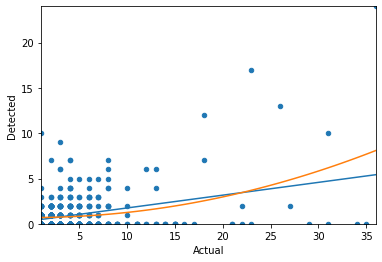

In [695]:
xi ='Actual'
yi ='Detected'
x = np.float64(countdf[xi])
y = np.float64(countdf[yi])
zl = np.polynomial.polynomial.Polynomial.fit(x, y, 1)
zp = np.polynomial.polynomial.Polynomial.fit(x, y, 2)

linear = []
poly = []
ytl = []

for q in np.linspace(x.min(),x.max()):
    poly.append(zp(q))
    linear.append(zl(q))
    ytl.append(q)

linear= pd.DataFrame(linear,index=ytl)
poly = pd.DataFrame(poly,index=ytl)
trendline = pd.merge(linear,poly, left_index=True,right_index=True,how='left')

fig, ax = plt.subplots()
ax.plot(trendline)
 
countdf.plot(kind='scatter',x=xi, y=yi, ax=ax, xlim=(x.min(),x.max()), ylim=(y.min(),y.max()))
print("Pearson's rank = " + str(scipy.stats.pearsonr(x, y)[0])) 

### Correlation of measures

<AxesSubplot:>

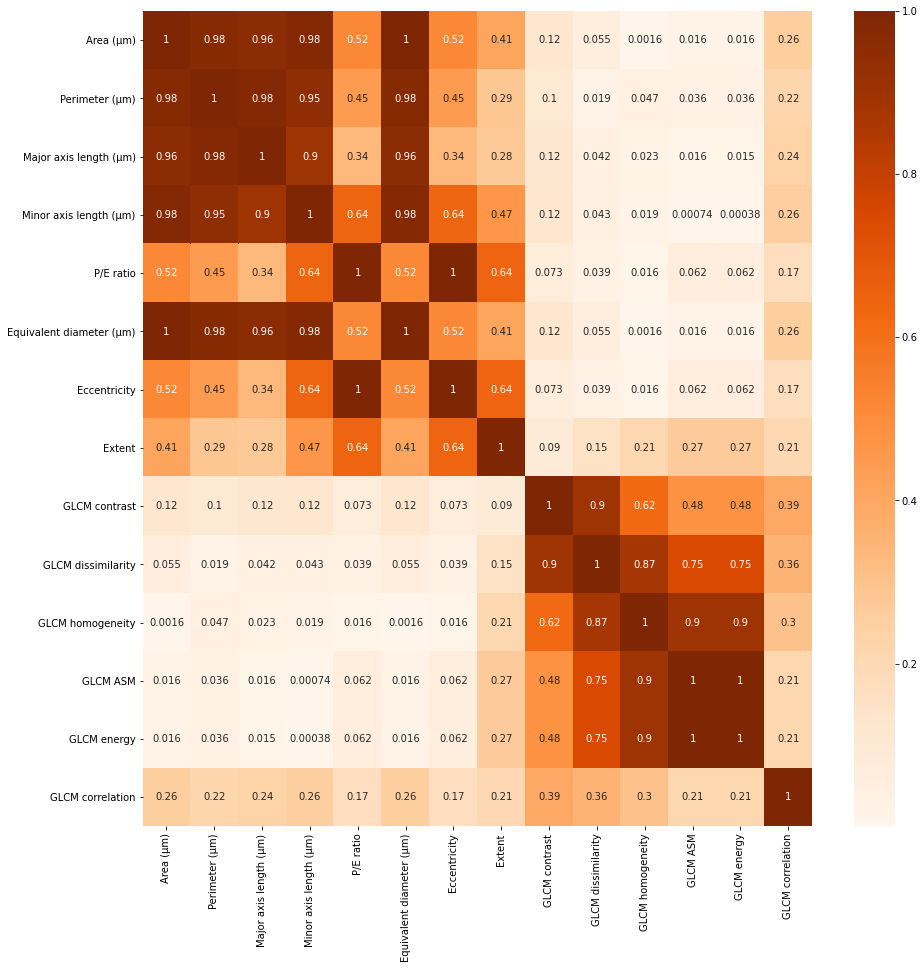

In [702]:
import seaborn as sn

correlation = measf.corr(method='spearman')

fig, ax = plt.subplots(figsize = (15,15))
sn.heatmap(abs(correlation),
           cmap="Oranges",
           annot=True)

### Compare any 2 measures in scatter plot
    -Change xi and yi to desired features

In [697]:
xi ='Major axis length (µm)'
yi ='Minor axis length (µm)'

Pearson's rank = 0.9076901828834868


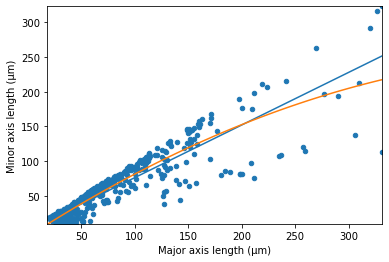

In [698]:
x = np.float64(measf[xi])
y = np.float64(measf[yi])
zl = np.polynomial.polynomial.Polynomial.fit(x, y, 1)
zp = np.polynomial.polynomial.Polynomial.fit(x, y, 2)

linear = []
poly = []
ytl = []

for q in np.linspace(x.min(),x.max()):
    poly.append(zp(q))
    linear.append(zl(q))
    ytl.append(q)

linear= pd.DataFrame(linear,index=ytl)
poly = pd.DataFrame(poly,index=ytl)
trendline = pd.merge(linear,poly, left_index=True,right_index=True,how='left')

fig, ax = plt.subplots()
ax.plot(trendline)
 
measf.plot(kind='scatter',x=xi, y=yi, ax=ax, xlim=(x.min(),x.max()), ylim=(y.min(),y.max()))
print("Pearson's rank = " + str(scipy.stats.pearsonr(x, y)[0])) 

### Histograms of measures

array([[<AxesSubplot:title={'center':'Area (µm)'}>,
        <AxesSubplot:title={'center':'Perimeter (µm)'}>,
        <AxesSubplot:title={'center':'Major axis length (µm)'}>,
        <AxesSubplot:title={'center':'Minor axis length (µm)'}>],
       [<AxesSubplot:title={'center':'P/E ratio'}>,
        <AxesSubplot:title={'center':'Equivalent diameter (µm)'}>,
        <AxesSubplot:title={'center':'Eccentricity'}>,
        <AxesSubplot:title={'center':'Extent'}>],
       [<AxesSubplot:title={'center':'GLCM contrast'}>,
        <AxesSubplot:title={'center':'GLCM dissimilarity'}>,
        <AxesSubplot:title={'center':'GLCM homogeneity'}>,
        <AxesSubplot:title={'center':'GLCM ASM'}>],
       [<AxesSubplot:title={'center':'GLCM energy'}>,
        <AxesSubplot:title={'center':'GLCM correlation'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

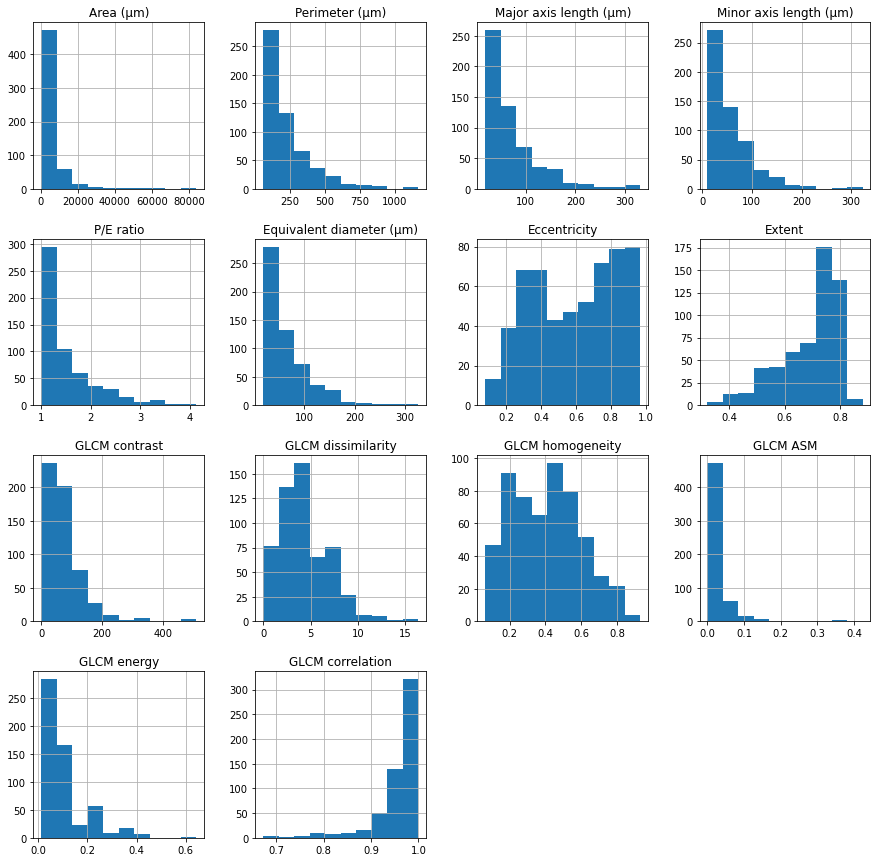

In [714]:
measf.hist(figsize = (15,15))